In [1]:
import numpy as np
import arviz as az
import pymc3 as pm
import pandas as pd
from scipy.stats import norm
from matplotlib import pyplot as plt
import theano.tensor as tt
from theano.compile.ops import as_op
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df = pd.read_csv('../data/pseudonymized-data.csv')

In [3]:
lk_27 = df[df.Community == 'Comm.Linux_Kernel'][df['V27'] != -1].V27

/home/raul/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [4]:
lk_27

277    5
292    4
296    3
303    4
306    4
308    3
310    5
311    4
313    4
315    4
317    4
330    4
332    3
335    4
340    5
342    4
350    2
352    4
354    4
Name: V27, dtype: int64

In [5]:
# Number of outcomes
nYlevels = 5

thresh = np.arange(1.5, nYlevels, dtype=np.float32)
thresh_obs = np.ma.asarray(thresh)
thresh_obs[1:-1] = np.ma.masked

print('thresh:\t\t{}'.format(thresh))
print('thresh_obs:\t{}'.format(thresh_obs))

thresh:		[1.5 2.5 3.5 4.5]
thresh_obs:	[1.5 -- -- 4.5]


/home/raul/.local/lib/python3.6/site-packages/pymc3/model.py:1331: UserWarning: Data in theta contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)


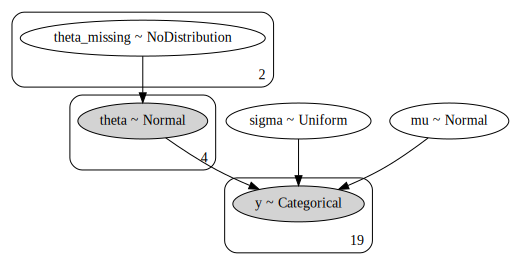

In [6]:
# Using the Theano @as_op decorator with a custom function to calculate the threshold probabilities.
# Theano cannot compute a gradient for these custom functions, so it is not possible to use
# gradient based samplers in PyMC3.
# http://pymc-devs.github.io/pymc3/notebooks/getting_started.html#Arbitrary-deterministics
@as_op(itypes=[tt.dvector, tt.dscalar, tt.dscalar], otypes=[tt.fvector])
def outcome_probabilities(theta, mu, sigma):
    out = np.empty(nYlevels, dtype=np.float32)
    n = norm(loc=mu, scale=sigma)       
    out[0] = n.cdf(theta[0])        
    out[1] = np.max([0, n.cdf(theta[1]) - n.cdf(theta[0])])
    out[2] = np.max([0, n.cdf(theta[2]) - n.cdf(theta[1])])
    out[3] = np.max([0, n.cdf(theta[3]) - n.cdf(theta[2])])
    out[4] = 1 - n.cdf(theta[3])
    return out

with pm.Model() as ordinal_model_single:    
    
    theta = pm.Normal('theta',mu=thresh,tau=np.repeat(.5**2, len(thresh)),shape=len(thresh),observed=thresh_obs)
    
    mu = pm.Normal('mu', mu=nYlevels/2.0, tau=1.0/(nYlevels**2))
    sigma = pm.Uniform('sigma', nYlevels/1000.0, nYlevels*10.0)
          
    pr = outcome_probabilities(theta, mu, sigma)
        
    y = pm.Categorical('y', pr, observed=lk_27-1)
    
pm.model_to_graphviz(ordinal_model_single)

In [7]:
with ordinal_model_single:
    trace = pm.sample(5000, cores=4)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Initializing NUTS failed. Falling back to elementwise auto-assignment.


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>Slice: [sigma]


>Slice: [mu]


>Slice: [theta_missing]


Sampling 4 chains:   0%|          | 0/22000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 7/22000 [00:00<05:20, 68.68draws/s]

Sampling 4 chains:   0%|          | 16/22000 [00:00<04:57, 73.77draws/s]

Sampling 4 chains:   0%|          | 26/22000 [00:00<04:38, 78.85draws/s]

Sampling 4 chains:   0%|          | 37/22000 [00:00<04:25, 82.80draws/s]

Sampling 4 chains:   0%|          | 48/22000 [00:00<04:21, 84.03draws/s]

Sampling 4 chains:   0%|          | 59/22000 [00:00<04:05, 89.53draws/s]

Sampling 4 chains:   0%|          | 69/22000 [00:00<04:02, 90.60draws/s]

Sampling 4 chains:   0%|          | 80/22000 [00:00<03:59, 91.52draws/s]

Sampling 4 chains:   0%|          | 91/22000 [00:00<03:54, 93.33draws/s]

Sampling 4 chains:   0%|          | 102/22000 [00:01<03:49, 95.32draws/s]

Sampling 4 chains:   1%|          | 114/22000 [00:01<03:40, 99.37draws/s]

Sampling 4 chains:   1%|          | 124/22000 [00:01<03:45, 96.86draws/s]

Sampling 4 chains:   1%|          | 135/22000 [00:01<03:41, 98.53draws/s]

Sampling 4 chains:   1%|          | 146/22000 [00:01<03:37, 100.70draws/s]

Sampling 4 chains:   1%|          | 158/22000 [00:01<03:34, 101.73draws/s]

Sampling 4 chains:   1%|          | 169/22000 [00:01<03:33, 102.46draws/s]

Sampling 4 chains:   1%|          | 180/22000 [00:01<03:30, 103.80draws/s]

Sampling 4 chains:   1%|          | 191/22000 [00:01<03:27, 104.88draws/s]

Sampling 4 chains:   1%|          | 202/22000 [00:02<03:36, 100.71draws/s]

Sampling 4 chains:   1%|          | 214/22000 [00:02<03:28, 104.50draws/s]

Sampling 4 chains:   1%|          | 225/22000 [00:02<03:36, 100.53draws/s]

Sampling 4 chains:   1%|          | 238/22000 [00:02<03:21, 107.76draws/s]

Sampling 4 chains:   1%|          | 249/22000 [00:02<03:27, 104.73draws/s]

Sampling 4 chains:   1%|          | 260/22000 [00:02<03:29, 103.59draws/s]

Sampling 4 chains:   1%|          | 272/22000 [00:02<03:28, 104.42draws/s]

Sampling 4 chains:   1%|▏         | 284/22000 [00:02<03:29, 103.69draws/s]

Sampling 4 chains:   1%|▏         | 295/22000 [00:02<03:32, 102.19draws/s]

Sampling 4 chains:   1%|▏         | 306/22000 [00:03<03:31, 102.50draws/s]

Sampling 4 chains:   1%|▏         | 317/22000 [00:03<03:28, 103.84draws/s]

Sampling 4 chains:   1%|▏         | 329/22000 [00:03<03:32, 102.05draws/s]

Sampling 4 chains:   2%|▏         | 340/22000 [00:03<03:31, 102.40draws/s]

Sampling 4 chains:   2%|▏         | 352/22000 [00:03<03:26, 104.96draws/s]

Sampling 4 chains:   2%|▏         | 364/22000 [00:03<03:18, 108.76draws/s]

Sampling 4 chains:   2%|▏         | 375/22000 [00:03<03:24, 105.78draws/s]

Sampling 4 chains:   2%|▏         | 386/22000 [00:03<03:33, 101.17draws/s]

Sampling 4 chains:   2%|▏         | 397/22000 [00:03<03:34, 100.88draws/s]

Sampling 4 chains:   2%|▏         | 408/22000 [00:04<03:34, 100.56draws/s]

Sampling 4 chains:   2%|▏         | 419/22000 [00:04<03:38, 98.86draws/s] 

Sampling 4 chains:   2%|▏         | 430/22000 [00:04<03:37, 99.19draws/s]

Sampling 4 chains:   2%|▏         | 443/22000 [00:04<03:33, 100.94draws/s]

Sampling 4 chains:   2%|▏         | 454/22000 [00:04<03:33, 101.01draws/s]

Sampling 4 chains:   2%|▏         | 465/22000 [00:04<03:33, 100.86draws/s]

Sampling 4 chains:   2%|▏         | 477/22000 [00:04<03:23, 105.69draws/s]

Sampling 4 chains:   2%|▏         | 488/22000 [00:04<03:37, 98.70draws/s] 

Sampling 4 chains:   2%|▏         | 499/22000 [00:04<03:38, 98.62draws/s]

Sampling 4 chains:   2%|▏         | 510/22000 [00:05<03:35, 99.91draws/s]

Sampling 4 chains:   2%|▏         | 522/22000 [00:05<03:36, 99.23draws/s]

Sampling 4 chains:   2%|▏         | 534/22000 [00:05<03:31, 101.47draws/s]

Sampling 4 chains:   2%|▏         | 545/22000 [00:05<03:30, 101.81draws/s]

Sampling 4 chains:   3%|▎         | 556/22000 [00:05<03:30, 101.80draws/s]

Sampling 4 chains:   3%|▎         | 568/22000 [00:05<03:28, 102.83draws/s]

Sampling 4 chains:   3%|▎         | 579/22000 [00:05<03:31, 101.14draws/s]

Sampling 4 chains:   3%|▎         | 590/22000 [00:05<03:26, 103.59draws/s]

Sampling 4 chains:   3%|▎         | 601/22000 [00:05<03:44, 95.34draws/s] 

Sampling 4 chains:   3%|▎         | 612/22000 [00:06<03:39, 97.50draws/s]

Sampling 4 chains:   3%|▎         | 622/22000 [00:06<03:41, 96.49draws/s]

Sampling 4 chains:   3%|▎         | 632/22000 [00:06<03:42, 96.12draws/s]

Sampling 4 chains:   3%|▎         | 642/22000 [00:06<03:49, 93.18draws/s]

Sampling 4 chains:   3%|▎         | 652/22000 [00:06<03:45, 94.62draws/s]

Sampling 4 chains:   3%|▎         | 662/22000 [00:06<03:45, 94.59draws/s]

Sampling 4 chains:   3%|▎         | 673/22000 [00:06<03:40, 96.89draws/s]

Sampling 4 chains:   3%|▎         | 685/22000 [00:06<03:41, 96.24draws/s]

Sampling 4 chains:   3%|▎         | 695/22000 [00:06<03:39, 97.08draws/s]

Sampling 4 chains:   3%|▎         | 706/22000 [00:07<03:43, 95.42draws/s]

Sampling 4 chains:   3%|▎         | 717/22000 [00:07<03:37, 97.89draws/s]

Sampling 4 chains:   3%|▎         | 729/22000 [00:07<03:32, 100.27draws/s]

Sampling 4 chains:   3%|▎         | 740/22000 [00:07<03:27, 102.64draws/s]

Sampling 4 chains:   3%|▎         | 751/22000 [00:07<03:31, 100.70draws/s]

Sampling 4 chains:   3%|▎         | 763/22000 [00:07<03:21, 105.33draws/s]

Sampling 4 chains:   4%|▎         | 774/22000 [00:07<03:21, 105.27draws/s]

Sampling 4 chains:   4%|▎         | 785/22000 [00:07<03:25, 103.31draws/s]

Sampling 4 chains:   4%|▎         | 797/22000 [00:07<03:20, 105.52draws/s]

Sampling 4 chains:   4%|▎         | 809/22000 [00:08<03:17, 107.49draws/s]

Sampling 4 chains:   4%|▎         | 821/22000 [00:08<03:18, 106.70draws/s]

Sampling 4 chains:   4%|▍         | 833/22000 [00:08<03:16, 107.89draws/s]

Sampling 4 chains:   4%|▍         | 844/22000 [00:08<03:20, 105.57draws/s]

Sampling 4 chains:   4%|▍         | 855/22000 [00:08<03:20, 105.22draws/s]

Sampling 4 chains:   4%|▍         | 866/22000 [00:08<03:25, 102.64draws/s]

Sampling 4 chains:   4%|▍         | 877/22000 [00:08<03:34, 98.65draws/s] 

Sampling 4 chains:   4%|▍         | 887/22000 [00:08<03:34, 98.58draws/s]

Sampling 4 chains:   4%|▍         | 897/22000 [00:08<03:42, 94.79draws/s]

Sampling 4 chains:   4%|▍         | 907/22000 [00:09<03:42, 94.62draws/s]

Sampling 4 chains:   4%|▍         | 919/22000 [00:09<03:33, 98.82draws/s]

Sampling 4 chains:   4%|▍         | 931/22000 [00:09<03:30, 99.96draws/s]

Sampling 4 chains:   4%|▍         | 942/22000 [00:09<03:25, 102.49draws/s]

Sampling 4 chains:   4%|▍         | 953/22000 [00:09<03:27, 101.57draws/s]

Sampling 4 chains:   4%|▍         | 964/22000 [00:09<03:24, 102.97draws/s]

Sampling 4 chains:   4%|▍         | 975/22000 [00:09<03:21, 104.22draws/s]

Sampling 4 chains:   4%|▍         | 986/22000 [00:09<03:19, 105.31draws/s]

Sampling 4 chains:   5%|▍         | 997/22000 [00:09<03:22, 103.85draws/s]

Sampling 4 chains:   5%|▍         | 1009/22000 [00:10<03:15, 107.31draws/s]

Sampling 4 chains:   5%|▍         | 1020/22000 [00:10<03:19, 105.25draws/s]

Sampling 4 chains:   5%|▍         | 1031/22000 [00:10<03:17, 106.24draws/s]

Sampling 4 chains:   5%|▍         | 1042/22000 [00:10<03:22, 103.67draws/s]

Sampling 4 chains:   5%|▍         | 1053/22000 [00:10<03:20, 104.56draws/s]

Sampling 4 chains:   5%|▍         | 1065/22000 [00:10<03:12, 108.72draws/s]

Sampling 4 chains:   5%|▍         | 1076/22000 [00:10<03:20, 104.40draws/s]

Sampling 4 chains:   5%|▍         | 1087/22000 [00:10<03:19, 104.96draws/s]

Sampling 4 chains:   5%|▍         | 1098/22000 [00:10<03:23, 102.93draws/s]

Sampling 4 chains:   5%|▌         | 1109/22000 [00:10<03:22, 103.24draws/s]

Sampling 4 chains:   5%|▌         | 1120/22000 [00:11<03:32, 98.18draws/s] 

Sampling 4 chains:   5%|▌         | 1131/22000 [00:11<03:35, 96.93draws/s]

Sampling 4 chains:   5%|▌         | 1143/22000 [00:11<03:25, 101.57draws/s]

Sampling 4 chains:   5%|▌         | 1155/22000 [00:11<03:20, 104.13draws/s]

Sampling 4 chains:   5%|▌         | 1166/22000 [00:11<03:18, 104.91draws/s]

Sampling 4 chains:   5%|▌         | 1177/22000 [00:11<03:20, 103.93draws/s]

Sampling 4 chains:   5%|▌         | 1188/22000 [00:11<03:22, 102.98draws/s]

Sampling 4 chains:   5%|▌         | 1199/22000 [00:11<03:23, 102.19draws/s]

Sampling 4 chains:   6%|▌         | 1210/22000 [00:11<03:31, 98.27draws/s] 

Sampling 4 chains:   6%|▌         | 1221/22000 [00:12<03:26, 100.78draws/s]

Sampling 4 chains:   6%|▌         | 1232/22000 [00:12<03:26, 100.42draws/s]

Sampling 4 chains:   6%|▌         | 1243/22000 [00:12<03:29, 99.30draws/s] 

Sampling 4 chains:   6%|▌         | 1254/22000 [00:12<03:25, 101.01draws/s]

Sampling 4 chains:   6%|▌         | 1265/22000 [00:12<03:20, 103.46draws/s]

Sampling 4 chains:   6%|▌         | 1276/22000 [00:12<03:18, 104.61draws/s]

Sampling 4 chains:   6%|▌         | 1287/22000 [00:12<03:27, 100.05draws/s]

Sampling 4 chains:   6%|▌         | 1298/22000 [00:12<03:29, 98.98draws/s] 

Sampling 4 chains:   6%|▌         | 1309/22000 [00:12<03:30, 98.31draws/s]

Sampling 4 chains:   6%|▌         | 1321/22000 [00:13<03:23, 101.62draws/s]

Sampling 4 chains:   6%|▌         | 1332/22000 [00:13<03:22, 101.97draws/s]

Sampling 4 chains:   6%|▌         | 1343/22000 [00:13<03:27, 99.37draws/s] 

Sampling 4 chains:   6%|▌         | 1353/22000 [00:13<03:29, 98.48draws/s]

Sampling 4 chains:   6%|▌         | 1363/22000 [00:13<03:30, 97.97draws/s]

Sampling 4 chains:   6%|▌         | 1373/22000 [00:13<03:30, 98.22draws/s]

Sampling 4 chains:   6%|▋         | 1383/22000 [00:13<03:32, 96.84draws/s]

Sampling 4 chains:   6%|▋         | 1394/22000 [00:13<03:28, 98.79draws/s]

Sampling 4 chains:   6%|▋         | 1404/22000 [00:13<03:31, 97.39draws/s]

Sampling 4 chains:   6%|▋         | 1415/22000 [00:14<03:26, 99.70draws/s]

Sampling 4 chains:   6%|▋         | 1426/22000 [00:14<03:24, 100.62draws/s]

Sampling 4 chains:   7%|▋         | 1437/22000 [00:14<03:22, 101.32draws/s]

Sampling 4 chains:   7%|▋         | 1448/22000 [00:14<03:29, 98.07draws/s] 

Sampling 4 chains:   7%|▋         | 1460/22000 [00:14<03:18, 103.28draws/s]

Sampling 4 chains:   7%|▋         | 1471/22000 [00:14<03:17, 103.73draws/s]

Sampling 4 chains:   7%|▋         | 1482/22000 [00:14<03:14, 105.52draws/s]

Sampling 4 chains:   7%|▋         | 1493/22000 [00:14<03:14, 105.57draws/s]

Sampling 4 chains:   7%|▋         | 1504/22000 [00:14<03:29, 98.01draws/s] 

Sampling 4 chains:   7%|▋         | 1516/22000 [00:15<03:21, 101.86draws/s]

Sampling 4 chains:   7%|▋         | 1527/22000 [00:15<03:18, 103.17draws/s]

Sampling 4 chains:   7%|▋         | 1538/22000 [00:15<03:18, 102.94draws/s]

Sampling 4 chains:   7%|▋         | 1549/22000 [00:15<03:20, 101.82draws/s]

Sampling 4 chains:   7%|▋         | 1560/22000 [00:15<03:22, 101.14draws/s]

Sampling 4 chains:   7%|▋         | 1571/22000 [00:15<03:17, 103.48draws/s]

Sampling 4 chains:   7%|▋         | 1582/22000 [00:15<03:19, 102.57draws/s]

Sampling 4 chains:   7%|▋         | 1593/22000 [00:15<03:16, 103.67draws/s]

Sampling 4 chains:   7%|▋         | 1604/22000 [00:15<03:20, 101.53draws/s]

Sampling 4 chains:   7%|▋         | 1615/22000 [00:15<03:16, 103.48draws/s]

Sampling 4 chains:   7%|▋         | 1626/22000 [00:16<03:22, 100.67draws/s]

Sampling 4 chains:   7%|▋         | 1637/22000 [00:16<03:19, 102.06draws/s]

Sampling 4 chains:   7%|▋         | 1649/22000 [00:16<03:11, 106.53draws/s]

Sampling 4 chains:   8%|▊         | 1660/22000 [00:16<03:15, 104.16draws/s]

Sampling 4 chains:   8%|▊         | 1671/22000 [00:16<03:15, 104.17draws/s]

Sampling 4 chains:   8%|▊         | 1683/22000 [00:16<03:12, 105.72draws/s]

Sampling 4 chains:   8%|▊         | 1694/22000 [00:16<03:20, 101.16draws/s]

Sampling 4 chains:   8%|▊         | 1705/22000 [00:16<03:15, 103.59draws/s]

Sampling 4 chains:   8%|▊         | 1717/22000 [00:16<03:17, 102.46draws/s]

Sampling 4 chains:   8%|▊         | 1729/22000 [00:17<03:15, 103.44draws/s]

Sampling 4 chains:   8%|▊         | 1740/22000 [00:17<03:15, 103.59draws/s]

Sampling 4 chains:   8%|▊         | 1751/22000 [00:17<03:19, 101.28draws/s]

Sampling 4 chains:   8%|▊         | 1762/22000 [00:17<03:17, 102.23draws/s]

Sampling 4 chains:   8%|▊         | 1773/22000 [00:17<03:16, 102.76draws/s]

Sampling 4 chains:   8%|▊         | 1784/22000 [00:17<03:24, 98.93draws/s] 

Sampling 4 chains:   8%|▊         | 1795/22000 [00:17<03:21, 100.31draws/s]

Sampling 4 chains:   8%|▊         | 1807/22000 [00:17<03:25, 98.43draws/s] 

Sampling 4 chains:   8%|▊         | 1818/22000 [00:17<03:24, 98.66draws/s]

Sampling 4 chains:   8%|▊         | 1830/22000 [00:18<03:14, 103.57draws/s]

Sampling 4 chains:   8%|▊         | 1841/22000 [00:18<03:17, 102.11draws/s]

Sampling 4 chains:   8%|▊         | 1852/22000 [00:18<03:16, 102.68draws/s]

Sampling 4 chains:   8%|▊         | 1863/22000 [00:18<03:22, 99.42draws/s] 

Sampling 4 chains:   9%|▊         | 1873/22000 [00:18<03:23, 98.96draws/s]

Sampling 4 chains:   9%|▊         | 1883/22000 [00:18<03:24, 98.54draws/s]

Sampling 4 chains:   9%|▊         | 1893/22000 [00:18<03:25, 97.76draws/s]

Sampling 4 chains:   9%|▊         | 1903/22000 [00:18<03:31, 94.83draws/s]

Sampling 4 chains:   9%|▊         | 1915/22000 [00:18<03:20, 99.99draws/s]

Sampling 4 chains:   9%|▉         | 1926/22000 [00:19<03:25, 97.62draws/s]

Sampling 4 chains:   9%|▉         | 1937/22000 [00:19<03:28, 96.34draws/s]

Sampling 4 chains:   9%|▉         | 1948/22000 [00:19<03:20, 99.85draws/s]

Sampling 4 chains:   9%|▉         | 1959/22000 [00:19<03:20, 100.08draws/s]

Sampling 4 chains:   9%|▉         | 1970/22000 [00:19<03:29, 95.83draws/s] 

Sampling 4 chains:   9%|▉         | 1981/22000 [00:19<03:22, 98.64draws/s]

Sampling 4 chains:   9%|▉         | 1993/22000 [00:19<03:14, 103.11draws/s]

Sampling 4 chains:   9%|▉         | 2004/22000 [00:19<03:15, 102.51draws/s]

Sampling 4 chains:   9%|▉         | 2015/22000 [00:19<03:15, 102.27draws/s]

Sampling 4 chains:   9%|▉         | 2026/22000 [00:20<03:17, 100.95draws/s]

Sampling 4 chains:   9%|▉         | 2037/22000 [00:20<03:20, 99.40draws/s] 

Sampling 4 chains:   9%|▉         | 2049/22000 [00:20<03:18, 100.60draws/s]

Sampling 4 chains:   9%|▉         | 2060/22000 [00:20<03:13, 103.08draws/s]

Sampling 4 chains:   9%|▉         | 2071/22000 [00:20<03:19, 99.70draws/s] 

Sampling 4 chains:   9%|▉         | 2082/22000 [00:20<03:24, 97.53draws/s]

Sampling 4 chains:  10%|▉         | 2092/22000 [00:20<03:22, 98.20draws/s]

Sampling 4 chains:  10%|▉         | 2102/22000 [00:20<03:25, 96.98draws/s]

Sampling 4 chains:  10%|▉         | 2112/22000 [00:20<03:26, 96.12draws/s]

Sampling 4 chains:  10%|▉         | 2122/22000 [00:21<03:27, 95.63draws/s]

Sampling 4 chains:  10%|▉         | 2132/22000 [00:21<03:30, 94.43draws/s]

Sampling 4 chains:  10%|▉         | 2143/22000 [00:21<03:25, 96.62draws/s]

Sampling 4 chains:  10%|▉         | 2155/22000 [00:21<03:19, 99.59draws/s]

Sampling 4 chains:  10%|▉         | 2166/22000 [00:21<03:17, 100.27draws/s]

Sampling 4 chains:  10%|▉         | 2177/22000 [00:21<03:22, 97.79draws/s] 

Sampling 4 chains:  10%|▉         | 2189/22000 [00:21<03:12, 102.69draws/s]

Sampling 4 chains:  10%|█         | 2200/22000 [00:21<03:13, 102.27draws/s]

Sampling 4 chains:  10%|█         | 2211/22000 [00:21<03:20, 98.75draws/s] 

Sampling 4 chains:  10%|█         | 2221/22000 [00:22<03:25, 96.13draws/s]

Sampling 4 chains:  10%|█         | 2231/22000 [00:22<03:26, 95.95draws/s]

Sampling 4 chains:  10%|█         | 2242/22000 [00:22<03:19, 98.82draws/s]

Sampling 4 chains:  10%|█         | 2254/22000 [00:22<03:18, 99.59draws/s]

Sampling 4 chains:  10%|█         | 2265/22000 [00:22<03:12, 102.42draws/s]

Sampling 4 chains:  10%|█         | 2276/22000 [00:22<03:19, 98.94draws/s] 

Sampling 4 chains:  10%|█         | 2287/22000 [00:22<03:13, 101.78draws/s]

Sampling 4 chains:  10%|█         | 2299/22000 [00:22<03:11, 102.99draws/s]

Sampling 4 chains:  10%|█         | 2310/22000 [00:22<03:11, 102.66draws/s]

Sampling 4 chains:  11%|█         | 2322/22000 [00:23<03:08, 104.31draws/s]

Sampling 4 chains:  11%|█         | 2333/22000 [00:23<03:07, 104.69draws/s]

Sampling 4 chains:  11%|█         | 2345/22000 [00:23<03:10, 103.16draws/s]

Sampling 4 chains:  11%|█         | 2356/22000 [00:23<03:07, 104.78draws/s]

Sampling 4 chains:  11%|█         | 2367/22000 [00:23<03:09, 103.83draws/s]

Sampling 4 chains:  11%|█         | 2378/22000 [00:23<03:10, 102.95draws/s]

Sampling 4 chains:  11%|█         | 2389/22000 [00:23<03:13, 101.55draws/s]

Sampling 4 chains:  11%|█         | 2401/22000 [00:23<03:08, 104.15draws/s]

Sampling 4 chains:  11%|█         | 2412/22000 [00:23<03:05, 105.35draws/s]

Sampling 4 chains:  11%|█         | 2423/22000 [00:23<03:16, 99.42draws/s] 

Sampling 4 chains:  11%|█         | 2434/22000 [00:24<03:19, 97.93draws/s]

Sampling 4 chains:  11%|█         | 2445/22000 [00:24<03:18, 98.61draws/s]

Sampling 4 chains:  11%|█         | 2455/22000 [00:24<03:25, 94.96draws/s]

Sampling 4 chains:  11%|█         | 2465/22000 [00:24<03:24, 95.57draws/s]

Sampling 4 chains:  11%|█▏        | 2476/22000 [00:24<03:22, 96.45draws/s]

Sampling 4 chains:  11%|█▏        | 2487/22000 [00:24<03:19, 97.78draws/s]

Sampling 4 chains:  11%|█▏        | 2498/22000 [00:24<03:16, 99.09draws/s]

Sampling 4 chains:  11%|█▏        | 2510/22000 [00:24<03:08, 103.15draws/s]

Sampling 4 chains:  11%|█▏        | 2522/22000 [00:24<03:13, 100.75draws/s]

Sampling 4 chains:  12%|█▏        | 2534/22000 [00:25<03:07, 103.87draws/s]

Sampling 4 chains:  12%|█▏        | 2545/22000 [00:25<03:07, 103.73draws/s]

Sampling 4 chains:  12%|█▏        | 2556/22000 [00:25<03:04, 105.48draws/s]

Sampling 4 chains:  12%|█▏        | 2567/22000 [00:25<03:08, 103.12draws/s]

Sampling 4 chains:  12%|█▏        | 2578/22000 [00:25<03:15, 99.20draws/s] 

Sampling 4 chains:  12%|█▏        | 2588/22000 [00:25<03:18, 97.82draws/s]

Sampling 4 chains:  12%|█▏        | 2598/22000 [00:25<03:18, 97.53draws/s]

Sampling 4 chains:  12%|█▏        | 2608/22000 [00:25<03:25, 94.15draws/s]

Sampling 4 chains:  12%|█▏        | 2619/22000 [00:25<03:33, 90.82draws/s]

Sampling 4 chains:  12%|█▏        | 2631/22000 [00:26<03:20, 96.62draws/s]

Sampling 4 chains:  12%|█▏        | 2642/22000 [00:26<03:21, 96.19draws/s]

Sampling 4 chains:  12%|█▏        | 2652/22000 [00:26<03:19, 97.01draws/s]

Sampling 4 chains:  12%|█▏        | 2662/22000 [00:26<03:17, 97.87draws/s]

Sampling 4 chains:  12%|█▏        | 2673/22000 [00:26<03:14, 99.45draws/s]

Sampling 4 chains:  12%|█▏        | 2685/22000 [00:26<03:17, 97.81draws/s]

Sampling 4 chains:  12%|█▏        | 2697/22000 [00:26<03:10, 101.07draws/s]

Sampling 4 chains:  12%|█▏        | 2709/22000 [00:26<03:09, 101.54draws/s]

Sampling 4 chains:  12%|█▏        | 2721/22000 [00:26<03:10, 101.14draws/s]

Sampling 4 chains:  12%|█▏        | 2732/22000 [00:27<03:09, 101.59draws/s]

Sampling 4 chains:  12%|█▏        | 2743/22000 [00:27<03:06, 103.09draws/s]

Sampling 4 chains:  13%|█▎        | 2754/22000 [00:27<03:09, 101.82draws/s]

Sampling 4 chains:  13%|█▎        | 2765/22000 [00:27<03:10, 100.88draws/s]

Sampling 4 chains:  13%|█▎        | 2777/22000 [00:27<03:06, 103.26draws/s]

Sampling 4 chains:  13%|█▎        | 2789/22000 [00:27<03:04, 104.07draws/s]

Sampling 4 chains:  13%|█▎        | 2800/22000 [00:27<03:06, 103.19draws/s]

Sampling 4 chains:  13%|█▎        | 2811/22000 [00:27<03:13, 99.27draws/s] 

Sampling 4 chains:  13%|█▎        | 2821/22000 [00:27<03:16, 97.77draws/s]

Sampling 4 chains:  13%|█▎        | 2831/22000 [00:28<03:20, 95.61draws/s]

Sampling 4 chains:  13%|█▎        | 2841/22000 [00:28<03:28, 91.84draws/s]

Sampling 4 chains:  13%|█▎        | 2853/22000 [00:28<03:17, 96.89draws/s]

Sampling 4 chains:  13%|█▎        | 2864/22000 [00:28<03:10, 100.43draws/s]

Sampling 4 chains:  13%|█▎        | 2875/22000 [00:28<03:08, 101.20draws/s]

Sampling 4 chains:  13%|█▎        | 2886/22000 [00:28<03:06, 102.76draws/s]

Sampling 4 chains:  13%|█▎        | 2897/22000 [00:28<03:10, 100.51draws/s]

Sampling 4 chains:  13%|█▎        | 2908/22000 [00:28<03:10, 100.43draws/s]

Sampling 4 chains:  13%|█▎        | 2919/22000 [00:28<03:10, 99.92draws/s] 

Sampling 4 chains:  13%|█▎        | 2930/22000 [00:29<03:13, 98.31draws/s]

Sampling 4 chains:  13%|█▎        | 2940/22000 [00:29<03:15, 97.67draws/s]

Sampling 4 chains:  13%|█▎        | 2950/22000 [00:29<03:21, 94.63draws/s]

Sampling 4 chains:  13%|█▎        | 2961/22000 [00:29<03:16, 97.08draws/s]

Sampling 4 chains:  14%|█▎        | 2972/22000 [00:29<03:19, 95.54draws/s]

Sampling 4 chains:  14%|█▎        | 2984/22000 [00:29<03:13, 98.20draws/s]

Sampling 4 chains:  14%|█▎        | 2995/22000 [00:29<03:08, 100.97draws/s]

Sampling 4 chains:  14%|█▎        | 3006/22000 [00:29<03:09, 100.21draws/s]

Sampling 4 chains:  14%|█▎        | 3017/22000 [00:29<03:17, 96.33draws/s] 

Sampling 4 chains:  14%|█▍        | 3029/22000 [00:30<03:05, 102.12draws/s]

Sampling 4 chains:  14%|█▍        | 3040/22000 [00:30<03:09, 100.08draws/s]

Sampling 4 chains:  14%|█▍        | 3051/22000 [00:30<03:11, 99.19draws/s] 

Sampling 4 chains:  14%|█▍        | 3063/22000 [00:30<03:08, 100.36draws/s]

Sampling 4 chains:  14%|█▍        | 3074/22000 [00:30<03:04, 102.57draws/s]

Sampling 4 chains:  14%|█▍        | 3085/22000 [00:30<03:03, 102.83draws/s]

Sampling 4 chains:  14%|█▍        | 3096/22000 [00:30<03:12, 98.37draws/s] 

Sampling 4 chains:  14%|█▍        | 3107/22000 [00:30<03:12, 98.21draws/s]

Sampling 4 chains:  14%|█▍        | 3118/22000 [00:30<03:06, 101.31draws/s]

Sampling 4 chains:  14%|█▍        | 3129/22000 [00:31<03:04, 102.29draws/s]

Sampling 4 chains:  14%|█▍        | 3140/22000 [00:31<03:08, 100.27draws/s]

Sampling 4 chains:  14%|█▍        | 3151/22000 [00:31<03:06, 101.16draws/s]

Sampling 4 chains:  14%|█▍        | 3162/22000 [00:31<03:03, 102.62draws/s]

Sampling 4 chains:  14%|█▍        | 3173/22000 [00:31<03:01, 103.61draws/s]

Sampling 4 chains:  14%|█▍        | 3184/22000 [00:31<03:03, 102.28draws/s]

Sampling 4 chains:  15%|█▍        | 3195/22000 [00:31<03:00, 104.29draws/s]

Sampling 4 chains:  15%|█▍        | 3206/22000 [00:31<03:03, 102.50draws/s]

Sampling 4 chains:  15%|█▍        | 3217/22000 [00:31<03:12, 97.58draws/s] 

Sampling 4 chains:  15%|█▍        | 3228/22000 [00:32<03:14, 96.73draws/s]

Sampling 4 chains:  15%|█▍        | 3239/22000 [00:32<03:12, 97.28draws/s]

Sampling 4 chains:  15%|█▍        | 3249/22000 [00:32<03:12, 97.44draws/s]

Sampling 4 chains:  15%|█▍        | 3260/22000 [00:32<03:06, 100.47draws/s]

Sampling 4 chains:  15%|█▍        | 3271/22000 [00:32<03:07, 99.79draws/s] 

Sampling 4 chains:  15%|█▍        | 3282/22000 [00:32<03:05, 101.08draws/s]

Sampling 4 chains:  15%|█▍        | 3295/22000 [00:32<02:54, 107.32draws/s]

Sampling 4 chains:  15%|█▌        | 3306/22000 [00:32<02:59, 104.02draws/s]

Sampling 4 chains:  15%|█▌        | 3317/22000 [00:32<03:02, 102.63draws/s]

Sampling 4 chains:  15%|█▌        | 3329/22000 [00:33<02:59, 104.02draws/s]

Sampling 4 chains:  15%|█▌        | 3340/22000 [00:33<02:56, 105.51draws/s]

Sampling 4 chains:  15%|█▌        | 3351/22000 [00:33<03:01, 102.86draws/s]

Sampling 4 chains:  15%|█▌        | 3363/22000 [00:33<03:06, 99.98draws/s] 

Sampling 4 chains:  15%|█▌        | 3375/22000 [00:33<03:02, 101.93draws/s]

Sampling 4 chains:  15%|█▌        | 3386/22000 [00:33<03:05, 100.19draws/s]

Sampling 4 chains:  15%|█▌        | 3397/22000 [00:33<03:01, 102.75draws/s]

Sampling 4 chains:  15%|█▌        | 3408/22000 [00:33<03:00, 103.27draws/s]

Sampling 4 chains:  16%|█▌        | 3420/22000 [00:33<03:00, 103.00draws/s]

Sampling 4 chains:  16%|█▌        | 3431/22000 [00:34<03:02, 101.49draws/s]

Sampling 4 chains:  16%|█▌        | 3442/22000 [00:34<02:59, 103.51draws/s]

Sampling 4 chains:  16%|█▌        | 3453/22000 [00:34<03:09, 97.64draws/s] 

Sampling 4 chains:  16%|█▌        | 3464/22000 [00:34<03:09, 97.72draws/s]

Sampling 4 chains:  16%|█▌        | 3475/22000 [00:34<03:09, 97.51draws/s]

Sampling 4 chains:  16%|█▌        | 3486/22000 [00:34<03:06, 99.10draws/s]

Sampling 4 chains:  16%|█▌        | 3497/22000 [00:34<03:14, 94.89draws/s]

Sampling 4 chains:  16%|█▌        | 3509/22000 [00:34<03:04, 100.02draws/s]

Sampling 4 chains:  16%|█▌        | 3520/22000 [00:34<03:01, 101.61draws/s]

Sampling 4 chains:  16%|█▌        | 3531/22000 [00:35<03:06, 99.13draws/s] 

Sampling 4 chains:  16%|█▌        | 3542/22000 [00:35<03:02, 101.15draws/s]

Sampling 4 chains:  16%|█▌        | 3553/22000 [00:35<03:02, 101.32draws/s]

Sampling 4 chains:  16%|█▌        | 3565/22000 [00:35<02:56, 104.22draws/s]

Sampling 4 chains:  16%|█▋        | 3576/22000 [00:35<02:54, 105.63draws/s]

Sampling 4 chains:  16%|█▋        | 3587/22000 [00:35<02:55, 104.73draws/s]

Sampling 4 chains:  16%|█▋        | 3598/22000 [00:35<03:07, 97.90draws/s] 

Sampling 4 chains:  16%|█▋        | 3609/22000 [00:35<03:05, 99.40draws/s]

Sampling 4 chains:  16%|█▋        | 3620/22000 [00:35<03:07, 97.99draws/s]

Sampling 4 chains:  16%|█▋        | 3630/22000 [00:36<03:08, 97.70draws/s]

Sampling 4 chains:  17%|█▋        | 3640/22000 [00:36<03:06, 98.30draws/s]

Sampling 4 chains:  17%|█▋        | 3651/22000 [00:36<03:04, 99.20draws/s]

Sampling 4 chains:  17%|█▋        | 3661/22000 [00:36<03:08, 97.33draws/s]

Sampling 4 chains:  17%|█▋        | 3671/22000 [00:36<03:13, 94.50draws/s]

Sampling 4 chains:  17%|█▋        | 3681/22000 [00:36<03:11, 95.57draws/s]

Sampling 4 chains:  17%|█▋        | 3692/22000 [00:36<03:09, 96.51draws/s]

Sampling 4 chains:  17%|█▋        | 3704/22000 [00:36<03:07, 97.32draws/s]

Sampling 4 chains:  17%|█▋        | 3715/22000 [00:36<03:01, 100.63draws/s]

Sampling 4 chains:  17%|█▋        | 3726/22000 [00:37<03:01, 100.46draws/s]

Sampling 4 chains:  17%|█▋        | 3737/22000 [00:37<03:03, 99.30draws/s] 

Sampling 4 chains:  17%|█▋        | 3749/22000 [00:37<02:54, 104.35draws/s]

Sampling 4 chains:  17%|█▋        | 3760/22000 [00:37<03:00, 101.19draws/s]

Sampling 4 chains:  17%|█▋        | 3771/22000 [00:37<03:01, 100.24draws/s]

Sampling 4 chains:  17%|█▋        | 3782/22000 [00:37<03:05, 98.02draws/s] 

Sampling 4 chains:  17%|█▋        | 3793/22000 [00:37<03:06, 97.73draws/s]

Sampling 4 chains:  17%|█▋        | 3804/22000 [00:37<03:00, 100.73draws/s]

Sampling 4 chains:  17%|█▋        | 3815/22000 [00:37<02:58, 101.80draws/s]

Sampling 4 chains:  17%|█▋        | 3826/22000 [00:38<02:55, 103.83draws/s]

Sampling 4 chains:  17%|█▋        | 3837/22000 [00:38<03:04, 98.27draws/s] 

Sampling 4 chains:  17%|█▋        | 3848/22000 [00:38<03:05, 97.91draws/s]

Sampling 4 chains:  18%|█▊        | 3858/22000 [00:38<03:06, 97.52draws/s]

Sampling 4 chains:  18%|█▊        | 3869/22000 [00:38<03:07, 96.75draws/s]

Sampling 4 chains:  18%|█▊        | 3879/22000 [00:38<03:09, 95.84draws/s]

Sampling 4 chains:  18%|█▊        | 3890/22000 [00:38<03:05, 97.59draws/s]

Sampling 4 chains:  18%|█▊        | 3900/22000 [00:38<03:04, 97.99draws/s]

Sampling 4 chains:  18%|█▊        | 3912/22000 [00:38<02:56, 102.39draws/s]

Sampling 4 chains:  18%|█▊        | 3923/22000 [00:39<03:11, 94.50draws/s] 

Sampling 4 chains:  18%|█▊        | 3933/22000 [00:39<03:17, 91.48draws/s]

Sampling 4 chains:  18%|█▊        | 3943/22000 [00:39<03:23, 88.89draws/s]

Sampling 4 chains:  18%|█▊        | 3953/22000 [00:39<03:30, 85.71draws/s]

Sampling 4 chains:  18%|█▊        | 3964/22000 [00:39<03:25, 87.63draws/s]

Sampling 4 chains:  18%|█▊        | 3973/22000 [00:39<03:33, 84.54draws/s]

Sampling 4 chains:  18%|█▊        | 3982/22000 [00:39<03:30, 85.53draws/s]

Sampling 4 chains:  18%|█▊        | 3991/22000 [00:39<03:37, 82.76draws/s]

Sampling 4 chains:  18%|█▊        | 4000/22000 [00:39<03:38, 82.35draws/s]

Sampling 4 chains:  18%|█▊        | 4009/22000 [00:40<03:40, 81.62draws/s]

Sampling 4 chains:  18%|█▊        | 4018/22000 [00:40<03:49, 78.31draws/s]

Sampling 4 chains:  18%|█▊        | 4028/22000 [00:40<03:46, 79.45draws/s]

Sampling 4 chains:  18%|█▊        | 4036/22000 [00:40<03:47, 78.87draws/s]

Sampling 4 chains:  18%|█▊        | 4044/22000 [00:40<03:49, 78.27draws/s]

Sampling 4 chains:  18%|█▊        | 4054/22000 [00:40<03:43, 80.27draws/s]

Sampling 4 chains:  18%|█▊        | 4064/22000 [00:40<03:40, 81.23draws/s]

Sampling 4 chains:  19%|█▊        | 4074/22000 [00:40<03:36, 82.91draws/s]

Sampling 4 chains:  19%|█▊        | 4083/22000 [00:40<03:40, 81.19draws/s]

Sampling 4 chains:  19%|█▊        | 4093/22000 [00:41<03:34, 83.66draws/s]

Sampling 4 chains:  19%|█▊        | 4103/22000 [00:41<03:37, 82.28draws/s]

Sampling 4 chains:  19%|█▊        | 4112/22000 [00:41<03:34, 83.55draws/s]

Sampling 4 chains:  19%|█▊        | 4121/22000 [00:41<03:45, 79.16draws/s]

Sampling 4 chains:  19%|█▉        | 4130/22000 [00:41<03:44, 79.50draws/s]

Sampling 4 chains:  19%|█▉        | 4139/22000 [00:41<03:39, 81.43draws/s]

Sampling 4 chains:  19%|█▉        | 4148/22000 [00:41<03:49, 77.94draws/s]

Sampling 4 chains:  19%|█▉        | 4157/22000 [00:41<03:44, 79.33draws/s]

Sampling 4 chains:  19%|█▉        | 4165/22000 [00:42<03:50, 77.28draws/s]

Sampling 4 chains:  19%|█▉        | 4174/22000 [00:42<03:54, 76.15draws/s]

Sampling 4 chains:  19%|█▉        | 4183/22000 [00:42<03:43, 79.61draws/s]

Sampling 4 chains:  19%|█▉        | 4192/22000 [00:42<03:43, 79.58draws/s]

Sampling 4 chains:  19%|█▉        | 4201/22000 [00:42<03:48, 77.90draws/s]

Sampling 4 chains:  19%|█▉        | 4210/22000 [00:42<03:52, 76.49draws/s]

Sampling 4 chains:  19%|█▉        | 4218/22000 [00:42<03:50, 77.05draws/s]

Sampling 4 chains:  19%|█▉        | 4227/22000 [00:42<03:44, 79.12draws/s]

Sampling 4 chains:  19%|█▉        | 4235/22000 [00:42<03:50, 77.06draws/s]

Sampling 4 chains:  19%|█▉        | 4244/22000 [00:43<03:41, 80.19draws/s]

Sampling 4 chains:  19%|█▉        | 4253/22000 [00:43<03:44, 79.21draws/s]

Sampling 4 chains:  19%|█▉        | 4261/22000 [00:43<03:48, 77.50draws/s]

Sampling 4 chains:  19%|█▉        | 4269/22000 [00:43<03:50, 77.05draws/s]

Sampling 4 chains:  19%|█▉        | 4277/22000 [00:43<03:59, 73.93draws/s]

Sampling 4 chains:  19%|█▉        | 4285/22000 [00:43<03:55, 75.08draws/s]

Sampling 4 chains:  20%|█▉        | 4294/22000 [00:43<03:57, 74.52draws/s]

Sampling 4 chains:  20%|█▉        | 4304/22000 [00:43<03:43, 79.17draws/s]

Sampling 4 chains:  20%|█▉        | 4313/22000 [00:43<03:43, 79.17draws/s]

Sampling 4 chains:  20%|█▉        | 4322/22000 [00:44<03:50, 76.75draws/s]

Sampling 4 chains:  20%|█▉        | 4331/22000 [00:44<03:41, 79.93draws/s]

Sampling 4 chains:  20%|█▉        | 4340/22000 [00:44<03:43, 78.87draws/s]

Sampling 4 chains:  20%|█▉        | 4348/22000 [00:44<03:44, 78.58draws/s]

Sampling 4 chains:  20%|█▉        | 4357/22000 [00:44<03:38, 80.76draws/s]

Sampling 4 chains:  20%|█▉        | 4366/22000 [00:44<04:04, 72.09draws/s]

Sampling 4 chains:  20%|█▉        | 4374/22000 [00:44<04:10, 70.48draws/s]

Sampling 4 chains:  20%|█▉        | 4383/22000 [00:44<03:53, 75.38draws/s]

Sampling 4 chains:  20%|█▉        | 4393/22000 [00:44<03:38, 80.47draws/s]

Sampling 4 chains:  20%|██        | 4403/22000 [00:45<03:28, 84.37draws/s]

Sampling 4 chains:  20%|██        | 4412/22000 [00:45<03:37, 80.99draws/s]

Sampling 4 chains:  20%|██        | 4421/22000 [00:45<03:45, 77.89draws/s]

Sampling 4 chains:  20%|██        | 4429/22000 [00:45<03:43, 78.49draws/s]

Sampling 4 chains:  20%|██        | 4439/22000 [00:45<03:41, 79.39draws/s]

Sampling 4 chains:  20%|██        | 4449/22000 [00:45<03:27, 84.43draws/s]

Sampling 4 chains:  20%|██        | 4459/22000 [00:45<03:18, 88.26draws/s]

Sampling 4 chains:  20%|██        | 4470/22000 [00:45<03:08, 93.17draws/s]

Sampling 4 chains:  20%|██        | 4480/22000 [00:45<03:04, 95.05draws/s]

Sampling 4 chains:  20%|██        | 4492/22000 [00:46<02:53, 100.75draws/s]

Sampling 4 chains:  20%|██        | 4503/22000 [00:46<02:51, 102.05draws/s]

Sampling 4 chains:  21%|██        | 4514/22000 [00:46<02:56, 99.34draws/s] 

Sampling 4 chains:  21%|██        | 4525/22000 [00:46<03:08, 92.78draws/s]

Sampling 4 chains:  21%|██        | 4536/22000 [00:46<03:00, 96.71draws/s]

Sampling 4 chains:  21%|██        | 4546/22000 [00:46<03:13, 90.02draws/s]

Sampling 4 chains:  21%|██        | 4556/22000 [00:46<03:11, 91.29draws/s]

Sampling 4 chains:  21%|██        | 4566/22000 [00:46<03:17, 88.24draws/s]

Sampling 4 chains:  21%|██        | 4575/22000 [00:46<03:41, 78.68draws/s]

Sampling 4 chains:  21%|██        | 4584/22000 [00:47<03:41, 78.80draws/s]

Sampling 4 chains:  21%|██        | 4595/22000 [00:47<03:23, 85.73draws/s]

Sampling 4 chains:  21%|██        | 4605/22000 [00:47<03:16, 88.41draws/s]

Sampling 4 chains:  21%|██        | 4617/22000 [00:47<03:13, 89.99draws/s]

Sampling 4 chains:  21%|██        | 4629/22000 [00:47<03:06, 93.26draws/s]

Sampling 4 chains:  21%|██        | 4642/22000 [00:47<02:50, 101.86draws/s]

Sampling 4 chains:  21%|██        | 4653/22000 [00:47<02:54, 99.69draws/s] 

Sampling 4 chains:  21%|██        | 4664/22000 [00:47<02:59, 96.58draws/s]

Sampling 4 chains:  21%|██        | 4674/22000 [00:47<03:02, 94.79draws/s]

Sampling 4 chains:  21%|██▏       | 4684/22000 [00:48<03:00, 96.10draws/s]

Sampling 4 chains:  21%|██▏       | 4694/22000 [00:48<03:02, 94.71draws/s]

Sampling 4 chains:  21%|██▏       | 4704/22000 [00:48<03:04, 93.83draws/s]

Sampling 4 chains:  21%|██▏       | 4714/22000 [00:48<03:07, 92.29draws/s]

Sampling 4 chains:  21%|██▏       | 4724/22000 [00:48<03:08, 91.48draws/s]

Sampling 4 chains:  22%|██▏       | 4735/22000 [00:48<03:07, 92.12draws/s]

Sampling 4 chains:  22%|██▏       | 4745/22000 [00:48<03:12, 89.43draws/s]

Sampling 4 chains:  22%|██▏       | 4754/22000 [00:48<03:13, 89.32draws/s]

Sampling 4 chains:  22%|██▏       | 4763/22000 [00:48<03:20, 85.98draws/s]

Sampling 4 chains:  22%|██▏       | 4773/22000 [00:49<03:12, 89.65draws/s]

Sampling 4 chains:  22%|██▏       | 4784/22000 [00:49<03:03, 93.70draws/s]

Sampling 4 chains:  22%|██▏       | 4795/22000 [00:49<02:56, 97.53draws/s]

Sampling 4 chains:  22%|██▏       | 4805/22000 [00:49<03:01, 94.92draws/s]

Sampling 4 chains:  22%|██▏       | 4815/22000 [00:49<03:17, 86.96draws/s]

Sampling 4 chains:  22%|██▏       | 4824/22000 [00:49<03:17, 86.98draws/s]

Sampling 4 chains:  22%|██▏       | 4834/22000 [00:49<03:13, 88.66draws/s]

Sampling 4 chains:  22%|██▏       | 4844/22000 [00:49<03:08, 91.10draws/s]

Sampling 4 chains:  22%|██▏       | 4856/22000 [00:49<03:04, 92.82draws/s]

Sampling 4 chains:  22%|██▏       | 4867/22000 [00:50<03:00, 94.86draws/s]

Sampling 4 chains:  22%|██▏       | 4877/22000 [00:50<02:59, 95.39draws/s]

Sampling 4 chains:  22%|██▏       | 4887/22000 [00:50<03:01, 94.37draws/s]

Sampling 4 chains:  22%|██▏       | 4899/22000 [00:50<02:54, 98.00draws/s]

Sampling 4 chains:  22%|██▏       | 4910/22000 [00:50<02:49, 100.97draws/s]

Sampling 4 chains:  22%|██▏       | 4921/22000 [00:50<02:52, 99.01draws/s] 

Sampling 4 chains:  22%|██▏       | 4931/22000 [00:50<02:54, 97.93draws/s]

Sampling 4 chains:  22%|██▏       | 4942/22000 [00:50<02:48, 101.05draws/s]

Sampling 4 chains:  23%|██▎       | 4953/22000 [00:50<02:48, 100.89draws/s]

Sampling 4 chains:  23%|██▎       | 4964/22000 [00:51<02:46, 102.44draws/s]

Sampling 4 chains:  23%|██▎       | 4975/22000 [00:51<02:51, 99.36draws/s] 

Sampling 4 chains:  23%|██▎       | 4985/22000 [00:51<02:59, 94.73draws/s]

Sampling 4 chains:  23%|██▎       | 4996/22000 [00:51<02:56, 96.60draws/s]

Sampling 4 chains:  23%|██▎       | 5007/22000 [00:51<02:49, 100.13draws/s]

Sampling 4 chains:  23%|██▎       | 5019/22000 [00:51<02:43, 104.04draws/s]

Sampling 4 chains:  23%|██▎       | 5030/22000 [00:51<02:51, 98.94draws/s] 

Sampling 4 chains:  23%|██▎       | 5042/22000 [00:51<02:51, 99.01draws/s]

Sampling 4 chains:  23%|██▎       | 5052/22000 [00:51<02:57, 95.28draws/s]

Sampling 4 chains:  23%|██▎       | 5063/22000 [00:52<02:56, 96.20draws/s]

Sampling 4 chains:  23%|██▎       | 5073/22000 [00:52<03:02, 92.53draws/s]

Sampling 4 chains:  23%|██▎       | 5083/22000 [00:52<03:10, 88.93draws/s]

Sampling 4 chains:  23%|██▎       | 5094/22000 [00:52<02:59, 94.27draws/s]

Sampling 4 chains:  23%|██▎       | 5105/22000 [00:52<02:52, 98.14draws/s]

Sampling 4 chains:  23%|██▎       | 5115/22000 [00:52<03:01, 93.13draws/s]

Sampling 4 chains:  23%|██▎       | 5126/22000 [00:52<02:57, 95.29draws/s]

Sampling 4 chains:  23%|██▎       | 5136/22000 [00:52<03:19, 84.45draws/s]

Sampling 4 chains:  23%|██▎       | 5145/22000 [00:53<03:26, 81.65draws/s]

Sampling 4 chains:  23%|██▎       | 5154/22000 [00:53<03:27, 81.13draws/s]

Sampling 4 chains:  23%|██▎       | 5163/22000 [00:53<03:26, 81.38draws/s]

Sampling 4 chains:  24%|██▎       | 5174/22000 [00:53<03:22, 83.15draws/s]

Sampling 4 chains:  24%|██▎       | 5183/22000 [00:53<03:21, 83.26draws/s]

Sampling 4 chains:  24%|██▎       | 5192/22000 [00:53<03:17, 85.00draws/s]

Sampling 4 chains:  24%|██▎       | 5201/22000 [00:53<03:21, 83.19draws/s]

Sampling 4 chains:  24%|██▎       | 5210/22000 [00:53<03:37, 77.22draws/s]

Sampling 4 chains:  24%|██▎       | 5219/22000 [00:53<03:30, 79.76draws/s]

Sampling 4 chains:  24%|██▍       | 5228/22000 [00:54<03:31, 79.16draws/s]

Sampling 4 chains:  24%|██▍       | 5236/22000 [00:54<03:42, 75.40draws/s]

Sampling 4 chains:  24%|██▍       | 5244/22000 [00:54<03:49, 73.02draws/s]

Sampling 4 chains:  24%|██▍       | 5252/22000 [00:54<03:56, 70.80draws/s]

Sampling 4 chains:  24%|██▍       | 5260/22000 [00:54<04:30, 62.00draws/s]

Sampling 4 chains:  24%|██▍       | 5267/22000 [00:54<04:41, 59.38draws/s]

Sampling 4 chains:  24%|██▍       | 5274/22000 [00:54<04:29, 62.16draws/s]

Sampling 4 chains:  24%|██▍       | 5282/22000 [00:54<04:17, 65.03draws/s]

Sampling 4 chains:  24%|██▍       | 5293/22000 [00:55<03:54, 71.28draws/s]

Sampling 4 chains:  24%|██▍       | 5303/22000 [00:55<03:36, 77.08draws/s]

Sampling 4 chains:  24%|██▍       | 5313/22000 [00:55<03:24, 81.63draws/s]

Sampling 4 chains:  24%|██▍       | 5322/22000 [00:55<03:31, 78.78draws/s]

Sampling 4 chains:  24%|██▍       | 5331/22000 [00:55<03:36, 77.01draws/s]

Sampling 4 chains:  24%|██▍       | 5339/22000 [00:55<03:46, 73.49draws/s]

Sampling 4 chains:  24%|██▍       | 5348/22000 [00:55<03:35, 77.43draws/s]

Sampling 4 chains:  24%|██▍       | 5358/22000 [00:55<03:27, 80.31draws/s]

Sampling 4 chains:  24%|██▍       | 5367/22000 [00:55<03:22, 81.98draws/s]

Sampling 4 chains:  24%|██▍       | 5377/22000 [00:56<03:14, 85.57draws/s]

Sampling 4 chains:  24%|██▍       | 5388/22000 [00:56<03:06, 88.96draws/s]

Sampling 4 chains:  25%|██▍       | 5398/22000 [00:56<03:09, 87.53draws/s]

Sampling 4 chains:  25%|██▍       | 5408/22000 [00:56<03:04, 89.99draws/s]

Sampling 4 chains:  25%|██▍       | 5418/22000 [00:56<03:04, 90.00draws/s]

Sampling 4 chains:  25%|██▍       | 5428/22000 [00:56<03:05, 89.18draws/s]

Sampling 4 chains:  25%|██▍       | 5437/22000 [00:56<03:27, 79.68draws/s]

Sampling 4 chains:  25%|██▍       | 5446/22000 [00:56<03:29, 78.96draws/s]

Sampling 4 chains:  25%|██▍       | 5455/22000 [00:56<03:33, 77.64draws/s]

Sampling 4 chains:  25%|██▍       | 5464/22000 [00:57<03:25, 80.58draws/s]

Sampling 4 chains:  25%|██▍       | 5473/22000 [00:57<03:19, 82.72draws/s]

Sampling 4 chains:  25%|██▍       | 5484/22000 [00:57<03:06, 88.48draws/s]

Sampling 4 chains:  25%|██▍       | 5494/22000 [00:57<03:14, 84.95draws/s]

Sampling 4 chains:  25%|██▌       | 5504/22000 [00:57<03:07, 88.19draws/s]

Sampling 4 chains:  25%|██▌       | 5514/22000 [00:57<03:03, 89.75draws/s]

Sampling 4 chains:  25%|██▌       | 5525/22000 [00:57<02:54, 94.18draws/s]

Sampling 4 chains:  25%|██▌       | 5535/22000 [00:57<02:54, 94.61draws/s]

Sampling 4 chains:  25%|██▌       | 5545/22000 [00:57<02:55, 93.68draws/s]

Sampling 4 chains:  25%|██▌       | 5556/22000 [00:58<02:49, 96.84draws/s]

Sampling 4 chains:  25%|██▌       | 5566/22000 [00:58<02:55, 93.54draws/s]

Sampling 4 chains:  25%|██▌       | 5576/22000 [00:58<02:56, 92.95draws/s]

Sampling 4 chains:  25%|██▌       | 5588/22000 [00:58<02:52, 95.18draws/s]

Sampling 4 chains:  25%|██▌       | 5599/22000 [00:58<02:53, 94.80draws/s]

Sampling 4 chains:  26%|██▌       | 5610/22000 [00:58<02:48, 97.27draws/s]

Sampling 4 chains:  26%|██▌       | 5621/22000 [00:58<02:42, 100.66draws/s]

Sampling 4 chains:  26%|██▌       | 5632/22000 [00:58<02:55, 93.15draws/s] 

Sampling 4 chains:  26%|██▌       | 5642/22000 [00:58<02:59, 91.22draws/s]

Sampling 4 chains:  26%|██▌       | 5652/22000 [00:59<02:57, 92.27draws/s]

Sampling 4 chains:  26%|██▌       | 5663/22000 [00:59<02:49, 96.48draws/s]

Sampling 4 chains:  26%|██▌       | 5673/22000 [00:59<03:01, 90.05draws/s]

Sampling 4 chains:  26%|██▌       | 5683/22000 [00:59<03:06, 87.57draws/s]

Sampling 4 chains:  26%|██▌       | 5693/22000 [00:59<03:02, 89.16draws/s]

Sampling 4 chains:  26%|██▌       | 5703/22000 [00:59<03:09, 86.01draws/s]

Sampling 4 chains:  26%|██▌       | 5714/22000 [00:59<03:03, 88.94draws/s]

Sampling 4 chains:  26%|██▌       | 5723/22000 [00:59<03:06, 87.41draws/s]

Sampling 4 chains:  26%|██▌       | 5733/22000 [00:59<03:06, 87.28draws/s]

Sampling 4 chains:  26%|██▌       | 5743/22000 [01:00<03:04, 88.18draws/s]

Sampling 4 chains:  26%|██▌       | 5752/22000 [01:00<03:05, 87.60draws/s]

Sampling 4 chains:  26%|██▌       | 5763/22000 [01:00<02:58, 90.76draws/s]

Sampling 4 chains:  26%|██▌       | 5774/22000 [01:00<02:51, 94.87draws/s]

Sampling 4 chains:  26%|██▋       | 5784/22000 [01:00<02:50, 95.35draws/s]

Sampling 4 chains:  26%|██▋       | 5794/22000 [01:00<02:49, 95.81draws/s]

Sampling 4 chains:  26%|██▋       | 5804/22000 [01:00<02:49, 95.41draws/s]

Sampling 4 chains:  26%|██▋       | 5814/22000 [01:00<02:53, 93.47draws/s]

Sampling 4 chains:  26%|██▋       | 5824/22000 [01:00<02:49, 95.19draws/s]

Sampling 4 chains:  27%|██▋       | 5834/22000 [01:01<02:58, 90.44draws/s]

Sampling 4 chains:  27%|██▋       | 5845/22000 [01:01<02:53, 93.36draws/s]

Sampling 4 chains:  27%|██▋       | 5855/22000 [01:01<02:51, 94.07draws/s]

Sampling 4 chains:  27%|██▋       | 5866/22000 [01:01<02:44, 98.23draws/s]

Sampling 4 chains:  27%|██▋       | 5876/22000 [01:01<02:51, 94.27draws/s]

Sampling 4 chains:  27%|██▋       | 5886/22000 [01:01<02:56, 91.10draws/s]

Sampling 4 chains:  27%|██▋       | 5896/22000 [01:01<03:07, 86.05draws/s]

Sampling 4 chains:  27%|██▋       | 5905/22000 [01:01<03:19, 80.75draws/s]

Sampling 4 chains:  27%|██▋       | 5914/22000 [01:01<03:13, 83.04draws/s]

Sampling 4 chains:  27%|██▋       | 5923/22000 [01:02<03:11, 84.14draws/s]

Sampling 4 chains:  27%|██▋       | 5932/22000 [01:02<03:08, 85.20draws/s]

Sampling 4 chains:  27%|██▋       | 5943/22000 [01:02<03:08, 85.25draws/s]

Sampling 4 chains:  27%|██▋       | 5954/22000 [01:02<02:59, 89.61draws/s]

Sampling 4 chains:  27%|██▋       | 5966/22000 [01:02<02:52, 93.11draws/s]

Sampling 4 chains:  27%|██▋       | 5977/22000 [01:02<02:44, 97.50draws/s]

Sampling 4 chains:  27%|██▋       | 5987/22000 [01:02<02:49, 94.73draws/s]

Sampling 4 chains:  27%|██▋       | 5998/22000 [01:02<02:49, 94.65draws/s]

Sampling 4 chains:  27%|██▋       | 6009/22000 [01:02<02:42, 98.28draws/s]

Sampling 4 chains:  27%|██▋       | 6019/22000 [01:03<02:51, 93.40draws/s]

Sampling 4 chains:  27%|██▋       | 6030/22000 [01:03<02:50, 93.50draws/s]

Sampling 4 chains:  27%|██▋       | 6041/22000 [01:03<02:48, 94.58draws/s]

Sampling 4 chains:  28%|██▊       | 6051/22000 [01:03<02:53, 91.79draws/s]

Sampling 4 chains:  28%|██▊       | 6061/22000 [01:03<02:53, 91.84draws/s]

Sampling 4 chains:  28%|██▊       | 6072/22000 [01:03<02:48, 94.33draws/s]

Sampling 4 chains:  28%|██▊       | 6082/22000 [01:03<02:59, 88.54draws/s]

Sampling 4 chains:  28%|██▊       | 6091/22000 [01:03<03:00, 87.98draws/s]

Sampling 4 chains:  28%|██▊       | 6102/22000 [01:03<02:57, 89.61draws/s]

Sampling 4 chains:  28%|██▊       | 6113/22000 [01:04<02:49, 93.59draws/s]

Sampling 4 chains:  28%|██▊       | 6123/22000 [01:04<02:55, 90.45draws/s]

Sampling 4 chains:  28%|██▊       | 6134/22000 [01:04<02:54, 90.96draws/s]

Sampling 4 chains:  28%|██▊       | 6145/22000 [01:04<02:50, 92.89draws/s]

Sampling 4 chains:  28%|██▊       | 6157/22000 [01:04<02:41, 97.89draws/s]

Sampling 4 chains:  28%|██▊       | 6167/22000 [01:04<02:50, 92.76draws/s]

Sampling 4 chains:  28%|██▊       | 6177/22000 [01:04<02:47, 94.41draws/s]

Sampling 4 chains:  28%|██▊       | 6188/22000 [01:04<02:41, 98.06draws/s]

Sampling 4 chains:  28%|██▊       | 6199/22000 [01:04<02:39, 98.81draws/s]

Sampling 4 chains:  28%|██▊       | 6209/22000 [01:05<02:40, 98.10draws/s]

Sampling 4 chains:  28%|██▊       | 6219/22000 [01:05<02:52, 91.61draws/s]

Sampling 4 chains:  28%|██▊       | 6231/22000 [01:05<02:48, 93.48draws/s]

Sampling 4 chains:  28%|██▊       | 6241/22000 [01:05<02:50, 92.57draws/s]

Sampling 4 chains:  28%|██▊       | 6252/22000 [01:05<02:45, 95.09draws/s]

Sampling 4 chains:  28%|██▊       | 6262/22000 [01:05<02:57, 88.57draws/s]

Sampling 4 chains:  29%|██▊       | 6273/22000 [01:05<02:47, 93.62draws/s]

Sampling 4 chains:  29%|██▊       | 6284/22000 [01:05<02:53, 90.81draws/s]

Sampling 4 chains:  29%|██▊       | 6294/22000 [01:06<02:51, 91.46draws/s]

Sampling 4 chains:  29%|██▊       | 6304/22000 [01:06<02:56, 89.06draws/s]

Sampling 4 chains:  29%|██▊       | 6313/22000 [01:06<03:16, 79.74draws/s]

Sampling 4 chains:  29%|██▊       | 6322/22000 [01:06<03:12, 81.62draws/s]

Sampling 4 chains:  29%|██▉       | 6331/22000 [01:06<03:07, 83.76draws/s]

Sampling 4 chains:  29%|██▉       | 6340/22000 [01:06<03:11, 81.81draws/s]

Sampling 4 chains:  29%|██▉       | 6350/22000 [01:06<03:06, 83.94draws/s]

Sampling 4 chains:  29%|██▉       | 6361/22000 [01:06<02:55, 89.12draws/s]

Sampling 4 chains:  29%|██▉       | 6371/22000 [01:06<02:54, 89.61draws/s]

Sampling 4 chains:  29%|██▉       | 6382/22000 [01:07<02:49, 92.37draws/s]

Sampling 4 chains:  29%|██▉       | 6392/22000 [01:07<02:48, 92.36draws/s]

Sampling 4 chains:  29%|██▉       | 6403/22000 [01:07<02:44, 94.84draws/s]

Sampling 4 chains:  29%|██▉       | 6413/22000 [01:07<02:55, 88.62draws/s]

Sampling 4 chains:  29%|██▉       | 6422/22000 [01:07<02:59, 86.79draws/s]

Sampling 4 chains:  29%|██▉       | 6431/22000 [01:07<03:00, 86.14draws/s]

Sampling 4 chains:  29%|██▉       | 6442/22000 [01:07<02:52, 90.02draws/s]

Sampling 4 chains:  29%|██▉       | 6453/22000 [01:07<02:46, 93.24draws/s]

Sampling 4 chains:  29%|██▉       | 6463/22000 [01:07<02:48, 92.47draws/s]

Sampling 4 chains:  29%|██▉       | 6473/22000 [01:08<02:53, 89.60draws/s]

Sampling 4 chains:  29%|██▉       | 6483/22000 [01:08<02:52, 89.77draws/s]

Sampling 4 chains:  30%|██▉       | 6494/22000 [01:08<02:47, 92.68draws/s]

Sampling 4 chains:  30%|██▉       | 6504/22000 [01:08<02:45, 93.44draws/s]

Sampling 4 chains:  30%|██▉       | 6514/22000 [01:08<02:51, 90.04draws/s]

Sampling 4 chains:  30%|██▉       | 6525/22000 [01:08<02:50, 90.78draws/s]

Sampling 4 chains:  30%|██▉       | 6537/22000 [01:08<02:48, 91.93draws/s]

Sampling 4 chains:  30%|██▉       | 6549/22000 [01:08<02:38, 97.40draws/s]

Sampling 4 chains:  30%|██▉       | 6559/22000 [01:08<02:41, 95.33draws/s]

Sampling 4 chains:  30%|██▉       | 6570/22000 [01:09<02:40, 96.22draws/s]

Sampling 4 chains:  30%|██▉       | 6582/22000 [01:09<02:34, 99.62draws/s]

Sampling 4 chains:  30%|██▉       | 6593/22000 [01:09<02:36, 98.19draws/s]

Sampling 4 chains:  30%|███       | 6603/22000 [01:09<02:45, 93.01draws/s]

Sampling 4 chains:  30%|███       | 6613/22000 [01:09<02:48, 91.15draws/s]

Sampling 4 chains:  30%|███       | 6623/22000 [01:09<02:49, 90.87draws/s]

Sampling 4 chains:  30%|███       | 6633/22000 [01:09<02:45, 93.01draws/s]

Sampling 4 chains:  30%|███       | 6643/22000 [01:09<02:50, 90.31draws/s]

Sampling 4 chains:  30%|███       | 6653/22000 [01:09<02:48, 91.11draws/s]

Sampling 4 chains:  30%|███       | 6663/22000 [01:10<02:54, 87.99draws/s]

Sampling 4 chains:  30%|███       | 6673/22000 [01:10<02:55, 87.57draws/s]

Sampling 4 chains:  30%|███       | 6685/22000 [01:10<02:43, 93.92draws/s]

Sampling 4 chains:  30%|███       | 6695/22000 [01:10<02:41, 95.00draws/s]

Sampling 4 chains:  30%|███       | 6706/22000 [01:10<02:37, 96.82draws/s]

Sampling 4 chains:  31%|███       | 6716/22000 [01:10<02:48, 90.73draws/s]

Sampling 4 chains:  31%|███       | 6727/22000 [01:10<02:46, 91.65draws/s]

Sampling 4 chains:  31%|███       | 6737/22000 [01:10<03:06, 82.05draws/s]

Sampling 4 chains:  31%|███       | 6746/22000 [01:11<03:26, 73.99draws/s]

Sampling 4 chains:  31%|███       | 6754/22000 [01:11<03:24, 74.39draws/s]

Sampling 4 chains:  31%|███       | 6762/22000 [01:11<03:33, 71.30draws/s]

Sampling 4 chains:  31%|███       | 6770/22000 [01:11<03:31, 72.16draws/s]

Sampling 4 chains:  31%|███       | 6778/22000 [01:11<03:34, 71.01draws/s]

Sampling 4 chains:  31%|███       | 6786/22000 [01:11<03:30, 72.30draws/s]

Sampling 4 chains:  31%|███       | 6794/22000 [01:11<04:03, 62.42draws/s]

Sampling 4 chains:  31%|███       | 6802/22000 [01:11<03:53, 64.98draws/s]

Sampling 4 chains:  31%|███       | 6809/22000 [01:12<04:13, 60.02draws/s]

Sampling 4 chains:  31%|███       | 6816/22000 [01:12<04:08, 61.09draws/s]

Sampling 4 chains:  31%|███       | 6825/22000 [01:12<03:47, 66.72draws/s]

Sampling 4 chains:  31%|███       | 6836/22000 [01:12<03:30, 72.18draws/s]

Sampling 4 chains:  31%|███       | 6848/22000 [01:12<03:10, 79.59draws/s]

Sampling 4 chains:  31%|███       | 6859/22000 [01:12<03:02, 83.00draws/s]

Sampling 4 chains:  31%|███       | 6871/22000 [01:12<02:46, 90.91draws/s]

Sampling 4 chains:  31%|███▏      | 6881/22000 [01:12<02:49, 89.21draws/s]

Sampling 4 chains:  31%|███▏      | 6891/22000 [01:12<02:44, 91.69draws/s]

Sampling 4 chains:  31%|███▏      | 6901/22000 [01:13<02:44, 91.68draws/s]

Sampling 4 chains:  31%|███▏      | 6911/22000 [01:13<02:43, 92.11draws/s]

Sampling 4 chains:  31%|███▏      | 6921/22000 [01:13<02:48, 89.32draws/s]

Sampling 4 chains:  32%|███▏      | 6931/22000 [01:13<02:46, 90.52draws/s]

Sampling 4 chains:  32%|███▏      | 6941/22000 [01:13<02:45, 91.13draws/s]

Sampling 4 chains:  32%|███▏      | 6951/22000 [01:13<02:42, 92.46draws/s]

Sampling 4 chains:  32%|███▏      | 6962/22000 [01:13<02:42, 92.74draws/s]

Sampling 4 chains:  32%|███▏      | 6972/22000 [01:13<02:39, 94.13draws/s]

Sampling 4 chains:  32%|███▏      | 6982/22000 [01:13<02:43, 91.59draws/s]

Sampling 4 chains:  32%|███▏      | 6992/22000 [01:14<02:46, 90.06draws/s]

Sampling 4 chains:  32%|███▏      | 7002/22000 [01:14<02:45, 90.50draws/s]

Sampling 4 chains:  32%|███▏      | 7012/22000 [01:14<02:47, 89.27draws/s]

Sampling 4 chains:  32%|███▏      | 7021/22000 [01:14<02:51, 87.26draws/s]

Sampling 4 chains:  32%|███▏      | 7030/22000 [01:14<02:54, 85.78draws/s]

Sampling 4 chains:  32%|███▏      | 7040/22000 [01:14<02:47, 89.49draws/s]

Sampling 4 chains:  32%|███▏      | 7050/22000 [01:14<02:45, 90.11draws/s]

Sampling 4 chains:  32%|███▏      | 7061/22000 [01:14<02:37, 95.06draws/s]

Sampling 4 chains:  32%|███▏      | 7071/22000 [01:14<02:53, 86.04draws/s]

Sampling 4 chains:  32%|███▏      | 7082/22000 [01:15<02:46, 89.82draws/s]

Sampling 4 chains:  32%|███▏      | 7092/22000 [01:15<02:42, 92.01draws/s]

Sampling 4 chains:  32%|███▏      | 7102/22000 [01:15<02:49, 87.81draws/s]

Sampling 4 chains:  32%|███▏      | 7113/22000 [01:15<02:45, 89.97draws/s]

Sampling 4 chains:  32%|███▏      | 7123/22000 [01:15<02:43, 91.05draws/s]

Sampling 4 chains:  32%|███▏      | 7133/22000 [01:15<02:45, 89.57draws/s]

Sampling 4 chains:  32%|███▏      | 7143/22000 [01:15<02:42, 91.36draws/s]

Sampling 4 chains:  33%|███▎      | 7154/22000 [01:15<02:36, 94.89draws/s]

Sampling 4 chains:  33%|███▎      | 7164/22000 [01:15<02:39, 92.82draws/s]

Sampling 4 chains:  33%|███▎      | 7176/22000 [01:16<02:32, 97.10draws/s]

Sampling 4 chains:  33%|███▎      | 7186/22000 [01:16<02:35, 95.04draws/s]

Sampling 4 chains:  33%|███▎      | 7196/22000 [01:16<02:39, 93.02draws/s]

Sampling 4 chains:  33%|███▎      | 7206/22000 [01:16<02:44, 90.09draws/s]

Sampling 4 chains:  33%|███▎      | 7216/22000 [01:16<02:40, 92.00draws/s]

Sampling 4 chains:  33%|███▎      | 7226/22000 [01:16<02:42, 90.80draws/s]

Sampling 4 chains:  33%|███▎      | 7236/22000 [01:16<02:40, 92.13draws/s]

Sampling 4 chains:  33%|███▎      | 7246/22000 [01:16<02:47, 88.03draws/s]

Sampling 4 chains:  33%|███▎      | 7255/22000 [01:16<02:54, 84.61draws/s]

Sampling 4 chains:  33%|███▎      | 7266/22000 [01:17<02:45, 88.79draws/s]

Sampling 4 chains:  33%|███▎      | 7275/22000 [01:17<02:54, 84.50draws/s]

Sampling 4 chains:  33%|███▎      | 7284/22000 [01:17<02:58, 82.65draws/s]

Sampling 4 chains:  33%|███▎      | 7293/22000 [01:17<03:05, 79.21draws/s]

Sampling 4 chains:  33%|███▎      | 7302/22000 [01:17<03:10, 76.97draws/s]

Sampling 4 chains:  33%|███▎      | 7310/22000 [01:17<03:10, 77.08draws/s]

Sampling 4 chains:  33%|███▎      | 7318/22000 [01:17<03:29, 70.15draws/s]

Sampling 4 chains:  33%|███▎      | 7326/22000 [01:17<03:24, 71.73draws/s]

Sampling 4 chains:  33%|███▎      | 7335/22000 [01:18<03:17, 74.42draws/s]

Sampling 4 chains:  33%|███▎      | 7345/22000 [01:18<03:04, 79.33draws/s]

Sampling 4 chains:  33%|███▎      | 7356/22000 [01:18<02:57, 82.41draws/s]

Sampling 4 chains:  33%|███▎      | 7367/22000 [01:18<02:55, 83.32draws/s]

Sampling 4 chains:  34%|███▎      | 7378/22000 [01:18<02:48, 86.61draws/s]

Sampling 4 chains:  34%|███▎      | 7388/22000 [01:18<02:48, 86.76draws/s]

Sampling 4 chains:  34%|███▎      | 7397/22000 [01:18<03:14, 75.05draws/s]

Sampling 4 chains:  34%|███▎      | 7405/22000 [01:18<03:16, 74.12draws/s]

Sampling 4 chains:  34%|███▎      | 7413/22000 [01:18<03:20, 72.73draws/s]

Sampling 4 chains:  34%|███▎      | 7423/22000 [01:19<03:06, 78.23draws/s]

Sampling 4 chains:  34%|███▍      | 7432/22000 [01:19<03:11, 75.99draws/s]

Sampling 4 chains:  34%|███▍      | 7443/22000 [01:19<02:55, 83.08draws/s]

Sampling 4 chains:  34%|███▍      | 7452/22000 [01:19<02:51, 84.96draws/s]

Sampling 4 chains:  34%|███▍      | 7462/22000 [01:19<02:43, 88.81draws/s]

Sampling 4 chains:  34%|███▍      | 7472/22000 [01:19<02:46, 87.16draws/s]

Sampling 4 chains:  34%|███▍      | 7481/22000 [01:19<02:48, 86.22draws/s]

Sampling 4 chains:  34%|███▍      | 7490/22000 [01:19<03:13, 74.85draws/s]

Sampling 4 chains:  34%|███▍      | 7498/22000 [01:20<03:16, 73.71draws/s]

Sampling 4 chains:  34%|███▍      | 7506/22000 [01:20<03:24, 70.97draws/s]

Sampling 4 chains:  34%|███▍      | 7514/22000 [01:20<03:27, 69.88draws/s]

Sampling 4 chains:  34%|███▍      | 7522/22000 [01:20<03:28, 69.37draws/s]

Sampling 4 chains:  34%|███▍      | 7530/22000 [01:20<03:29, 69.16draws/s]

Sampling 4 chains:  34%|███▍      | 7540/22000 [01:20<03:12, 75.24draws/s]

Sampling 4 chains:  34%|███▍      | 7548/22000 [01:20<03:14, 74.38draws/s]

Sampling 4 chains:  34%|███▍      | 7558/22000 [01:20<03:06, 77.40draws/s]

Sampling 4 chains:  34%|███▍      | 7569/22000 [01:20<02:56, 81.84draws/s]

Sampling 4 chains:  34%|███▍      | 7578/22000 [01:21<02:58, 80.66draws/s]

Sampling 4 chains:  34%|███▍      | 7587/22000 [01:21<02:53, 82.87draws/s]

Sampling 4 chains:  35%|███▍      | 7596/22000 [01:21<02:51, 84.11draws/s]

Sampling 4 chains:  35%|███▍      | 7605/22000 [01:21<02:52, 83.64draws/s]

Sampling 4 chains:  35%|███▍      | 7614/22000 [01:21<02:55, 82.11draws/s]

Sampling 4 chains:  35%|███▍      | 7623/22000 [01:21<02:56, 81.40draws/s]

Sampling 4 chains:  35%|███▍      | 7635/22000 [01:21<02:48, 85.48draws/s]

Sampling 4 chains:  35%|███▍      | 7646/22000 [01:21<02:42, 88.28draws/s]

Sampling 4 chains:  35%|███▍      | 7656/22000 [01:21<02:39, 89.82draws/s]

Sampling 4 chains:  35%|███▍      | 7667/22000 [01:22<02:33, 93.35draws/s]

Sampling 4 chains:  35%|███▍      | 7677/22000 [01:22<02:32, 94.08draws/s]

Sampling 4 chains:  35%|███▍      | 7687/22000 [01:22<02:30, 94.83draws/s]

Sampling 4 chains:  35%|███▍      | 7697/22000 [01:22<02:35, 92.10draws/s]

Sampling 4 chains:  35%|███▌      | 7707/22000 [01:22<02:39, 89.47draws/s]

Sampling 4 chains:  35%|███▌      | 7716/22000 [01:22<02:42, 87.95draws/s]

Sampling 4 chains:  35%|███▌      | 7725/22000 [01:22<02:42, 87.72draws/s]

Sampling 4 chains:  35%|███▌      | 7736/22000 [01:22<02:32, 93.23draws/s]

Sampling 4 chains:  35%|███▌      | 7746/22000 [01:22<02:35, 91.71draws/s]

Sampling 4 chains:  35%|███▌      | 7756/22000 [01:23<02:32, 93.52draws/s]

Sampling 4 chains:  35%|███▌      | 7766/22000 [01:23<02:35, 91.55draws/s]

Sampling 4 chains:  35%|███▌      | 7776/22000 [01:23<02:50, 83.67draws/s]

Sampling 4 chains:  35%|███▌      | 7785/22000 [01:23<02:56, 80.33draws/s]

Sampling 4 chains:  35%|███▌      | 7796/22000 [01:23<02:50, 83.11draws/s]

Sampling 4 chains:  35%|███▌      | 7805/22000 [01:23<02:48, 84.42draws/s]

Sampling 4 chains:  36%|███▌      | 7816/22000 [01:23<02:42, 87.37draws/s]

Sampling 4 chains:  36%|███▌      | 7825/22000 [01:23<02:42, 87.04draws/s]

Sampling 4 chains:  36%|███▌      | 7836/22000 [01:23<02:38, 89.46draws/s]

Sampling 4 chains:  36%|███▌      | 7847/22000 [01:24<02:32, 93.07draws/s]

Sampling 4 chains:  36%|███▌      | 7857/22000 [01:24<02:34, 91.70draws/s]

Sampling 4 chains:  36%|███▌      | 7867/22000 [01:24<02:34, 91.67draws/s]

Sampling 4 chains:  36%|███▌      | 7878/22000 [01:24<02:41, 87.59draws/s]

Sampling 4 chains:  36%|███▌      | 7888/22000 [01:24<02:35, 90.63draws/s]

Sampling 4 chains:  36%|███▌      | 7898/22000 [01:24<02:40, 88.11draws/s]

Sampling 4 chains:  36%|███▌      | 7908/22000 [01:24<02:35, 90.68draws/s]

Sampling 4 chains:  36%|███▌      | 7918/22000 [01:24<02:31, 93.15draws/s]

Sampling 4 chains:  36%|███▌      | 7928/22000 [01:24<02:33, 91.67draws/s]

Sampling 4 chains:  36%|███▌      | 7938/22000 [01:25<02:30, 93.41draws/s]

Sampling 4 chains:  36%|███▌      | 7948/22000 [01:25<02:34, 90.71draws/s]

Sampling 4 chains:  36%|███▌      | 7958/22000 [01:25<02:35, 90.07draws/s]

Sampling 4 chains:  36%|███▌      | 7970/22000 [01:25<02:27, 94.96draws/s]

Sampling 4 chains:  36%|███▋      | 7981/22000 [01:25<02:28, 94.24draws/s]

Sampling 4 chains:  36%|███▋      | 7991/22000 [01:25<02:35, 90.19draws/s]

Sampling 4 chains:  36%|███▋      | 8001/22000 [01:25<02:35, 90.10draws/s]

Sampling 4 chains:  36%|███▋      | 8011/22000 [01:25<02:31, 92.07draws/s]

Sampling 4 chains:  36%|███▋      | 8021/22000 [01:25<02:37, 89.00draws/s]

Sampling 4 chains:  36%|███▋      | 8030/22000 [01:26<02:40, 86.96draws/s]

Sampling 4 chains:  37%|███▋      | 8039/22000 [01:26<02:40, 87.09draws/s]

Sampling 4 chains:  37%|███▋      | 8049/22000 [01:26<02:34, 90.50draws/s]

Sampling 4 chains:  37%|███▋      | 8059/22000 [01:26<02:34, 90.25draws/s]

Sampling 4 chains:  37%|███▋      | 8069/22000 [01:26<02:35, 89.52draws/s]

Sampling 4 chains:  37%|███▋      | 8078/22000 [01:26<02:38, 87.64draws/s]

Sampling 4 chains:  37%|███▋      | 8089/22000 [01:26<02:37, 88.27draws/s]

Sampling 4 chains:  37%|███▋      | 8101/22000 [01:26<02:30, 92.61draws/s]

Sampling 4 chains:  37%|███▋      | 8113/22000 [01:26<02:23, 97.08draws/s]

Sampling 4 chains:  37%|███▋      | 8124/22000 [01:27<02:22, 97.11draws/s]

Sampling 4 chains:  37%|███▋      | 8135/22000 [01:27<02:19, 99.27draws/s]

Sampling 4 chains:  37%|███▋      | 8146/22000 [01:27<02:21, 97.99draws/s]

Sampling 4 chains:  37%|███▋      | 8157/22000 [01:27<02:20, 98.66draws/s]

Sampling 4 chains:  37%|███▋      | 8167/22000 [01:27<02:22, 96.80draws/s]

Sampling 4 chains:  37%|███▋      | 8177/22000 [01:27<02:24, 95.94draws/s]

Sampling 4 chains:  37%|███▋      | 8187/22000 [01:27<02:30, 91.60draws/s]

Sampling 4 chains:  37%|███▋      | 8198/22000 [01:27<02:26, 94.11draws/s]

Sampling 4 chains:  37%|███▋      | 8208/22000 [01:27<02:27, 93.68draws/s]

Sampling 4 chains:  37%|███▋      | 8219/22000 [01:28<02:30, 91.49draws/s]

Sampling 4 chains:  37%|███▋      | 8231/22000 [01:28<02:20, 98.15draws/s]

Sampling 4 chains:  37%|███▋      | 8241/22000 [01:28<02:28, 92.82draws/s]

Sampling 4 chains:  38%|███▊      | 8253/22000 [01:28<02:26, 93.62draws/s]

Sampling 4 chains:  38%|███▊      | 8264/22000 [01:28<02:27, 93.40draws/s]

Sampling 4 chains:  38%|███▊      | 8274/22000 [01:28<02:26, 93.63draws/s]

Sampling 4 chains:  38%|███▊      | 8284/22000 [01:28<02:33, 89.45draws/s]

Sampling 4 chains:  38%|███▊      | 8294/22000 [01:28<02:30, 90.77draws/s]

Sampling 4 chains:  38%|███▊      | 8304/22000 [01:29<02:27, 92.78draws/s]

Sampling 4 chains:  38%|███▊      | 8314/22000 [01:29<02:25, 94.12draws/s]

Sampling 4 chains:  38%|███▊      | 8325/22000 [01:29<02:23, 95.03draws/s]

Sampling 4 chains:  38%|███▊      | 8335/22000 [01:29<02:22, 95.66draws/s]

Sampling 4 chains:  38%|███▊      | 8345/22000 [01:29<02:21, 96.45draws/s]

Sampling 4 chains:  38%|███▊      | 8355/22000 [01:29<02:27, 92.43draws/s]

Sampling 4 chains:  38%|███▊      | 8365/22000 [01:29<02:27, 92.74draws/s]

Sampling 4 chains:  38%|███▊      | 8376/22000 [01:29<02:28, 91.52draws/s]

Sampling 4 chains:  38%|███▊      | 8386/22000 [01:29<02:26, 93.13draws/s]

Sampling 4 chains:  38%|███▊      | 8396/22000 [01:29<02:29, 90.98draws/s]

Sampling 4 chains:  38%|███▊      | 8406/22000 [01:30<02:28, 91.44draws/s]

Sampling 4 chains:  38%|███▊      | 8416/22000 [01:30<02:25, 93.24draws/s]

Sampling 4 chains:  38%|███▊      | 8426/22000 [01:30<02:26, 92.54draws/s]

Sampling 4 chains:  38%|███▊      | 8436/22000 [01:30<02:29, 90.65draws/s]

Sampling 4 chains:  38%|███▊      | 8446/22000 [01:30<02:31, 89.38draws/s]

Sampling 4 chains:  38%|███▊      | 8455/22000 [01:30<02:32, 88.95draws/s]

Sampling 4 chains:  38%|███▊      | 8465/22000 [01:30<02:29, 90.63draws/s]

Sampling 4 chains:  39%|███▊      | 8475/22000 [01:30<02:26, 92.49draws/s]

Sampling 4 chains:  39%|███▊      | 8485/22000 [01:30<02:32, 88.73draws/s]

Sampling 4 chains:  39%|███▊      | 8496/22000 [01:31<02:30, 89.65draws/s]

Sampling 4 chains:  39%|███▊      | 8507/22000 [01:31<02:23, 94.07draws/s]

Sampling 4 chains:  39%|███▊      | 8517/22000 [01:31<02:24, 93.22draws/s]

Sampling 4 chains:  39%|███▉      | 8527/22000 [01:31<02:25, 92.64draws/s]

Sampling 4 chains:  39%|███▉      | 8537/22000 [01:31<02:22, 94.67draws/s]

Sampling 4 chains:  39%|███▉      | 8547/22000 [01:31<02:20, 95.99draws/s]

Sampling 4 chains:  39%|███▉      | 8557/22000 [01:31<02:20, 95.58draws/s]

Sampling 4 chains:  39%|███▉      | 8567/22000 [01:31<02:20, 95.67draws/s]

Sampling 4 chains:  39%|███▉      | 8577/22000 [01:31<02:22, 93.93draws/s]

Sampling 4 chains:  39%|███▉      | 8588/22000 [01:32<02:22, 94.36draws/s]

Sampling 4 chains:  39%|███▉      | 8601/22000 [01:32<02:16, 98.16draws/s]

Sampling 4 chains:  39%|███▉      | 8613/22000 [01:32<02:12, 101.09draws/s]

Sampling 4 chains:  39%|███▉      | 8624/22000 [01:32<02:11, 102.04draws/s]

Sampling 4 chains:  39%|███▉      | 8635/22000 [01:32<02:11, 101.91draws/s]

Sampling 4 chains:  39%|███▉      | 8646/22000 [01:32<02:10, 102.31draws/s]

Sampling 4 chains:  39%|███▉      | 8657/22000 [01:32<02:13, 100.17draws/s]

Sampling 4 chains:  39%|███▉      | 8668/22000 [01:32<02:15, 98.65draws/s] 

Sampling 4 chains:  39%|███▉      | 8678/22000 [01:32<02:20, 95.10draws/s]

Sampling 4 chains:  39%|███▉      | 8689/22000 [01:33<02:16, 97.36draws/s]

Sampling 4 chains:  40%|███▉      | 8700/22000 [01:33<02:15, 98.39draws/s]

Sampling 4 chains:  40%|███▉      | 8712/22000 [01:33<02:16, 97.53draws/s]

Sampling 4 chains:  40%|███▉      | 8724/22000 [01:33<02:15, 97.91draws/s]

Sampling 4 chains:  40%|███▉      | 8735/22000 [01:33<02:15, 97.94draws/s]

Sampling 4 chains:  40%|███▉      | 8745/22000 [01:33<02:14, 98.31draws/s]

Sampling 4 chains:  40%|███▉      | 8756/22000 [01:33<02:19, 95.14draws/s]

Sampling 4 chains:  40%|███▉      | 8768/22000 [01:33<02:15, 97.99draws/s]

Sampling 4 chains:  40%|███▉      | 8780/22000 [01:33<02:12, 100.04draws/s]

Sampling 4 chains:  40%|███▉      | 8791/22000 [01:34<02:13, 99.21draws/s] 

Sampling 4 chains:  40%|████      | 8801/22000 [01:34<02:14, 97.88draws/s]

Sampling 4 chains:  40%|████      | 8812/22000 [01:34<02:11, 100.00draws/s]

Sampling 4 chains:  40%|████      | 8823/22000 [01:34<02:14, 98.08draws/s] 

Sampling 4 chains:  40%|████      | 8833/22000 [01:34<02:18, 95.21draws/s]

Sampling 4 chains:  40%|████      | 8843/22000 [01:34<02:16, 96.21draws/s]

Sampling 4 chains:  40%|████      | 8853/22000 [01:34<02:17, 95.75draws/s]

Sampling 4 chains:  40%|████      | 8864/22000 [01:34<02:17, 95.37draws/s]

Sampling 4 chains:  40%|████      | 8876/22000 [01:34<02:13, 98.65draws/s]

Sampling 4 chains:  40%|████      | 8886/22000 [01:35<02:17, 95.69draws/s]

Sampling 4 chains:  40%|████      | 8896/22000 [01:35<02:17, 95.04draws/s]

Sampling 4 chains:  40%|████      | 8907/22000 [01:35<02:12, 99.03draws/s]

Sampling 4 chains:  41%|████      | 8917/22000 [01:35<02:20, 93.07draws/s]

Sampling 4 chains:  41%|████      | 8927/22000 [01:35<02:23, 90.94draws/s]

Sampling 4 chains:  41%|████      | 8937/22000 [01:35<02:26, 89.46draws/s]

Sampling 4 chains:  41%|████      | 8948/22000 [01:35<02:19, 93.63draws/s]

Sampling 4 chains:  41%|████      | 8958/22000 [01:35<02:20, 92.94draws/s]

Sampling 4 chains:  41%|████      | 8969/22000 [01:35<02:14, 97.20draws/s]

Sampling 4 chains:  41%|████      | 8979/22000 [01:36<02:13, 97.72draws/s]

Sampling 4 chains:  41%|████      | 8990/22000 [01:36<02:12, 98.12draws/s]

Sampling 4 chains:  41%|████      | 9000/22000 [01:36<02:18, 93.69draws/s]

Sampling 4 chains:  41%|████      | 9010/22000 [01:36<02:22, 91.12draws/s]

Sampling 4 chains:  41%|████      | 9020/22000 [01:36<02:22, 91.19draws/s]

Sampling 4 chains:  41%|████      | 9030/22000 [01:36<02:23, 90.54draws/s]

Sampling 4 chains:  41%|████      | 9040/22000 [01:36<02:30, 85.93draws/s]

Sampling 4 chains:  41%|████      | 9052/22000 [01:36<02:26, 88.17draws/s]

Sampling 4 chains:  41%|████      | 9064/22000 [01:37<02:20, 91.97draws/s]

Sampling 4 chains:  41%|████▏     | 9075/22000 [01:37<02:16, 94.49draws/s]

Sampling 4 chains:  41%|████▏     | 9085/22000 [01:37<02:16, 94.92draws/s]

Sampling 4 chains:  41%|████▏     | 9095/22000 [01:37<02:17, 93.75draws/s]

Sampling 4 chains:  41%|████▏     | 9105/22000 [01:37<02:16, 94.47draws/s]

Sampling 4 chains:  41%|████▏     | 9115/22000 [01:37<02:17, 94.03draws/s]

Sampling 4 chains:  41%|████▏     | 9126/22000 [01:37<02:12, 97.20draws/s]

Sampling 4 chains:  42%|████▏     | 9136/22000 [01:37<02:14, 95.40draws/s]

Sampling 4 chains:  42%|████▏     | 9146/22000 [01:37<02:13, 96.08draws/s]

Sampling 4 chains:  42%|████▏     | 9156/22000 [01:37<02:23, 89.61draws/s]

Sampling 4 chains:  42%|████▏     | 9166/22000 [01:38<02:23, 89.68draws/s]

Sampling 4 chains:  42%|████▏     | 9176/22000 [01:38<02:24, 88.50draws/s]

Sampling 4 chains:  42%|████▏     | 9185/22000 [01:38<02:29, 85.68draws/s]

Sampling 4 chains:  42%|████▏     | 9196/22000 [01:38<02:21, 90.32draws/s]

Sampling 4 chains:  42%|████▏     | 9206/22000 [01:38<02:22, 89.98draws/s]

Sampling 4 chains:  42%|████▏     | 9216/22000 [01:38<02:17, 92.66draws/s]

Sampling 4 chains:  42%|████▏     | 9226/22000 [01:38<02:16, 93.73draws/s]

Sampling 4 chains:  42%|████▏     | 9237/22000 [01:38<02:14, 94.86draws/s]

Sampling 4 chains:  42%|████▏     | 9248/22000 [01:38<02:09, 98.17draws/s]

Sampling 4 chains:  42%|████▏     | 9259/22000 [01:39<02:05, 101.25draws/s]

Sampling 4 chains:  42%|████▏     | 9270/22000 [01:39<02:19, 91.48draws/s] 

Sampling 4 chains:  42%|████▏     | 9281/22000 [01:39<02:15, 94.02draws/s]

Sampling 4 chains:  42%|████▏     | 9292/22000 [01:39<02:18, 91.65draws/s]

Sampling 4 chains:  42%|████▏     | 9302/22000 [01:39<02:17, 92.51draws/s]

Sampling 4 chains:  42%|████▏     | 9312/22000 [01:39<02:23, 88.52draws/s]

Sampling 4 chains:  42%|████▏     | 9321/22000 [01:39<02:30, 84.23draws/s]

Sampling 4 chains:  42%|████▏     | 9330/22000 [01:39<02:32, 83.26draws/s]

Sampling 4 chains:  42%|████▏     | 9340/22000 [01:40<02:24, 87.47draws/s]

Sampling 4 chains:  42%|████▎     | 9350/22000 [01:40<02:23, 87.87draws/s]

Sampling 4 chains:  43%|████▎     | 9360/22000 [01:40<02:20, 89.93draws/s]

Sampling 4 chains:  43%|████▎     | 9371/22000 [01:40<02:15, 92.94draws/s]

Sampling 4 chains:  43%|████▎     | 9381/22000 [01:40<02:16, 92.47draws/s]

Sampling 4 chains:  43%|████▎     | 9391/22000 [01:40<02:32, 82.80draws/s]

Sampling 4 chains:  43%|████▎     | 9400/22000 [01:40<02:49, 74.53draws/s]

Sampling 4 chains:  43%|████▎     | 9408/22000 [01:40<02:47, 75.32draws/s]

Sampling 4 chains:  43%|████▎     | 9416/22000 [01:40<02:49, 74.31draws/s]

Sampling 4 chains:  43%|████▎     | 9425/22000 [01:41<02:45, 76.02draws/s]

Sampling 4 chains:  43%|████▎     | 9434/22000 [01:41<02:43, 76.92draws/s]

Sampling 4 chains:  43%|████▎     | 9443/22000 [01:41<02:43, 76.75draws/s]

Sampling 4 chains:  43%|████▎     | 9452/22000 [01:41<02:37, 79.49draws/s]

Sampling 4 chains:  43%|████▎     | 9461/22000 [01:41<02:34, 81.33draws/s]

Sampling 4 chains:  43%|████▎     | 9470/22000 [01:41<02:31, 82.98draws/s]

Sampling 4 chains:  43%|████▎     | 9479/22000 [01:41<02:31, 82.90draws/s]

Sampling 4 chains:  43%|████▎     | 9489/22000 [01:41<02:29, 83.84draws/s]

Sampling 4 chains:  43%|████▎     | 9499/22000 [01:41<02:22, 87.48draws/s]

Sampling 4 chains:  43%|████▎     | 9510/22000 [01:42<02:19, 89.24draws/s]

Sampling 4 chains:  43%|████▎     | 9519/22000 [01:42<02:32, 82.11draws/s]

Sampling 4 chains:  43%|████▎     | 9528/22000 [01:42<02:41, 77.01draws/s]

Sampling 4 chains:  43%|████▎     | 9536/22000 [01:42<02:46, 74.78draws/s]

Sampling 4 chains:  43%|████▎     | 9544/22000 [01:42<02:54, 71.52draws/s]

Sampling 4 chains:  43%|████▎     | 9554/22000 [01:42<02:47, 74.52draws/s]

Sampling 4 chains:  43%|████▎     | 9565/22000 [01:42<02:35, 80.09draws/s]

Sampling 4 chains:  44%|████▎     | 9574/22000 [01:42<02:32, 81.26draws/s]

Sampling 4 chains:  44%|████▎     | 9585/22000 [01:43<02:21, 87.71draws/s]

Sampling 4 chains:  44%|████▎     | 9595/22000 [01:43<02:20, 88.47draws/s]

Sampling 4 chains:  44%|████▎     | 9605/22000 [01:43<02:23, 86.34draws/s]

Sampling 4 chains:  44%|████▎     | 9616/22000 [01:43<02:16, 90.59draws/s]

Sampling 4 chains:  44%|████▍     | 9626/22000 [01:43<02:17, 90.10draws/s]

Sampling 4 chains:  44%|████▍     | 9636/22000 [01:43<02:19, 88.48draws/s]

Sampling 4 chains:  44%|████▍     | 9645/22000 [01:43<02:29, 82.56draws/s]

Sampling 4 chains:  44%|████▍     | 9655/22000 [01:43<02:26, 84.37draws/s]

Sampling 4 chains:  44%|████▍     | 9666/22000 [01:43<02:17, 89.80draws/s]

Sampling 4 chains:  44%|████▍     | 9676/22000 [01:44<02:20, 87.67draws/s]

Sampling 4 chains:  44%|████▍     | 9687/22000 [01:44<02:14, 91.73draws/s]

Sampling 4 chains:  44%|████▍     | 9697/22000 [01:44<02:16, 89.88draws/s]

Sampling 4 chains:  44%|████▍     | 9707/22000 [01:44<02:21, 87.05draws/s]

Sampling 4 chains:  44%|████▍     | 9717/22000 [01:44<02:17, 89.31draws/s]

Sampling 4 chains:  44%|████▍     | 9727/22000 [01:44<02:14, 91.14draws/s]

Sampling 4 chains:  44%|████▍     | 9737/22000 [01:44<02:13, 92.13draws/s]

Sampling 4 chains:  44%|████▍     | 9747/22000 [01:44<02:19, 87.90draws/s]

Sampling 4 chains:  44%|████▍     | 9756/22000 [01:44<02:24, 85.01draws/s]

Sampling 4 chains:  44%|████▍     | 9767/22000 [01:45<02:23, 85.28draws/s]

Sampling 4 chains:  44%|████▍     | 9776/22000 [01:45<02:21, 86.11draws/s]

Sampling 4 chains:  44%|████▍     | 9785/22000 [01:45<02:33, 79.34draws/s]

Sampling 4 chains:  45%|████▍     | 9794/22000 [01:45<02:51, 71.00draws/s]

Sampling 4 chains:  45%|████▍     | 9802/22000 [01:45<02:57, 68.69draws/s]

Sampling 4 chains:  45%|████▍     | 9811/22000 [01:45<02:53, 70.35draws/s]

Sampling 4 chains:  45%|████▍     | 9819/22000 [01:45<03:01, 67.07draws/s]

Sampling 4 chains:  45%|████▍     | 9826/22000 [01:45<03:07, 64.91draws/s]

Sampling 4 chains:  45%|████▍     | 9833/22000 [01:46<03:15, 62.20draws/s]

Sampling 4 chains:  45%|████▍     | 9841/22000 [01:46<03:07, 64.94draws/s]

Sampling 4 chains:  45%|████▍     | 9849/22000 [01:46<03:02, 66.54draws/s]

Sampling 4 chains:  45%|████▍     | 9857/22000 [01:46<02:54, 69.66draws/s]

Sampling 4 chains:  45%|████▍     | 9865/22000 [01:46<02:56, 68.75draws/s]

Sampling 4 chains:  45%|████▍     | 9873/22000 [01:46<02:52, 70.44draws/s]

Sampling 4 chains:  45%|████▍     | 9882/22000 [01:46<02:41, 74.86draws/s]

Sampling 4 chains:  45%|████▍     | 9890/22000 [01:46<02:40, 75.50draws/s]

Sampling 4 chains:  45%|████▍     | 9898/22000 [01:46<02:47, 72.26draws/s]

Sampling 4 chains:  45%|████▌     | 9906/22000 [01:47<02:48, 71.76draws/s]

Sampling 4 chains:  45%|████▌     | 9914/22000 [01:47<02:51, 70.61draws/s]

Sampling 4 chains:  45%|████▌     | 9922/22000 [01:47<02:46, 72.62draws/s]

Sampling 4 chains:  45%|████▌     | 9930/22000 [01:47<02:49, 71.16draws/s]

Sampling 4 chains:  45%|████▌     | 9938/22000 [01:47<02:51, 70.37draws/s]

Sampling 4 chains:  45%|████▌     | 9947/22000 [01:47<02:50, 70.64draws/s]

Sampling 4 chains:  45%|████▌     | 9955/22000 [01:47<02:45, 72.76draws/s]

Sampling 4 chains:  45%|████▌     | 9963/22000 [01:47<02:51, 70.19draws/s]

Sampling 4 chains:  45%|████▌     | 9972/22000 [01:47<02:45, 72.58draws/s]

Sampling 4 chains:  45%|████▌     | 9980/22000 [01:48<02:43, 73.35draws/s]

Sampling 4 chains:  45%|████▌     | 9988/22000 [01:48<02:45, 72.52draws/s]

Sampling 4 chains:  45%|████▌     | 9996/22000 [01:48<02:45, 72.46draws/s]

Sampling 4 chains:  45%|████▌     | 10004/22000 [01:48<02:47, 71.50draws/s]

Sampling 4 chains:  46%|████▌     | 10012/22000 [01:48<02:49, 70.72draws/s]

Sampling 4 chains:  46%|████▌     | 10020/22000 [01:48<02:48, 71.05draws/s]

Sampling 4 chains:  46%|████▌     | 10028/22000 [01:48<02:50, 70.23draws/s]

Sampling 4 chains:  46%|████▌     | 10037/22000 [01:48<02:42, 73.47draws/s]

Sampling 4 chains:  46%|████▌     | 10045/22000 [01:49<02:40, 74.64draws/s]

Sampling 4 chains:  46%|████▌     | 10053/22000 [01:49<02:40, 74.39draws/s]

Sampling 4 chains:  46%|████▌     | 10061/22000 [01:49<02:38, 75.31draws/s]

Sampling 4 chains:  46%|████▌     | 10070/22000 [01:49<02:36, 76.42draws/s]

Sampling 4 chains:  46%|████▌     | 10078/22000 [01:49<02:37, 75.88draws/s]

Sampling 4 chains:  46%|████▌     | 10086/22000 [01:49<02:36, 76.35draws/s]

Sampling 4 chains:  46%|████▌     | 10094/22000 [01:49<02:45, 72.01draws/s]

Sampling 4 chains:  46%|████▌     | 10103/22000 [01:49<02:47, 70.92draws/s]

Sampling 4 chains:  46%|████▌     | 10113/22000 [01:49<02:41, 73.51draws/s]

Sampling 4 chains:  46%|████▌     | 10122/22000 [01:50<02:38, 74.74draws/s]

Sampling 4 chains:  46%|████▌     | 10130/22000 [01:50<02:46, 71.33draws/s]

Sampling 4 chains:  46%|████▌     | 10138/22000 [01:50<02:54, 67.83draws/s]

Sampling 4 chains:  46%|████▌     | 10147/22000 [01:50<02:43, 72.44draws/s]

Sampling 4 chains:  46%|████▌     | 10155/22000 [01:50<02:51, 69.16draws/s]

Sampling 4 chains:  46%|████▌     | 10163/22000 [01:50<02:46, 71.01draws/s]

Sampling 4 chains:  46%|████▌     | 10171/22000 [01:50<02:45, 71.44draws/s]

Sampling 4 chains:  46%|████▋     | 10179/22000 [01:50<02:45, 71.39draws/s]

Sampling 4 chains:  46%|████▋     | 10187/22000 [01:50<02:40, 73.37draws/s]

Sampling 4 chains:  46%|████▋     | 10196/22000 [01:51<02:38, 74.58draws/s]

Sampling 4 chains:  46%|████▋     | 10204/22000 [01:51<02:39, 74.14draws/s]

Sampling 4 chains:  46%|████▋     | 10213/22000 [01:51<02:31, 77.72draws/s]

Sampling 4 chains:  46%|████▋     | 10221/22000 [01:51<02:41, 72.73draws/s]

Sampling 4 chains:  47%|████▋     | 10231/22000 [01:51<02:41, 72.68draws/s]

Sampling 4 chains:  47%|████▋     | 10241/22000 [01:51<02:37, 74.45draws/s]

Sampling 4 chains:  47%|████▋     | 10252/22000 [01:51<02:23, 81.69draws/s]

Sampling 4 chains:  47%|████▋     | 10263/22000 [01:51<02:16, 86.23draws/s]

Sampling 4 chains:  47%|████▋     | 10272/22000 [01:51<02:16, 85.79draws/s]

Sampling 4 chains:  47%|████▋     | 10282/22000 [01:52<02:12, 88.69draws/s]

Sampling 4 chains:  47%|████▋     | 10293/22000 [01:52<02:06, 92.29draws/s]

Sampling 4 chains:  47%|████▋     | 10303/22000 [01:52<02:09, 90.38draws/s]

Sampling 4 chains:  47%|████▋     | 10313/22000 [01:52<02:08, 91.30draws/s]

Sampling 4 chains:  47%|████▋     | 10324/22000 [01:52<02:05, 92.83draws/s]

Sampling 4 chains:  47%|████▋     | 10335/22000 [01:52<02:02, 95.16draws/s]

Sampling 4 chains:  47%|████▋     | 10347/22000 [01:52<01:59, 97.25draws/s]

Sampling 4 chains:  47%|████▋     | 10359/22000 [01:52<01:58, 98.16draws/s]

Sampling 4 chains:  47%|████▋     | 10370/22000 [01:53<01:59, 97.60draws/s]

Sampling 4 chains:  47%|████▋     | 10381/22000 [01:53<01:59, 97.38draws/s]

Sampling 4 chains:  47%|████▋     | 10392/22000 [01:53<01:58, 98.10draws/s]

Sampling 4 chains:  47%|████▋     | 10402/22000 [01:53<02:01, 95.18draws/s]

Sampling 4 chains:  47%|████▋     | 10412/22000 [01:53<02:11, 88.10draws/s]

Sampling 4 chains:  47%|████▋     | 10422/22000 [01:53<02:12, 87.13draws/s]

Sampling 4 chains:  47%|████▋     | 10432/22000 [01:53<02:08, 90.25draws/s]

Sampling 4 chains:  47%|████▋     | 10443/22000 [01:53<02:01, 95.31draws/s]

Sampling 4 chains:  48%|████▊     | 10454/22000 [01:53<02:00, 95.46draws/s]

Sampling 4 chains:  48%|████▊     | 10465/22000 [01:54<02:00, 96.09draws/s]

Sampling 4 chains:  48%|████▊     | 10476/22000 [01:54<01:55, 99.78draws/s]

Sampling 4 chains:  48%|████▊     | 10487/22000 [01:54<01:59, 96.11draws/s]

Sampling 4 chains:  48%|████▊     | 10497/22000 [01:54<02:09, 89.02draws/s]

Sampling 4 chains:  48%|████▊     | 10507/22000 [01:54<02:06, 91.07draws/s]

Sampling 4 chains:  48%|████▊     | 10518/22000 [01:54<02:05, 91.84draws/s]

Sampling 4 chains:  48%|████▊     | 10530/22000 [01:54<02:02, 93.92draws/s]

Sampling 4 chains:  48%|████▊     | 10541/22000 [01:54<02:00, 95.48draws/s]

Sampling 4 chains:  48%|████▊     | 10553/22000 [01:54<01:56, 98.03draws/s]

Sampling 4 chains:  48%|████▊     | 10564/22000 [01:55<01:53, 101.10draws/s]

Sampling 4 chains:  48%|████▊     | 10575/22000 [01:55<02:03, 92.80draws/s] 

Sampling 4 chains:  48%|████▊     | 10586/22000 [01:55<01:58, 96.50draws/s]

Sampling 4 chains:  48%|████▊     | 10596/22000 [01:55<01:57, 97.10draws/s]

Sampling 4 chains:  48%|████▊     | 10606/22000 [01:55<02:00, 94.58draws/s]

Sampling 4 chains:  48%|████▊     | 10616/22000 [01:55<02:00, 94.35draws/s]

Sampling 4 chains:  48%|████▊     | 10627/22000 [01:55<01:57, 96.80draws/s]

Sampling 4 chains:  48%|████▊     | 10637/22000 [01:55<02:00, 94.64draws/s]

Sampling 4 chains:  48%|████▊     | 10649/22000 [01:55<01:55, 98.50draws/s]

Sampling 4 chains:  48%|████▊     | 10659/22000 [01:56<01:55, 97.93draws/s]

Sampling 4 chains:  48%|████▊     | 10669/22000 [01:56<02:00, 93.91draws/s]

Sampling 4 chains:  49%|████▊     | 10680/22000 [01:56<01:55, 97.84draws/s]

Sampling 4 chains:  49%|████▊     | 10691/22000 [01:56<01:55, 98.18draws/s]

Sampling 4 chains:  49%|████▊     | 10701/22000 [01:56<01:56, 97.22draws/s]

Sampling 4 chains:  49%|████▊     | 10712/22000 [01:56<01:54, 99.02draws/s]

Sampling 4 chains:  49%|████▊     | 10723/22000 [01:56<01:53, 98.93draws/s]

Sampling 4 chains:  49%|████▉     | 10734/22000 [01:56<01:55, 97.41draws/s]

Sampling 4 chains:  49%|████▉     | 10744/22000 [01:56<01:58, 95.12draws/s]

Sampling 4 chains:  49%|████▉     | 10754/22000 [01:57<01:58, 95.26draws/s]

Sampling 4 chains:  49%|████▉     | 10764/22000 [01:57<02:00, 92.99draws/s]

Sampling 4 chains:  49%|████▉     | 10775/22000 [01:57<01:55, 97.19draws/s]

Sampling 4 chains:  49%|████▉     | 10785/22000 [01:57<01:54, 97.69draws/s]

Sampling 4 chains:  49%|████▉     | 10795/22000 [01:57<02:00, 92.72draws/s]

Sampling 4 chains:  49%|████▉     | 10806/22000 [01:57<01:56, 95.91draws/s]

Sampling 4 chains:  49%|████▉     | 10816/22000 [01:57<01:59, 93.76draws/s]

Sampling 4 chains:  49%|████▉     | 10826/22000 [01:57<02:03, 90.12draws/s]

Sampling 4 chains:  49%|████▉     | 10836/22000 [01:57<02:04, 89.98draws/s]

Sampling 4 chains:  49%|████▉     | 10846/22000 [01:58<02:06, 88.45draws/s]

Sampling 4 chains:  49%|████▉     | 10855/22000 [01:58<02:07, 87.61draws/s]

Sampling 4 chains:  49%|████▉     | 10866/22000 [01:58<02:06, 87.74draws/s]

Sampling 4 chains:  49%|████▉     | 10875/22000 [01:58<02:10, 85.19draws/s]

Sampling 4 chains:  49%|████▉     | 10885/22000 [01:58<02:04, 89.10draws/s]

Sampling 4 chains:  50%|████▉     | 10895/22000 [01:58<02:02, 91.01draws/s]

Sampling 4 chains:  50%|████▉     | 10905/22000 [01:58<02:00, 92.01draws/s]

Sampling 4 chains:  50%|████▉     | 10915/22000 [01:58<01:57, 94.26draws/s]

Sampling 4 chains:  50%|████▉     | 10925/22000 [01:58<01:56, 94.71draws/s]

Sampling 4 chains:  50%|████▉     | 10935/22000 [01:58<01:58, 93.31draws/s]

Sampling 4 chains:  50%|████▉     | 10946/22000 [01:59<01:55, 95.64draws/s]

Sampling 4 chains:  50%|████▉     | 10956/22000 [01:59<01:54, 96.13draws/s]

Sampling 4 chains:  50%|████▉     | 10966/22000 [01:59<01:56, 94.44draws/s]

Sampling 4 chains:  50%|████▉     | 10976/22000 [01:59<01:59, 92.01draws/s]

Sampling 4 chains:  50%|████▉     | 10986/22000 [01:59<01:59, 92.15draws/s]

Sampling 4 chains:  50%|████▉     | 10996/22000 [01:59<01:59, 92.24draws/s]

Sampling 4 chains:  50%|█████     | 11006/22000 [01:59<01:58, 92.50draws/s]

Sampling 4 chains:  50%|█████     | 11017/22000 [01:59<01:53, 96.64draws/s]

Sampling 4 chains:  50%|█████     | 11027/22000 [01:59<01:58, 92.99draws/s]

Sampling 4 chains:  50%|█████     | 11037/22000 [02:00<01:59, 92.01draws/s]

Sampling 4 chains:  50%|█████     | 11047/22000 [02:00<02:00, 91.12draws/s]

Sampling 4 chains:  50%|█████     | 11058/22000 [02:00<01:59, 91.26draws/s]

Sampling 4 chains:  50%|█████     | 11070/22000 [02:00<01:52, 97.37draws/s]

Sampling 4 chains:  50%|█████     | 11080/22000 [02:00<01:55, 94.30draws/s]

Sampling 4 chains:  50%|█████     | 11091/22000 [02:00<01:54, 95.50draws/s]

Sampling 4 chains:  50%|█████     | 11102/22000 [02:00<01:50, 99.03draws/s]

Sampling 4 chains:  51%|█████     | 11113/22000 [02:00<01:53, 95.75draws/s]

Sampling 4 chains:  51%|█████     | 11125/22000 [02:00<01:49, 98.87draws/s]

Sampling 4 chains:  51%|█████     | 11135/22000 [02:01<01:49, 98.84draws/s]

Sampling 4 chains:  51%|█████     | 11147/22000 [02:01<01:46, 101.60draws/s]

Sampling 4 chains:  51%|█████     | 11158/22000 [02:01<01:51, 97.26draws/s] 

Sampling 4 chains:  51%|█████     | 11170/22000 [02:01<01:52, 96.18draws/s]

Sampling 4 chains:  51%|█████     | 11180/22000 [02:01<01:52, 95.90draws/s]

Sampling 4 chains:  51%|█████     | 11190/22000 [02:01<01:56, 92.93draws/s]

Sampling 4 chains:  51%|█████     | 11201/22000 [02:01<01:55, 93.64draws/s]

Sampling 4 chains:  51%|█████     | 11213/22000 [02:01<01:50, 98.03draws/s]

Sampling 4 chains:  51%|█████     | 11223/22000 [02:02<01:52, 95.54draws/s]

Sampling 4 chains:  51%|█████     | 11233/22000 [02:02<02:01, 88.86draws/s]

Sampling 4 chains:  51%|█████     | 11243/22000 [02:02<02:11, 81.71draws/s]

Sampling 4 chains:  51%|█████     | 11253/22000 [02:02<02:12, 80.93draws/s]

Sampling 4 chains:  51%|█████     | 11263/22000 [02:02<02:09, 83.06draws/s]

Sampling 4 chains:  51%|█████     | 11272/22000 [02:02<02:26, 73.47draws/s]

Sampling 4 chains:  51%|█████▏    | 11281/22000 [02:02<02:21, 75.98draws/s]

Sampling 4 chains:  51%|█████▏    | 11289/22000 [02:02<02:29, 71.58draws/s]

Sampling 4 chains:  51%|█████▏    | 11297/22000 [02:03<02:30, 71.30draws/s]

Sampling 4 chains:  51%|█████▏    | 11305/22000 [02:03<02:28, 72.24draws/s]

Sampling 4 chains:  51%|█████▏    | 11313/22000 [02:03<02:33, 69.63draws/s]

Sampling 4 chains:  51%|█████▏    | 11323/22000 [02:03<02:21, 75.56draws/s]

Sampling 4 chains:  52%|█████▏    | 11334/22000 [02:03<02:11, 81.37draws/s]

Sampling 4 chains:  52%|█████▏    | 11343/22000 [02:03<02:15, 78.83draws/s]

Sampling 4 chains:  52%|█████▏    | 11353/22000 [02:03<02:07, 83.73draws/s]

Sampling 4 chains:  52%|█████▏    | 11363/22000 [02:03<02:04, 85.16draws/s]

Sampling 4 chains:  52%|█████▏    | 11372/22000 [02:03<02:05, 84.83draws/s]

Sampling 4 chains:  52%|█████▏    | 11382/22000 [02:04<02:04, 85.45draws/s]

Sampling 4 chains:  52%|█████▏    | 11393/22000 [02:04<01:59, 89.07draws/s]

Sampling 4 chains:  52%|█████▏    | 11403/22000 [02:04<01:55, 91.63draws/s]

Sampling 4 chains:  52%|█████▏    | 11413/22000 [02:04<01:55, 91.54draws/s]

Sampling 4 chains:  52%|█████▏    | 11424/22000 [02:04<01:51, 95.07draws/s]

Sampling 4 chains:  52%|█████▏    | 11434/22000 [02:04<01:49, 96.19draws/s]

Sampling 4 chains:  52%|█████▏    | 11444/22000 [02:04<01:57, 89.89draws/s]

Sampling 4 chains:  52%|█████▏    | 11454/22000 [02:04<01:58, 89.13draws/s]

Sampling 4 chains:  52%|█████▏    | 11464/22000 [02:04<01:59, 88.09draws/s]

Sampling 4 chains:  52%|█████▏    | 11475/22000 [02:05<01:53, 92.93draws/s]

Sampling 4 chains:  52%|█████▏    | 11485/22000 [02:05<02:00, 86.98draws/s]

Sampling 4 chains:  52%|█████▏    | 11494/22000 [02:05<02:05, 83.97draws/s]

Sampling 4 chains:  52%|█████▏    | 11505/22000 [02:05<01:56, 90.02draws/s]

Sampling 4 chains:  52%|█████▏    | 11515/22000 [02:05<01:57, 89.48draws/s]

Sampling 4 chains:  52%|█████▏    | 11525/22000 [02:05<02:01, 86.17draws/s]

Sampling 4 chains:  52%|█████▏    | 11534/22000 [02:05<02:09, 80.63draws/s]

Sampling 4 chains:  52%|█████▏    | 11543/22000 [02:05<02:19, 75.11draws/s]

Sampling 4 chains:  53%|█████▎    | 11551/22000 [02:06<02:27, 70.90draws/s]

Sampling 4 chains:  53%|█████▎    | 11560/22000 [02:06<02:20, 74.23draws/s]

Sampling 4 chains:  53%|█████▎    | 11570/22000 [02:06<02:14, 77.35draws/s]

Sampling 4 chains:  53%|█████▎    | 11582/22000 [02:06<02:04, 83.35draws/s]

Sampling 4 chains:  53%|█████▎    | 11591/22000 [02:06<02:02, 85.11draws/s]

Sampling 4 chains:  53%|█████▎    | 11603/22000 [02:06<01:56, 89.45draws/s]

Sampling 4 chains:  53%|█████▎    | 11614/22000 [02:06<01:56, 89.10draws/s]

Sampling 4 chains:  53%|█████▎    | 11625/22000 [02:06<01:51, 92.96draws/s]

Sampling 4 chains:  53%|█████▎    | 11635/22000 [02:06<01:53, 91.43draws/s]

Sampling 4 chains:  53%|█████▎    | 11645/22000 [02:07<01:52, 92.27draws/s]

Sampling 4 chains:  53%|█████▎    | 11655/22000 [02:07<01:54, 90.58draws/s]

Sampling 4 chains:  53%|█████▎    | 11665/22000 [02:07<01:53, 91.27draws/s]

Sampling 4 chains:  53%|█████▎    | 11675/22000 [02:07<01:51, 92.77draws/s]

Sampling 4 chains:  53%|█████▎    | 11685/22000 [02:07<01:52, 91.47draws/s]

Sampling 4 chains:  53%|█████▎    | 11695/22000 [02:07<01:53, 90.57draws/s]

Sampling 4 chains:  53%|█████▎    | 11706/22000 [02:07<01:56, 88.33draws/s]

Sampling 4 chains:  53%|█████▎    | 11716/22000 [02:07<01:53, 90.35draws/s]

Sampling 4 chains:  53%|█████▎    | 11726/22000 [02:07<01:51, 92.53draws/s]

Sampling 4 chains:  53%|█████▎    | 11737/22000 [02:08<01:47, 95.09draws/s]

Sampling 4 chains:  53%|█████▎    | 11747/22000 [02:08<01:50, 92.44draws/s]

Sampling 4 chains:  53%|█████▎    | 11758/22000 [02:08<01:49, 93.12draws/s]

Sampling 4 chains:  53%|█████▎    | 11768/22000 [02:08<01:48, 94.32draws/s]

Sampling 4 chains:  54%|█████▎    | 11778/22000 [02:08<01:49, 93.39draws/s]

Sampling 4 chains:  54%|█████▎    | 11789/22000 [02:08<01:44, 97.76draws/s]

Sampling 4 chains:  54%|█████▎    | 11799/22000 [02:08<01:48, 94.20draws/s]

Sampling 4 chains:  54%|█████▎    | 11809/22000 [02:08<01:47, 94.44draws/s]

Sampling 4 chains:  54%|█████▎    | 11819/22000 [02:08<01:47, 94.60draws/s]

Sampling 4 chains:  54%|█████▍    | 11830/22000 [02:09<01:45, 96.15draws/s]

Sampling 4 chains:  54%|█████▍    | 11841/22000 [02:09<01:45, 95.94draws/s]

Sampling 4 chains:  54%|█████▍    | 11852/22000 [02:09<01:43, 98.02draws/s]

Sampling 4 chains:  54%|█████▍    | 11862/22000 [02:09<01:44, 97.44draws/s]

Sampling 4 chains:  54%|█████▍    | 11872/22000 [02:09<01:45, 95.93draws/s]

Sampling 4 chains:  54%|█████▍    | 11882/22000 [02:09<01:45, 96.05draws/s]

Sampling 4 chains:  54%|█████▍    | 11892/22000 [02:09<01:52, 89.84draws/s]

Sampling 4 chains:  54%|█████▍    | 11902/22000 [02:09<01:51, 90.84draws/s]

Sampling 4 chains:  54%|█████▍    | 11912/22000 [02:09<01:49, 92.33draws/s]

Sampling 4 chains:  54%|█████▍    | 11922/22000 [02:09<01:48, 92.61draws/s]

Sampling 4 chains:  54%|█████▍    | 11933/22000 [02:10<01:44, 96.39draws/s]

Sampling 4 chains:  54%|█████▍    | 11943/22000 [02:10<01:44, 96.41draws/s]

Sampling 4 chains:  54%|█████▍    | 11953/22000 [02:10<01:44, 95.95draws/s]

Sampling 4 chains:  54%|█████▍    | 11963/22000 [02:10<01:55, 87.04draws/s]

Sampling 4 chains:  54%|█████▍    | 11972/22000 [02:10<01:55, 86.59draws/s]

Sampling 4 chains:  54%|█████▍    | 11983/22000 [02:10<01:51, 89.91draws/s]

Sampling 4 chains:  55%|█████▍    | 11993/22000 [02:10<01:50, 90.65draws/s]

Sampling 4 chains:  55%|█████▍    | 12004/22000 [02:10<01:50, 90.80draws/s]

Sampling 4 chains:  55%|█████▍    | 12016/22000 [02:10<01:43, 96.23draws/s]

Sampling 4 chains:  55%|█████▍    | 12026/22000 [02:11<01:44, 95.68draws/s]

Sampling 4 chains:  55%|█████▍    | 12038/22000 [02:11<01:39, 100.09draws/s]

Sampling 4 chains:  55%|█████▍    | 12049/22000 [02:11<01:38, 101.01draws/s]

Sampling 4 chains:  55%|█████▍    | 12060/22000 [02:11<01:43, 96.32draws/s] 

Sampling 4 chains:  55%|█████▍    | 12071/22000 [02:11<01:40, 98.49draws/s]

Sampling 4 chains:  55%|█████▍    | 12081/22000 [02:11<01:44, 95.30draws/s]

Sampling 4 chains:  55%|█████▍    | 12092/22000 [02:11<01:42, 96.90draws/s]

Sampling 4 chains:  55%|█████▌    | 12102/22000 [02:11<01:45, 93.67draws/s]

Sampling 4 chains:  55%|█████▌    | 12112/22000 [02:11<01:45, 93.36draws/s]

Sampling 4 chains:  55%|█████▌    | 12123/22000 [02:12<01:44, 94.17draws/s]

Sampling 4 chains:  55%|█████▌    | 12134/22000 [02:12<01:42, 96.52draws/s]

Sampling 4 chains:  55%|█████▌    | 12146/22000 [02:12<01:40, 98.30draws/s]

Sampling 4 chains:  55%|█████▌    | 12157/22000 [02:12<01:41, 97.05draws/s]

Sampling 4 chains:  55%|█████▌    | 12167/22000 [02:12<01:43, 95.28draws/s]

Sampling 4 chains:  55%|█████▌    | 12179/22000 [02:12<01:43, 94.99draws/s]

Sampling 4 chains:  55%|█████▌    | 12189/22000 [02:12<01:47, 91.62draws/s]

Sampling 4 chains:  55%|█████▌    | 12199/22000 [02:12<01:49, 89.60draws/s]

Sampling 4 chains:  56%|█████▌    | 12210/22000 [02:13<01:45, 92.58draws/s]

Sampling 4 chains:  56%|█████▌    | 12221/22000 [02:13<01:41, 96.24draws/s]

Sampling 4 chains:  56%|█████▌    | 12231/22000 [02:13<01:46, 91.66draws/s]

Sampling 4 chains:  56%|█████▌    | 12241/22000 [02:13<01:47, 90.77draws/s]

Sampling 4 chains:  56%|█████▌    | 12251/22000 [02:13<01:51, 87.60draws/s]

Sampling 4 chains:  56%|█████▌    | 12260/22000 [02:13<01:51, 87.70draws/s]

Sampling 4 chains:  56%|█████▌    | 12272/22000 [02:13<01:49, 89.15draws/s]

Sampling 4 chains:  56%|█████▌    | 12282/22000 [02:13<01:51, 87.22draws/s]

Sampling 4 chains:  56%|█████▌    | 12291/22000 [02:13<01:56, 83.48draws/s]

Sampling 4 chains:  56%|█████▌    | 12303/22000 [02:14<01:50, 87.99draws/s]

Sampling 4 chains:  56%|█████▌    | 12313/22000 [02:14<01:47, 89.94draws/s]

Sampling 4 chains:  56%|█████▌    | 12323/22000 [02:14<01:44, 92.31draws/s]

Sampling 4 chains:  56%|█████▌    | 12333/22000 [02:14<01:43, 93.22draws/s]

Sampling 4 chains:  56%|█████▌    | 12343/22000 [02:14<01:50, 87.21draws/s]

Sampling 4 chains:  56%|█████▌    | 12352/22000 [02:14<01:53, 84.76draws/s]

Sampling 4 chains:  56%|█████▌    | 12362/22000 [02:14<01:50, 87.34draws/s]

Sampling 4 chains:  56%|█████▌    | 12372/22000 [02:14<01:50, 86.88draws/s]

Sampling 4 chains:  56%|█████▋    | 12383/22000 [02:14<01:47, 89.48draws/s]

Sampling 4 chains:  56%|█████▋    | 12395/22000 [02:15<01:43, 92.68draws/s]

Sampling 4 chains:  56%|█████▋    | 12405/22000 [02:15<01:41, 94.08draws/s]

Sampling 4 chains:  56%|█████▋    | 12415/22000 [02:15<01:44, 91.92draws/s]

Sampling 4 chains:  56%|█████▋    | 12426/22000 [02:15<01:40, 95.13draws/s]

Sampling 4 chains:  57%|█████▋    | 12436/22000 [02:15<01:43, 92.65draws/s]

Sampling 4 chains:  57%|█████▋    | 12446/22000 [02:15<01:43, 92.28draws/s]

Sampling 4 chains:  57%|█████▋    | 12457/22000 [02:15<01:43, 92.23draws/s]

Sampling 4 chains:  57%|█████▋    | 12468/22000 [02:15<01:38, 96.56draws/s]

Sampling 4 chains:  57%|█████▋    | 12478/22000 [02:15<01:41, 93.55draws/s]

Sampling 4 chains:  57%|█████▋    | 12489/22000 [02:16<01:42, 92.82draws/s]

Sampling 4 chains:  57%|█████▋    | 12501/22000 [02:16<01:40, 94.29draws/s]

Sampling 4 chains:  57%|█████▋    | 12512/22000 [02:16<01:39, 95.07draws/s]

Sampling 4 chains:  57%|█████▋    | 12523/22000 [02:16<01:39, 95.68draws/s]

Sampling 4 chains:  57%|█████▋    | 12535/22000 [02:16<01:36, 98.06draws/s]

Sampling 4 chains:  57%|█████▋    | 12547/22000 [02:16<01:31, 102.87draws/s]

Sampling 4 chains:  57%|█████▋    | 12558/22000 [02:16<01:30, 104.46draws/s]

Sampling 4 chains:  57%|█████▋    | 12569/22000 [02:16<01:31, 103.00draws/s]

Sampling 4 chains:  57%|█████▋    | 12580/22000 [02:16<01:37, 97.09draws/s] 

Sampling 4 chains:  57%|█████▋    | 12590/22000 [02:17<01:36, 97.58draws/s]

Sampling 4 chains:  57%|█████▋    | 12600/22000 [02:17<01:39, 94.59draws/s]

Sampling 4 chains:  57%|█████▋    | 12611/22000 [02:17<01:41, 92.92draws/s]

Sampling 4 chains:  57%|█████▋    | 12623/22000 [02:17<01:38, 95.12draws/s]

Sampling 4 chains:  57%|█████▋    | 12634/22000 [02:17<01:36, 96.61draws/s]

Sampling 4 chains:  57%|█████▋    | 12646/22000 [02:17<01:35, 97.91draws/s]

Sampling 4 chains:  58%|█████▊    | 12656/22000 [02:17<01:39, 94.36draws/s]

Sampling 4 chains:  58%|█████▊    | 12667/22000 [02:17<01:35, 97.70draws/s]

Sampling 4 chains:  58%|█████▊    | 12677/22000 [02:18<01:40, 92.36draws/s]

Sampling 4 chains:  58%|█████▊    | 12687/22000 [02:18<01:39, 93.92draws/s]

Sampling 4 chains:  58%|█████▊    | 12698/22000 [02:18<01:36, 95.96draws/s]

Sampling 4 chains:  58%|█████▊    | 12709/22000 [02:18<01:33, 99.45draws/s]

Sampling 4 chains:  58%|█████▊    | 12720/22000 [02:18<01:35, 96.86draws/s]

Sampling 4 chains:  58%|█████▊    | 12730/22000 [02:18<01:43, 89.80draws/s]

Sampling 4 chains:  58%|█████▊    | 12740/22000 [02:18<01:41, 91.47draws/s]

Sampling 4 chains:  58%|█████▊    | 12750/22000 [02:18<01:39, 92.55draws/s]

Sampling 4 chains:  58%|█████▊    | 12761/22000 [02:18<01:38, 94.01draws/s]

Sampling 4 chains:  58%|█████▊    | 12772/22000 [02:19<01:37, 94.81draws/s]

Sampling 4 chains:  58%|█████▊    | 12782/22000 [02:19<01:41, 91.26draws/s]

Sampling 4 chains:  58%|█████▊    | 12792/22000 [02:19<01:41, 90.95draws/s]

Sampling 4 chains:  58%|█████▊    | 12802/22000 [02:19<01:44, 88.21draws/s]

Sampling 4 chains:  58%|█████▊    | 12811/22000 [02:19<01:44, 88.34draws/s]

Sampling 4 chains:  58%|█████▊    | 12820/22000 [02:19<01:43, 88.72draws/s]

Sampling 4 chains:  58%|█████▊    | 12830/22000 [02:19<01:41, 90.58draws/s]

Sampling 4 chains:  58%|█████▊    | 12840/22000 [02:19<01:49, 83.31draws/s]

Sampling 4 chains:  58%|█████▊    | 12851/22000 [02:19<01:45, 86.74draws/s]

Sampling 4 chains:  58%|█████▊    | 12862/22000 [02:20<01:44, 87.62draws/s]

Sampling 4 chains:  59%|█████▊    | 12871/22000 [02:20<01:44, 87.38draws/s]

Sampling 4 chains:  59%|█████▊    | 12881/22000 [02:20<01:42, 88.97draws/s]

Sampling 4 chains:  59%|█████▊    | 12891/22000 [02:20<01:40, 90.80draws/s]

Sampling 4 chains:  59%|█████▊    | 12901/22000 [02:20<01:40, 90.82draws/s]

Sampling 4 chains:  59%|█████▊    | 12911/22000 [02:20<01:38, 92.31draws/s]

Sampling 4 chains:  59%|█████▊    | 12921/22000 [02:20<01:37, 93.19draws/s]

Sampling 4 chains:  59%|█████▉    | 12932/22000 [02:20<01:36, 94.37draws/s]

Sampling 4 chains:  59%|█████▉    | 12943/22000 [02:20<01:33, 96.35draws/s]

Sampling 4 chains:  59%|█████▉    | 12953/22000 [02:21<01:36, 93.90draws/s]

Sampling 4 chains:  59%|█████▉    | 12963/22000 [02:21<01:40, 89.55draws/s]

Sampling 4 chains:  59%|█████▉    | 12973/22000 [02:21<01:43, 86.89draws/s]

Sampling 4 chains:  59%|█████▉    | 12982/22000 [02:21<01:45, 85.65draws/s]

Sampling 4 chains:  59%|█████▉    | 12994/22000 [02:21<01:40, 90.05draws/s]

Sampling 4 chains:  59%|█████▉    | 13004/22000 [02:21<01:39, 90.21draws/s]

Sampling 4 chains:  59%|█████▉    | 13014/22000 [02:21<01:38, 91.01draws/s]

Sampling 4 chains:  59%|█████▉    | 13024/22000 [02:21<01:36, 93.37draws/s]

Sampling 4 chains:  59%|█████▉    | 13034/22000 [02:21<01:36, 93.21draws/s]

Sampling 4 chains:  59%|█████▉    | 13044/22000 [02:22<01:35, 93.85draws/s]

Sampling 4 chains:  59%|█████▉    | 13054/22000 [02:22<01:33, 95.46draws/s]

Sampling 4 chains:  59%|█████▉    | 13064/22000 [02:22<01:33, 95.40draws/s]

Sampling 4 chains:  59%|█████▉    | 13074/22000 [02:22<01:34, 94.15draws/s]

Sampling 4 chains:  59%|█████▉    | 13085/22000 [02:22<01:34, 94.43draws/s]

Sampling 4 chains:  60%|█████▉    | 13096/22000 [02:22<01:30, 97.92draws/s]

Sampling 4 chains:  60%|█████▉    | 13106/22000 [02:22<01:33, 95.15draws/s]

Sampling 4 chains:  60%|█████▉    | 13117/22000 [02:22<01:33, 95.26draws/s]

Sampling 4 chains:  60%|█████▉    | 13128/22000 [02:22<01:30, 98.22draws/s]

Sampling 4 chains:  60%|█████▉    | 13139/22000 [02:23<01:28, 100.19draws/s]

Sampling 4 chains:  60%|█████▉    | 13150/22000 [02:23<01:28, 99.68draws/s] 

Sampling 4 chains:  60%|█████▉    | 13160/22000 [02:23<01:32, 95.47draws/s]

Sampling 4 chains:  60%|█████▉    | 13170/22000 [02:23<01:32, 95.39draws/s]

Sampling 4 chains:  60%|█████▉    | 13180/22000 [02:23<01:33, 94.32draws/s]

Sampling 4 chains:  60%|█████▉    | 13190/22000 [02:23<01:32, 95.51draws/s]

Sampling 4 chains:  60%|██████    | 13201/22000 [02:23<01:33, 94.23draws/s]

Sampling 4 chains:  60%|██████    | 13211/22000 [02:23<01:31, 95.71draws/s]

Sampling 4 chains:  60%|██████    | 13221/22000 [02:23<01:33, 94.16draws/s]

Sampling 4 chains:  60%|██████    | 13232/22000 [02:23<01:33, 94.14draws/s]

Sampling 4 chains:  60%|██████    | 13242/22000 [02:24<01:32, 94.23draws/s]

Sampling 4 chains:  60%|██████    | 13252/22000 [02:24<01:31, 95.23draws/s]

Sampling 4 chains:  60%|██████    | 13262/22000 [02:24<01:34, 92.32draws/s]

Sampling 4 chains:  60%|██████    | 13273/22000 [02:24<01:35, 91.29draws/s]

Sampling 4 chains:  60%|██████    | 13285/22000 [02:24<01:35, 91.73draws/s]

Sampling 4 chains:  60%|██████    | 13295/22000 [02:24<01:36, 90.15draws/s]

Sampling 4 chains:  60%|██████    | 13306/22000 [02:24<01:33, 92.97draws/s]

Sampling 4 chains:  61%|██████    | 13316/22000 [02:24<01:32, 93.63draws/s]

Sampling 4 chains:  61%|██████    | 13327/22000 [02:25<01:35, 90.36draws/s]

Sampling 4 chains:  61%|██████    | 13339/22000 [02:25<01:32, 93.42draws/s]

Sampling 4 chains:  61%|██████    | 13351/22000 [02:25<01:29, 96.11draws/s]

Sampling 4 chains:  61%|██████    | 13362/22000 [02:25<01:32, 92.92draws/s]

Sampling 4 chains:  61%|██████    | 13374/22000 [02:25<01:28, 97.00draws/s]

Sampling 4 chains:  61%|██████    | 13386/22000 [02:25<01:27, 98.07draws/s]

Sampling 4 chains:  61%|██████    | 13397/22000 [02:25<01:25, 100.95draws/s]

Sampling 4 chains:  61%|██████    | 13408/22000 [02:25<01:28, 97.06draws/s] 

Sampling 4 chains:  61%|██████    | 13419/22000 [02:25<01:29, 95.81draws/s]

Sampling 4 chains:  61%|██████    | 13431/22000 [02:26<01:31, 93.50draws/s]

Sampling 4 chains:  61%|██████    | 13443/22000 [02:26<01:28, 96.64draws/s]

Sampling 4 chains:  61%|██████    | 13453/22000 [02:26<01:28, 96.13draws/s]

Sampling 4 chains:  61%|██████    | 13465/22000 [02:26<01:26, 99.09draws/s]

Sampling 4 chains:  61%|██████▏   | 13476/22000 [02:26<01:26, 98.67draws/s]

Sampling 4 chains:  61%|██████▏   | 13487/22000 [02:26<01:28, 96.44draws/s]

Sampling 4 chains:  61%|██████▏   | 13499/22000 [02:26<01:26, 98.38draws/s]

Sampling 4 chains:  61%|██████▏   | 13510/22000 [02:26<01:25, 98.77draws/s]

Sampling 4 chains:  61%|██████▏   | 13521/22000 [02:26<01:23, 101.47draws/s]

Sampling 4 chains:  62%|██████▏   | 13532/22000 [02:27<01:28, 95.86draws/s] 

Sampling 4 chains:  62%|██████▏   | 13543/22000 [02:27<01:26, 97.79draws/s]

Sampling 4 chains:  62%|██████▏   | 13553/22000 [02:27<01:31, 92.00draws/s]

Sampling 4 chains:  62%|██████▏   | 13564/22000 [02:27<01:29, 94.52draws/s]

Sampling 4 chains:  62%|██████▏   | 13574/22000 [02:27<01:28, 95.31draws/s]

Sampling 4 chains:  62%|██████▏   | 13584/22000 [02:27<01:27, 95.76draws/s]

Sampling 4 chains:  62%|██████▏   | 13594/22000 [02:27<01:27, 95.66draws/s]

Sampling 4 chains:  62%|██████▏   | 13605/22000 [02:27<01:27, 95.97draws/s]

Sampling 4 chains:  62%|██████▏   | 13615/22000 [02:27<01:26, 96.86draws/s]

Sampling 4 chains:  62%|██████▏   | 13625/22000 [02:28<01:27, 95.28draws/s]

Sampling 4 chains:  62%|██████▏   | 13635/22000 [02:28<01:28, 94.97draws/s]

Sampling 4 chains:  62%|██████▏   | 13645/22000 [02:28<01:28, 94.01draws/s]

Sampling 4 chains:  62%|██████▏   | 13657/22000 [02:28<01:26, 96.51draws/s]

Sampling 4 chains:  62%|██████▏   | 13667/22000 [02:28<01:26, 96.34draws/s]

Sampling 4 chains:  62%|██████▏   | 13678/22000 [02:28<01:23, 99.66draws/s]

Sampling 4 chains:  62%|██████▏   | 13689/22000 [02:28<01:27, 94.52draws/s]

Sampling 4 chains:  62%|██████▏   | 13699/22000 [02:28<01:27, 95.32draws/s]

Sampling 4 chains:  62%|██████▏   | 13710/22000 [02:28<01:25, 97.49draws/s]

Sampling 4 chains:  62%|██████▏   | 13721/22000 [02:29<01:25, 96.59draws/s]

Sampling 4 chains:  62%|██████▏   | 13733/22000 [02:29<01:26, 95.60draws/s]

Sampling 4 chains:  62%|██████▏   | 13744/22000 [02:29<01:23, 98.36draws/s]

Sampling 4 chains:  63%|██████▎   | 13754/22000 [02:29<01:27, 94.47draws/s]

Sampling 4 chains:  63%|██████▎   | 13765/22000 [02:29<01:26, 95.03draws/s]

Sampling 4 chains:  63%|██████▎   | 13776/22000 [02:29<01:23, 98.69draws/s]

Sampling 4 chains:  63%|██████▎   | 13787/22000 [02:29<01:25, 95.67draws/s]

Sampling 4 chains:  63%|██████▎   | 13799/22000 [02:29<01:22, 98.84draws/s]

Sampling 4 chains:  63%|██████▎   | 13810/22000 [02:30<01:23, 97.85draws/s]

Sampling 4 chains:  63%|██████▎   | 13821/22000 [02:30<01:23, 97.94draws/s]

Sampling 4 chains:  63%|██████▎   | 13833/22000 [02:30<01:22, 99.25draws/s]

Sampling 4 chains:  63%|██████▎   | 13844/22000 [02:30<01:23, 97.88draws/s]

Sampling 4 chains:  63%|██████▎   | 13855/22000 [02:30<01:22, 99.07draws/s]

Sampling 4 chains:  63%|██████▎   | 13866/22000 [02:30<01:20, 100.56draws/s]

Sampling 4 chains:  63%|██████▎   | 13877/22000 [02:30<01:23, 96.91draws/s] 

Sampling 4 chains:  63%|██████▎   | 13888/22000 [02:30<01:21, 99.20draws/s]

Sampling 4 chains:  63%|██████▎   | 13898/22000 [02:30<01:21, 98.83draws/s]

Sampling 4 chains:  63%|██████▎   | 13908/22000 [02:31<01:21, 98.74draws/s]

Sampling 4 chains:  63%|██████▎   | 13919/22000 [02:31<01:22, 97.66draws/s]

Sampling 4 chains:  63%|██████▎   | 13931/22000 [02:31<01:22, 97.72draws/s]

Sampling 4 chains:  63%|██████▎   | 13941/22000 [02:31<01:24, 95.89draws/s]

Sampling 4 chains:  63%|██████▎   | 13952/22000 [02:31<01:21, 98.22draws/s]

Sampling 4 chains:  63%|██████▎   | 13962/22000 [02:31<01:22, 97.06draws/s]

Sampling 4 chains:  64%|██████▎   | 13973/22000 [02:31<01:20, 100.17draws/s]

Sampling 4 chains:  64%|██████▎   | 13984/22000 [02:31<01:20, 99.55draws/s] 

Sampling 4 chains:  64%|██████▎   | 13994/22000 [02:31<01:21, 98.41draws/s]

Sampling 4 chains:  64%|██████▎   | 14004/22000 [02:31<01:24, 94.10draws/s]

Sampling 4 chains:  64%|██████▎   | 14014/22000 [02:32<01:26, 91.93draws/s]

Sampling 4 chains:  64%|██████▎   | 14024/22000 [02:32<01:29, 89.25draws/s]

Sampling 4 chains:  64%|██████▍   | 14034/22000 [02:32<01:31, 87.10draws/s]

Sampling 4 chains:  64%|██████▍   | 14044/22000 [02:32<01:27, 90.42draws/s]

Sampling 4 chains:  64%|██████▍   | 14054/22000 [02:32<01:30, 88.22draws/s]

Sampling 4 chains:  64%|██████▍   | 14065/22000 [02:32<01:27, 91.16draws/s]

Sampling 4 chains:  64%|██████▍   | 14075/22000 [02:32<01:29, 88.19draws/s]

Sampling 4 chains:  64%|██████▍   | 14084/22000 [02:32<01:31, 86.09draws/s]

Sampling 4 chains:  64%|██████▍   | 14094/22000 [02:33<01:28, 89.67draws/s]

Sampling 4 chains:  64%|██████▍   | 14104/22000 [02:33<01:27, 89.90draws/s]

Sampling 4 chains:  64%|██████▍   | 14115/22000 [02:33<01:25, 92.03draws/s]

Sampling 4 chains:  64%|██████▍   | 14127/22000 [02:33<01:22, 95.88draws/s]

Sampling 4 chains:  64%|██████▍   | 14137/22000 [02:33<01:21, 96.64draws/s]

Sampling 4 chains:  64%|██████▍   | 14147/22000 [02:33<01:21, 95.94draws/s]

Sampling 4 chains:  64%|██████▍   | 14157/22000 [02:33<01:22, 95.09draws/s]

Sampling 4 chains:  64%|██████▍   | 14167/22000 [02:33<01:23, 93.65draws/s]

Sampling 4 chains:  64%|██████▍   | 14178/22000 [02:33<01:21, 96.13draws/s]

Sampling 4 chains:  64%|██████▍   | 14189/22000 [02:33<01:20, 96.88draws/s]

Sampling 4 chains:  65%|██████▍   | 14199/22000 [02:34<01:21, 95.58draws/s]

Sampling 4 chains:  65%|██████▍   | 14209/22000 [02:34<01:25, 91.25draws/s]

Sampling 4 chains:  65%|██████▍   | 14219/22000 [02:34<01:24, 92.32draws/s]

Sampling 4 chains:  65%|██████▍   | 14229/22000 [02:34<01:22, 94.22draws/s]

Sampling 4 chains:  65%|██████▍   | 14239/22000 [02:34<01:24, 92.36draws/s]

Sampling 4 chains:  65%|██████▍   | 14249/22000 [02:34<01:22, 93.77draws/s]

Sampling 4 chains:  65%|██████▍   | 14259/22000 [02:34<01:27, 88.51draws/s]

Sampling 4 chains:  65%|██████▍   | 14268/22000 [02:34<01:28, 87.41draws/s]

Sampling 4 chains:  65%|██████▍   | 14278/22000 [02:34<01:25, 89.90draws/s]

Sampling 4 chains:  65%|██████▍   | 14288/22000 [02:35<01:25, 90.23draws/s]

Sampling 4 chains:  65%|██████▍   | 14298/22000 [02:35<01:24, 90.71draws/s]

Sampling 4 chains:  65%|██████▌   | 14308/22000 [02:35<01:23, 91.92draws/s]

Sampling 4 chains:  65%|██████▌   | 14318/22000 [02:35<01:22, 92.63draws/s]

Sampling 4 chains:  65%|██████▌   | 14329/22000 [02:35<01:19, 96.11draws/s]

Sampling 4 chains:  65%|██████▌   | 14339/22000 [02:35<01:19, 95.82draws/s]

Sampling 4 chains:  65%|██████▌   | 14349/22000 [02:35<01:19, 95.80draws/s]

Sampling 4 chains:  65%|██████▌   | 14359/22000 [02:35<01:20, 95.50draws/s]

Sampling 4 chains:  65%|██████▌   | 14371/22000 [02:35<01:17, 97.93draws/s]

Sampling 4 chains:  65%|██████▌   | 14382/22000 [02:36<01:16, 100.14draws/s]

Sampling 4 chains:  65%|██████▌   | 14393/22000 [02:36<01:19, 95.58draws/s] 

Sampling 4 chains:  65%|██████▌   | 14404/22000 [02:36<01:16, 99.41draws/s]

Sampling 4 chains:  66%|██████▌   | 14415/22000 [02:36<01:19, 95.09draws/s]

Sampling 4 chains:  66%|██████▌   | 14426/22000 [02:36<01:17, 97.89draws/s]

Sampling 4 chains:  66%|██████▌   | 14438/22000 [02:36<01:16, 99.02draws/s]

Sampling 4 chains:  66%|██████▌   | 14448/22000 [02:36<01:16, 98.65draws/s]

Sampling 4 chains:  66%|██████▌   | 14458/22000 [02:36<01:16, 98.92draws/s]

Sampling 4 chains:  66%|██████▌   | 14468/22000 [02:36<01:16, 98.46draws/s]

Sampling 4 chains:  66%|██████▌   | 14478/22000 [02:37<01:20, 93.39draws/s]

Sampling 4 chains:  66%|██████▌   | 14488/22000 [02:37<01:21, 92.01draws/s]

Sampling 4 chains:  66%|██████▌   | 14499/22000 [02:37<01:17, 96.32draws/s]

Sampling 4 chains:  66%|██████▌   | 14509/22000 [02:37<01:19, 93.82draws/s]

Sampling 4 chains:  66%|██████▌   | 14519/22000 [02:37<01:19, 94.38draws/s]

Sampling 4 chains:  66%|██████▌   | 14530/22000 [02:37<01:18, 95.23draws/s]

Sampling 4 chains:  66%|██████▌   | 14541/22000 [02:37<01:18, 95.08draws/s]

Sampling 4 chains:  66%|██████▌   | 14552/22000 [02:37<01:15, 98.63draws/s]

Sampling 4 chains:  66%|██████▌   | 14562/22000 [02:37<01:15, 98.76draws/s]

Sampling 4 chains:  66%|██████▌   | 14572/22000 [02:38<01:16, 97.13draws/s]

Sampling 4 chains:  66%|██████▋   | 14583/22000 [02:38<01:16, 97.06draws/s]

Sampling 4 chains:  66%|██████▋   | 14594/22000 [02:38<01:14, 99.33draws/s]

Sampling 4 chains:  66%|██████▋   | 14604/22000 [02:38<01:15, 98.18draws/s]

Sampling 4 chains:  66%|██████▋   | 14614/22000 [02:38<01:16, 96.62draws/s]

Sampling 4 chains:  66%|██████▋   | 14624/22000 [02:38<01:19, 92.21draws/s]

Sampling 4 chains:  67%|██████▋   | 14635/22000 [02:38<01:21, 90.90draws/s]

Sampling 4 chains:  67%|██████▋   | 14646/22000 [02:38<01:20, 91.81draws/s]

Sampling 4 chains:  67%|██████▋   | 14658/22000 [02:38<01:16, 95.55draws/s]

Sampling 4 chains:  67%|██████▋   | 14669/22000 [02:39<01:14, 98.71draws/s]

Sampling 4 chains:  67%|██████▋   | 14679/22000 [02:39<01:15, 97.18draws/s]

Sampling 4 chains:  67%|██████▋   | 14690/22000 [02:39<01:14, 98.44draws/s]

Sampling 4 chains:  67%|██████▋   | 14700/22000 [02:39<01:14, 97.83draws/s]

Sampling 4 chains:  67%|██████▋   | 14710/22000 [02:39<01:14, 97.58draws/s]

Sampling 4 chains:  67%|██████▋   | 14720/22000 [02:39<01:16, 95.16draws/s]

Sampling 4 chains:  67%|██████▋   | 14731/22000 [02:39<01:13, 98.27draws/s]

Sampling 4 chains:  67%|██████▋   | 14741/22000 [02:39<01:14, 97.32draws/s]

Sampling 4 chains:  67%|██████▋   | 14751/22000 [02:39<01:16, 94.25draws/s]

Sampling 4 chains:  67%|██████▋   | 14761/22000 [02:39<01:16, 94.38draws/s]

Sampling 4 chains:  67%|██████▋   | 14771/22000 [02:40<01:15, 95.28draws/s]

Sampling 4 chains:  67%|██████▋   | 14782/22000 [02:40<01:13, 98.01draws/s]

Sampling 4 chains:  67%|██████▋   | 14793/22000 [02:40<01:12, 98.97draws/s]

Sampling 4 chains:  67%|██████▋   | 14804/22000 [02:40<01:12, 98.73draws/s]

Sampling 4 chains:  67%|██████▋   | 14815/22000 [02:40<01:12, 99.41draws/s]

Sampling 4 chains:  67%|██████▋   | 14826/22000 [02:40<01:10, 102.06draws/s]

Sampling 4 chains:  67%|██████▋   | 14837/22000 [02:40<01:11, 100.07draws/s]

Sampling 4 chains:  67%|██████▋   | 14848/22000 [02:40<01:12, 99.11draws/s] 

Sampling 4 chains:  68%|██████▊   | 14858/22000 [02:40<01:16, 93.78draws/s]

Sampling 4 chains:  68%|██████▊   | 14869/22000 [02:41<01:14, 95.27draws/s]

Sampling 4 chains:  68%|██████▊   | 14881/22000 [02:41<01:13, 96.46draws/s]

Sampling 4 chains:  68%|██████▊   | 14891/22000 [02:41<01:12, 97.42draws/s]

Sampling 4 chains:  68%|██████▊   | 14901/22000 [02:41<01:14, 95.74draws/s]

Sampling 4 chains:  68%|██████▊   | 14913/22000 [02:41<01:11, 99.51draws/s]

Sampling 4 chains:  68%|██████▊   | 14924/22000 [02:41<01:10, 100.14draws/s]

Sampling 4 chains:  68%|██████▊   | 14935/22000 [02:41<01:11, 98.89draws/s] 

Sampling 4 chains:  68%|██████▊   | 14945/22000 [02:41<01:15, 93.86draws/s]

Sampling 4 chains:  68%|██████▊   | 14957/22000 [02:41<01:11, 98.52draws/s]

Sampling 4 chains:  68%|██████▊   | 14967/22000 [02:42<01:13, 96.07draws/s]

Sampling 4 chains:  68%|██████▊   | 14978/22000 [02:42<01:10, 98.91draws/s]

Sampling 4 chains:  68%|██████▊   | 14988/22000 [02:42<01:12, 97.19draws/s]

Sampling 4 chains:  68%|██████▊   | 14998/22000 [02:42<01:12, 97.10draws/s]

Sampling 4 chains:  68%|██████▊   | 15009/22000 [02:42<01:09, 100.37draws/s]

Sampling 4 chains:  68%|██████▊   | 15020/22000 [02:42<01:10, 99.69draws/s] 

Sampling 4 chains:  68%|██████▊   | 15031/22000 [02:42<01:11, 97.37draws/s]

Sampling 4 chains:  68%|██████▊   | 15041/22000 [02:42<01:12, 95.66draws/s]

Sampling 4 chains:  68%|██████▊   | 15051/22000 [02:42<01:13, 94.80draws/s]

Sampling 4 chains:  68%|██████▊   | 15061/22000 [02:43<01:14, 93.02draws/s]

Sampling 4 chains:  69%|██████▊   | 15071/22000 [02:43<01:13, 94.29draws/s]

Sampling 4 chains:  69%|██████▊   | 15081/22000 [02:43<01:14, 93.22draws/s]

Sampling 4 chains:  69%|██████▊   | 15091/22000 [02:43<01:13, 93.73draws/s]

Sampling 4 chains:  69%|██████▊   | 15101/22000 [02:43<01:13, 93.73draws/s]

Sampling 4 chains:  69%|██████▊   | 15112/22000 [02:43<01:14, 92.85draws/s]

Sampling 4 chains:  69%|██████▊   | 15122/22000 [02:43<01:13, 93.34draws/s]

Sampling 4 chains:  69%|██████▉   | 15132/22000 [02:43<01:14, 92.02draws/s]

Sampling 4 chains:  69%|██████▉   | 15143/22000 [02:43<01:13, 93.45draws/s]

Sampling 4 chains:  69%|██████▉   | 15153/22000 [02:44<01:11, 95.12draws/s]

Sampling 4 chains:  69%|██████▉   | 15163/22000 [02:44<01:11, 95.03draws/s]

Sampling 4 chains:  69%|██████▉   | 15173/22000 [02:44<01:14, 91.93draws/s]

Sampling 4 chains:  69%|██████▉   | 15184/22000 [02:44<01:13, 92.91draws/s]

Sampling 4 chains:  69%|██████▉   | 15194/22000 [02:44<01:12, 94.20draws/s]

Sampling 4 chains:  69%|██████▉   | 15204/22000 [02:44<01:19, 85.32draws/s]

Sampling 4 chains:  69%|██████▉   | 15217/22000 [02:44<01:13, 92.50draws/s]

Sampling 4 chains:  69%|██████▉   | 15228/22000 [02:44<01:10, 96.09draws/s]

Sampling 4 chains:  69%|██████▉   | 15238/22000 [02:44<01:11, 94.74draws/s]

Sampling 4 chains:  69%|██████▉   | 15249/22000 [02:45<01:09, 97.42draws/s]

Sampling 4 chains:  69%|██████▉   | 15259/22000 [02:45<01:14, 90.89draws/s]

Sampling 4 chains:  69%|██████▉   | 15270/22000 [02:45<01:11, 94.06draws/s]

Sampling 4 chains:  69%|██████▉   | 15282/22000 [02:45<01:09, 96.28draws/s]

Sampling 4 chains:  70%|██████▉   | 15292/22000 [02:45<01:09, 97.05draws/s]

Sampling 4 chains:  70%|██████▉   | 15303/22000 [02:45<01:10, 95.37draws/s]

Sampling 4 chains:  70%|██████▉   | 15315/22000 [02:45<01:07, 98.76draws/s]

Sampling 4 chains:  70%|██████▉   | 15325/22000 [02:45<01:07, 98.21draws/s]

Sampling 4 chains:  70%|██████▉   | 15336/22000 [02:45<01:06, 99.90draws/s]

Sampling 4 chains:  70%|██████▉   | 15347/22000 [02:46<01:05, 101.04draws/s]

Sampling 4 chains:  70%|██████▉   | 15358/22000 [02:46<01:07, 98.08draws/s] 

Sampling 4 chains:  70%|██████▉   | 15370/22000 [02:46<01:06, 99.86draws/s]

Sampling 4 chains:  70%|██████▉   | 15381/22000 [02:46<01:05, 100.83draws/s]

Sampling 4 chains:  70%|██████▉   | 15392/22000 [02:46<01:06, 98.70draws/s] 

Sampling 4 chains:  70%|███████   | 15403/22000 [02:46<01:06, 98.90draws/s]

Sampling 4 chains:  70%|███████   | 15413/22000 [02:46<01:06, 98.67draws/s]

Sampling 4 chains:  70%|███████   | 15423/22000 [02:46<01:09, 94.47draws/s]

Sampling 4 chains:  70%|███████   | 15433/22000 [02:46<01:09, 94.90draws/s]

Sampling 4 chains:  70%|███████   | 15443/22000 [02:47<01:09, 94.54draws/s]

Sampling 4 chains:  70%|███████   | 15453/22000 [02:47<01:09, 94.85draws/s]

Sampling 4 chains:  70%|███████   | 15463/22000 [02:47<01:10, 92.26draws/s]

Sampling 4 chains:  70%|███████   | 15473/22000 [02:47<01:10, 93.04draws/s]

Sampling 4 chains:  70%|███████   | 15484/22000 [02:47<01:08, 94.99draws/s]

Sampling 4 chains:  70%|███████   | 15494/22000 [02:47<01:09, 93.77draws/s]

Sampling 4 chains:  70%|███████   | 15504/22000 [02:47<01:10, 92.58draws/s]

Sampling 4 chains:  71%|███████   | 15515/22000 [02:47<01:10, 92.38draws/s]

Sampling 4 chains:  71%|███████   | 15526/22000 [02:47<01:07, 95.82draws/s]

Sampling 4 chains:  71%|███████   | 15536/22000 [02:48<01:09, 93.27draws/s]

Sampling 4 chains:  71%|███████   | 15548/22000 [02:48<01:04, 99.52draws/s]

Sampling 4 chains:  71%|███████   | 15559/22000 [02:48<01:06, 96.31draws/s]

Sampling 4 chains:  71%|███████   | 15570/22000 [02:48<01:05, 98.20draws/s]

Sampling 4 chains:  71%|███████   | 15581/22000 [02:48<01:03, 100.79draws/s]

Sampling 4 chains:  71%|███████   | 15592/22000 [02:48<01:04, 98.92draws/s] 

Sampling 4 chains:  71%|███████   | 15603/22000 [02:48<01:06, 95.79draws/s]

Sampling 4 chains:  71%|███████   | 15615/22000 [02:48<01:06, 96.55draws/s]

Sampling 4 chains:  71%|███████   | 15625/22000 [02:48<01:06, 96.39draws/s]

Sampling 4 chains:  71%|███████   | 15635/22000 [02:49<01:06, 95.54draws/s]

Sampling 4 chains:  71%|███████   | 15646/22000 [02:49<01:04, 98.25draws/s]

Sampling 4 chains:  71%|███████   | 15656/22000 [02:49<01:07, 93.66draws/s]

Sampling 4 chains:  71%|███████   | 15668/22000 [02:49<01:06, 95.01draws/s]

Sampling 4 chains:  71%|███████▏  | 15680/22000 [02:49<01:04, 97.76draws/s]

Sampling 4 chains:  71%|███████▏  | 15691/22000 [02:49<01:06, 94.92draws/s]

Sampling 4 chains:  71%|███████▏  | 15701/22000 [02:49<01:09, 90.90draws/s]

Sampling 4 chains:  71%|███████▏  | 15713/22000 [02:49<01:07, 93.42draws/s]

Sampling 4 chains:  71%|███████▏  | 15724/22000 [02:49<01:06, 95.04draws/s]

Sampling 4 chains:  72%|███████▏  | 15736/22000 [02:50<01:04, 96.72draws/s]

Sampling 4 chains:  72%|███████▏  | 15746/22000 [02:50<01:04, 96.36draws/s]

Sampling 4 chains:  72%|███████▏  | 15756/22000 [02:50<01:04, 96.74draws/s]

Sampling 4 chains:  72%|███████▏  | 15768/22000 [02:50<01:04, 97.02draws/s]

Sampling 4 chains:  72%|███████▏  | 15779/22000 [02:50<01:04, 96.74draws/s]

Sampling 4 chains:  72%|███████▏  | 15790/22000 [02:50<01:05, 94.45draws/s]

Sampling 4 chains:  72%|███████▏  | 15801/22000 [02:50<01:02, 98.57draws/s]

Sampling 4 chains:  72%|███████▏  | 15811/22000 [02:50<01:08, 90.57draws/s]

Sampling 4 chains:  72%|███████▏  | 15821/22000 [02:51<01:07, 91.61draws/s]

Sampling 4 chains:  72%|███████▏  | 15831/22000 [02:51<01:05, 93.76draws/s]

Sampling 4 chains:  72%|███████▏  | 15841/22000 [02:51<01:06, 92.43draws/s]

Sampling 4 chains:  72%|███████▏  | 15851/22000 [02:51<01:06, 91.80draws/s]

Sampling 4 chains:  72%|███████▏  | 15861/22000 [02:51<01:06, 92.93draws/s]

Sampling 4 chains:  72%|███████▏  | 15872/22000 [02:51<01:06, 91.96draws/s]

Sampling 4 chains:  72%|███████▏  | 15882/22000 [02:51<01:08, 89.88draws/s]

Sampling 4 chains:  72%|███████▏  | 15892/22000 [02:51<01:11, 85.10draws/s]

Sampling 4 chains:  72%|███████▏  | 15902/22000 [02:51<01:13, 82.70draws/s]

Sampling 4 chains:  72%|███████▏  | 15911/22000 [02:52<01:12, 83.87draws/s]

Sampling 4 chains:  72%|███████▏  | 15920/22000 [02:52<01:13, 82.29draws/s]

Sampling 4 chains:  72%|███████▏  | 15929/22000 [02:52<01:19, 76.41draws/s]

Sampling 4 chains:  72%|███████▏  | 15937/22000 [02:52<01:21, 74.69draws/s]

Sampling 4 chains:  72%|███████▏  | 15945/22000 [02:52<01:20, 74.99draws/s]

Sampling 4 chains:  73%|███████▎  | 15953/22000 [02:52<01:25, 70.89draws/s]

Sampling 4 chains:  73%|███████▎  | 15961/22000 [02:52<01:24, 71.51draws/s]

Sampling 4 chains:  73%|███████▎  | 15970/22000 [02:52<01:22, 73.22draws/s]

Sampling 4 chains:  73%|███████▎  | 15978/22000 [02:52<01:20, 74.69draws/s]

Sampling 4 chains:  73%|███████▎  | 15986/22000 [02:53<01:22, 73.33draws/s]

Sampling 4 chains:  73%|███████▎  | 15994/22000 [02:53<01:21, 73.47draws/s]

Sampling 4 chains:  73%|███████▎  | 16002/22000 [02:53<01:20, 74.57draws/s]

Sampling 4 chains:  73%|███████▎  | 16010/22000 [02:53<01:20, 74.22draws/s]

Sampling 4 chains:  73%|███████▎  | 16018/22000 [02:53<01:22, 72.60draws/s]

Sampling 4 chains:  73%|███████▎  | 16027/22000 [02:53<01:21, 73.64draws/s]

Sampling 4 chains:  73%|███████▎  | 16035/22000 [02:53<01:19, 74.60draws/s]

Sampling 4 chains:  73%|███████▎  | 16044/22000 [02:53<01:18, 75.96draws/s]

Sampling 4 chains:  73%|███████▎  | 16053/22000 [02:53<01:17, 76.74draws/s]

Sampling 4 chains:  73%|███████▎  | 16061/22000 [02:54<01:18, 76.07draws/s]

Sampling 4 chains:  73%|███████▎  | 16069/22000 [02:54<01:19, 74.57draws/s]

Sampling 4 chains:  73%|███████▎  | 16079/22000 [02:54<01:19, 74.80draws/s]

Sampling 4 chains:  73%|███████▎  | 16088/22000 [02:54<01:18, 75.16draws/s]

Sampling 4 chains:  73%|███████▎  | 16096/22000 [02:54<01:18, 75.26draws/s]

Sampling 4 chains:  73%|███████▎  | 16105/22000 [02:54<01:14, 78.93draws/s]

Sampling 4 chains:  73%|███████▎  | 16113/22000 [02:54<01:21, 72.64draws/s]

Sampling 4 chains:  73%|███████▎  | 16122/22000 [02:54<01:19, 73.61draws/s]

Sampling 4 chains:  73%|███████▎  | 16132/22000 [02:55<01:16, 76.52draws/s]

Sampling 4 chains:  73%|███████▎  | 16140/22000 [02:55<01:15, 77.47draws/s]

Sampling 4 chains:  73%|███████▎  | 16148/22000 [02:55<01:14, 78.18draws/s]

Sampling 4 chains:  73%|███████▎  | 16156/22000 [02:55<01:15, 76.91draws/s]

Sampling 4 chains:  73%|███████▎  | 16164/22000 [02:55<01:19, 73.37draws/s]

Sampling 4 chains:  74%|███████▎  | 16173/22000 [02:55<01:16, 76.59draws/s]

Sampling 4 chains:  74%|███████▎  | 16181/22000 [02:55<01:17, 74.71draws/s]

Sampling 4 chains:  74%|███████▎  | 16190/22000 [02:55<01:13, 78.57draws/s]

Sampling 4 chains:  74%|███████▎  | 16198/22000 [02:55<01:19, 72.53draws/s]

Sampling 4 chains:  74%|███████▎  | 16207/22000 [02:56<01:17, 74.85draws/s]

Sampling 4 chains:  74%|███████▎  | 16217/22000 [02:56<01:15, 76.68draws/s]

Sampling 4 chains:  74%|███████▍  | 16226/22000 [02:56<01:13, 78.46draws/s]

Sampling 4 chains:  74%|███████▍  | 16234/22000 [02:56<01:15, 76.05draws/s]

Sampling 4 chains:  74%|███████▍  | 16242/22000 [02:56<01:16, 75.34draws/s]

Sampling 4 chains:  74%|███████▍  | 16250/22000 [02:56<01:16, 75.31draws/s]

Sampling 4 chains:  74%|███████▍  | 16258/22000 [02:56<01:16, 75.31draws/s]

Sampling 4 chains:  74%|███████▍  | 16266/22000 [02:56<01:18, 73.24draws/s]

Sampling 4 chains:  74%|███████▍  | 16274/22000 [02:56<01:18, 73.39draws/s]

Sampling 4 chains:  74%|███████▍  | 16282/22000 [02:57<01:16, 75.11draws/s]

Sampling 4 chains:  74%|███████▍  | 16290/22000 [02:57<01:17, 73.88draws/s]

Sampling 4 chains:  74%|███████▍  | 16299/22000 [02:57<01:14, 76.22draws/s]

Sampling 4 chains:  74%|███████▍  | 16308/22000 [02:57<01:15, 75.05draws/s]

Sampling 4 chains:  74%|███████▍  | 16316/22000 [02:57<01:14, 76.41draws/s]

Sampling 4 chains:  74%|███████▍  | 16326/22000 [02:57<01:10, 80.61draws/s]

Sampling 4 chains:  74%|███████▍  | 16337/22000 [02:57<01:05, 87.08draws/s]

Sampling 4 chains:  74%|███████▍  | 16348/22000 [02:57<01:01, 92.03draws/s]

Sampling 4 chains:  74%|███████▍  | 16359/22000 [02:57<01:00, 93.35draws/s]

Sampling 4 chains:  74%|███████▍  | 16369/22000 [02:57<00:59, 94.95draws/s]

Sampling 4 chains:  74%|███████▍  | 16380/22000 [02:58<00:57, 97.26draws/s]

Sampling 4 chains:  74%|███████▍  | 16390/22000 [02:58<00:58, 96.56draws/s]

Sampling 4 chains:  75%|███████▍  | 16401/22000 [02:58<00:57, 97.62draws/s]

Sampling 4 chains:  75%|███████▍  | 16412/22000 [02:58<00:58, 95.77draws/s]

Sampling 4 chains:  75%|███████▍  | 16422/22000 [02:58<00:57, 96.58draws/s]

Sampling 4 chains:  75%|███████▍  | 16432/22000 [02:58<00:58, 95.10draws/s]

Sampling 4 chains:  75%|███████▍  | 16443/22000 [02:58<00:56, 97.66draws/s]

Sampling 4 chains:  75%|███████▍  | 16454/22000 [02:58<00:58, 95.11draws/s]

Sampling 4 chains:  75%|███████▍  | 16466/22000 [02:58<00:56, 98.51draws/s]

Sampling 4 chains:  75%|███████▍  | 16476/22000 [02:59<00:56, 98.26draws/s]

Sampling 4 chains:  75%|███████▍  | 16486/22000 [02:59<00:57, 95.64draws/s]

Sampling 4 chains:  75%|███████▍  | 16497/22000 [02:59<00:57, 96.24draws/s]

Sampling 4 chains:  75%|███████▌  | 16508/22000 [02:59<00:57, 96.04draws/s]

Sampling 4 chains:  75%|███████▌  | 16518/22000 [02:59<00:56, 96.32draws/s]

Sampling 4 chains:  75%|███████▌  | 16528/22000 [02:59<00:57, 95.85draws/s]

Sampling 4 chains:  75%|███████▌  | 16538/22000 [02:59<00:56, 96.67draws/s]

Sampling 4 chains:  75%|███████▌  | 16548/22000 [02:59<00:56, 96.39draws/s]

Sampling 4 chains:  75%|███████▌  | 16559/22000 [02:59<00:57, 93.83draws/s]

Sampling 4 chains:  75%|███████▌  | 16571/22000 [03:00<00:56, 96.20draws/s]

Sampling 4 chains:  75%|███████▌  | 16581/22000 [03:00<00:55, 97.25draws/s]

Sampling 4 chains:  75%|███████▌  | 16591/22000 [03:00<00:55, 96.63draws/s]

Sampling 4 chains:  75%|███████▌  | 16602/22000 [03:00<00:55, 96.80draws/s]

Sampling 4 chains:  76%|███████▌  | 16612/22000 [03:00<00:55, 97.40draws/s]

Sampling 4 chains:  76%|███████▌  | 16622/22000 [03:00<00:56, 95.67draws/s]

Sampling 4 chains:  76%|███████▌  | 16633/22000 [03:00<00:55, 96.65draws/s]

Sampling 4 chains:  76%|███████▌  | 16643/22000 [03:00<00:57, 93.70draws/s]

Sampling 4 chains:  76%|███████▌  | 16653/22000 [03:00<00:56, 95.48draws/s]

Sampling 4 chains:  76%|███████▌  | 16663/22000 [03:01<00:57, 92.52draws/s]

Sampling 4 chains:  76%|███████▌  | 16673/22000 [03:01<00:58, 90.76draws/s]

Sampling 4 chains:  76%|███████▌  | 16683/22000 [03:01<00:57, 93.22draws/s]

Sampling 4 chains:  76%|███████▌  | 16694/22000 [03:01<00:56, 93.73draws/s]

Sampling 4 chains:  76%|███████▌  | 16704/22000 [03:01<00:58, 90.97draws/s]

Sampling 4 chains:  76%|███████▌  | 16714/22000 [03:01<01:05, 81.18draws/s]

Sampling 4 chains:  76%|███████▌  | 16723/22000 [03:01<01:03, 83.48draws/s]

Sampling 4 chains:  76%|███████▌  | 16732/22000 [03:01<01:03, 82.48draws/s]

Sampling 4 chains:  76%|███████▌  | 16742/22000 [03:01<01:02, 84.66draws/s]

Sampling 4 chains:  76%|███████▌  | 16753/22000 [03:02<00:59, 88.22draws/s]

Sampling 4 chains:  76%|███████▌  | 16763/22000 [03:02<00:58, 89.74draws/s]

Sampling 4 chains:  76%|███████▌  | 16773/22000 [03:02<00:58, 89.43draws/s]

Sampling 4 chains:  76%|███████▋  | 16783/22000 [03:02<01:01, 85.24draws/s]

Sampling 4 chains:  76%|███████▋  | 16795/22000 [03:02<00:58, 89.29draws/s]

Sampling 4 chains:  76%|███████▋  | 16806/22000 [03:02<00:57, 90.45draws/s]

Sampling 4 chains:  76%|███████▋  | 16817/22000 [03:02<00:54, 94.89draws/s]

Sampling 4 chains:  76%|███████▋  | 16827/22000 [03:02<00:54, 94.92draws/s]

Sampling 4 chains:  77%|███████▋  | 16839/22000 [03:02<00:54, 95.47draws/s]

Sampling 4 chains:  77%|███████▋  | 16851/22000 [03:03<00:52, 97.35draws/s]

Sampling 4 chains:  77%|███████▋  | 16863/22000 [03:03<00:51, 99.61draws/s]

Sampling 4 chains:  77%|███████▋  | 16874/22000 [03:03<00:51, 100.26draws/s]

Sampling 4 chains:  77%|███████▋  | 16885/22000 [03:03<00:52, 96.76draws/s] 

Sampling 4 chains:  77%|███████▋  | 16895/22000 [03:03<00:56, 89.95draws/s]

Sampling 4 chains:  77%|███████▋  | 16906/22000 [03:03<00:55, 92.16draws/s]

Sampling 4 chains:  77%|███████▋  | 16916/22000 [03:03<00:55, 92.28draws/s]

Sampling 4 chains:  77%|███████▋  | 16927/22000 [03:03<00:52, 96.48draws/s]

Sampling 4 chains:  77%|███████▋  | 16937/22000 [03:04<00:57, 88.61draws/s]

Sampling 4 chains:  77%|███████▋  | 16947/22000 [03:04<00:59, 84.59draws/s]

Sampling 4 chains:  77%|███████▋  | 16957/22000 [03:04<00:58, 85.60draws/s]

Sampling 4 chains:  77%|███████▋  | 16967/22000 [03:04<00:57, 86.99draws/s]

Sampling 4 chains:  77%|███████▋  | 16979/22000 [03:04<00:53, 93.86draws/s]

Sampling 4 chains:  77%|███████▋  | 16989/22000 [03:04<00:55, 90.46draws/s]

Sampling 4 chains:  77%|███████▋  | 17000/22000 [03:04<00:54, 91.35draws/s]

Sampling 4 chains:  77%|███████▋  | 17011/22000 [03:04<00:52, 94.92draws/s]

Sampling 4 chains:  77%|███████▋  | 17022/22000 [03:04<00:51, 97.13draws/s]

Sampling 4 chains:  77%|███████▋  | 17033/22000 [03:05<00:49, 100.51draws/s]

Sampling 4 chains:  77%|███████▋  | 17044/22000 [03:05<00:52, 94.01draws/s] 

Sampling 4 chains:  78%|███████▊  | 17055/22000 [03:05<00:51, 95.97draws/s]

Sampling 4 chains:  78%|███████▊  | 17065/22000 [03:05<00:51, 96.09draws/s]

Sampling 4 chains:  78%|███████▊  | 17075/22000 [03:05<00:53, 91.37draws/s]

Sampling 4 chains:  78%|███████▊  | 17085/22000 [03:05<00:54, 90.91draws/s]

Sampling 4 chains:  78%|███████▊  | 17095/22000 [03:05<00:56, 86.75draws/s]

Sampling 4 chains:  78%|███████▊  | 17105/22000 [03:05<00:54, 89.02draws/s]

Sampling 4 chains:  78%|███████▊  | 17115/22000 [03:05<00:54, 89.43draws/s]

Sampling 4 chains:  78%|███████▊  | 17124/22000 [03:06<00:55, 88.49draws/s]

Sampling 4 chains:  78%|███████▊  | 17134/22000 [03:06<00:53, 90.55draws/s]

Sampling 4 chains:  78%|███████▊  | 17144/22000 [03:06<00:55, 88.15draws/s]

Sampling 4 chains:  78%|███████▊  | 17154/22000 [03:06<00:53, 90.37draws/s]

Sampling 4 chains:  78%|███████▊  | 17164/22000 [03:06<00:54, 89.30draws/s]

Sampling 4 chains:  78%|███████▊  | 17173/22000 [03:06<00:57, 84.36draws/s]

Sampling 4 chains:  78%|███████▊  | 17182/22000 [03:06<00:57, 83.75draws/s]

Sampling 4 chains:  78%|███████▊  | 17193/22000 [03:06<00:57, 83.87draws/s]

Sampling 4 chains:  78%|███████▊  | 17205/22000 [03:07<00:53, 89.97draws/s]

Sampling 4 chains:  78%|███████▊  | 17216/22000 [03:07<00:52, 90.85draws/s]

Sampling 4 chains:  78%|███████▊  | 17226/22000 [03:07<00:51, 92.98draws/s]

Sampling 4 chains:  78%|███████▊  | 17236/22000 [03:07<00:51, 91.91draws/s]

Sampling 4 chains:  78%|███████▊  | 17246/22000 [03:07<00:51, 91.75draws/s]

Sampling 4 chains:  78%|███████▊  | 17256/22000 [03:07<00:53, 88.90draws/s]

Sampling 4 chains:  78%|███████▊  | 17265/22000 [03:07<00:55, 85.86draws/s]

Sampling 4 chains:  79%|███████▊  | 17274/22000 [03:07<00:54, 86.79draws/s]

Sampling 4 chains:  79%|███████▊  | 17284/22000 [03:07<00:52, 89.42draws/s]

Sampling 4 chains:  79%|███████▊  | 17294/22000 [03:07<00:52, 89.06draws/s]

Sampling 4 chains:  79%|███████▊  | 17304/22000 [03:08<00:51, 90.72draws/s]

Sampling 4 chains:  79%|███████▊  | 17314/22000 [03:08<00:56, 83.29draws/s]

Sampling 4 chains:  79%|███████▊  | 17323/22000 [03:08<00:58, 79.46draws/s]

Sampling 4 chains:  79%|███████▉  | 17332/22000 [03:08<00:57, 81.87draws/s]

Sampling 4 chains:  79%|███████▉  | 17342/22000 [03:08<00:55, 84.43draws/s]

Sampling 4 chains:  79%|███████▉  | 17351/22000 [03:08<00:54, 84.60draws/s]

Sampling 4 chains:  79%|███████▉  | 17360/22000 [03:08<00:57, 80.69draws/s]

Sampling 4 chains:  79%|███████▉  | 17369/22000 [03:08<00:59, 78.14draws/s]

Sampling 4 chains:  79%|███████▉  | 17378/22000 [03:09<00:59, 77.35draws/s]

Sampling 4 chains:  79%|███████▉  | 17386/22000 [03:09<01:01, 75.11draws/s]

Sampling 4 chains:  79%|███████▉  | 17395/22000 [03:09<01:00, 76.12draws/s]

Sampling 4 chains:  79%|███████▉  | 17405/22000 [03:09<00:57, 79.99draws/s]

Sampling 4 chains:  79%|███████▉  | 17414/22000 [03:09<00:56, 81.48draws/s]

Sampling 4 chains:  79%|███████▉  | 17423/22000 [03:09<00:55, 82.01draws/s]

Sampling 4 chains:  79%|███████▉  | 17432/22000 [03:09<00:56, 80.76draws/s]

Sampling 4 chains:  79%|███████▉  | 17442/22000 [03:09<00:53, 85.36draws/s]

Sampling 4 chains:  79%|███████▉  | 17451/22000 [03:09<00:55, 81.30draws/s]

Sampling 4 chains:  79%|███████▉  | 17460/22000 [03:10<00:57, 78.37draws/s]

Sampling 4 chains:  79%|███████▉  | 17468/22000 [03:10<01:00, 75.53draws/s]

Sampling 4 chains:  79%|███████▉  | 17477/22000 [03:10<01:03, 71.75draws/s]

Sampling 4 chains:  79%|███████▉  | 17485/22000 [03:10<01:05, 69.22draws/s]

Sampling 4 chains:  80%|███████▉  | 17496/22000 [03:10<00:58, 77.13draws/s]

Sampling 4 chains:  80%|███████▉  | 17505/22000 [03:10<00:57, 78.16draws/s]

Sampling 4 chains:  80%|███████▉  | 17514/22000 [03:10<00:56, 78.89draws/s]

Sampling 4 chains:  80%|███████▉  | 17523/22000 [03:10<01:00, 73.68draws/s]

Sampling 4 chains:  80%|███████▉  | 17534/22000 [03:11<00:55, 79.80draws/s]

Sampling 4 chains:  80%|███████▉  | 17543/22000 [03:11<00:54, 81.26draws/s]

Sampling 4 chains:  80%|███████▉  | 17552/22000 [03:11<00:53, 82.76draws/s]

Sampling 4 chains:  80%|███████▉  | 17561/22000 [03:11<00:56, 78.43draws/s]

Sampling 4 chains:  80%|███████▉  | 17569/22000 [03:11<00:57, 77.70draws/s]

Sampling 4 chains:  80%|███████▉  | 17577/22000 [03:11<00:58, 75.29draws/s]

Sampling 4 chains:  80%|███████▉  | 17587/22000 [03:11<00:54, 80.84draws/s]

Sampling 4 chains:  80%|███████▉  | 17597/22000 [03:11<00:53, 82.47draws/s]

Sampling 4 chains:  80%|████████  | 17607/22000 [03:11<00:51, 84.86draws/s]

Sampling 4 chains:  80%|████████  | 17617/22000 [03:12<00:50, 87.18draws/s]

Sampling 4 chains:  80%|████████  | 17627/22000 [03:12<00:49, 88.38draws/s]

Sampling 4 chains:  80%|████████  | 17637/22000 [03:12<00:47, 91.27draws/s]

Sampling 4 chains:  80%|████████  | 17648/22000 [03:12<00:45, 95.12draws/s]

Sampling 4 chains:  80%|████████  | 17658/22000 [03:12<00:45, 94.98draws/s]

Sampling 4 chains:  80%|████████  | 17668/22000 [03:12<00:45, 96.16draws/s]

Sampling 4 chains:  80%|████████  | 17678/22000 [03:12<00:46, 93.42draws/s]

Sampling 4 chains:  80%|████████  | 17688/22000 [03:12<00:46, 92.01draws/s]

Sampling 4 chains:  80%|████████  | 17698/22000 [03:12<00:47, 91.50draws/s]

Sampling 4 chains:  80%|████████  | 17708/22000 [03:12<00:47, 89.83draws/s]

Sampling 4 chains:  81%|████████  | 17718/22000 [03:13<00:47, 90.79draws/s]

Sampling 4 chains:  81%|████████  | 17728/22000 [03:13<00:46, 91.95draws/s]

Sampling 4 chains:  81%|████████  | 17739/22000 [03:13<00:46, 91.38draws/s]

Sampling 4 chains:  81%|████████  | 17750/22000 [03:13<00:44, 95.50draws/s]

Sampling 4 chains:  81%|████████  | 17760/22000 [03:13<00:44, 94.43draws/s]

Sampling 4 chains:  81%|████████  | 17770/22000 [03:13<00:44, 95.04draws/s]

Sampling 4 chains:  81%|████████  | 17780/22000 [03:13<00:46, 90.21draws/s]

Sampling 4 chains:  81%|████████  | 17791/22000 [03:13<00:44, 94.96draws/s]

Sampling 4 chains:  81%|████████  | 17801/22000 [03:13<00:44, 94.07draws/s]

Sampling 4 chains:  81%|████████  | 17811/22000 [03:14<00:44, 94.79draws/s]

Sampling 4 chains:  81%|████████  | 17821/22000 [03:14<00:44, 92.89draws/s]

Sampling 4 chains:  81%|████████  | 17831/22000 [03:14<00:45, 92.01draws/s]

Sampling 4 chains:  81%|████████  | 17841/22000 [03:14<00:44, 94.17draws/s]

Sampling 4 chains:  81%|████████  | 17851/22000 [03:14<00:44, 92.86draws/s]

Sampling 4 chains:  81%|████████  | 17861/22000 [03:14<00:45, 91.40draws/s]

Sampling 4 chains:  81%|████████  | 17871/22000 [03:14<00:44, 92.24draws/s]

Sampling 4 chains:  81%|████████▏ | 17881/22000 [03:14<00:48, 84.87draws/s]

Sampling 4 chains:  81%|████████▏ | 17891/22000 [03:14<00:46, 88.05draws/s]

Sampling 4 chains:  81%|████████▏ | 17901/22000 [03:15<00:46, 88.28draws/s]

Sampling 4 chains:  81%|████████▏ | 17910/22000 [03:15<00:46, 87.70draws/s]

Sampling 4 chains:  81%|████████▏ | 17919/22000 [03:15<00:46, 87.04draws/s]

Sampling 4 chains:  81%|████████▏ | 17929/22000 [03:15<00:47, 86.07draws/s]

Sampling 4 chains:  82%|████████▏ | 17938/22000 [03:15<00:47, 85.77draws/s]

Sampling 4 chains:  82%|████████▏ | 17948/22000 [03:15<00:45, 89.43draws/s]

Sampling 4 chains:  82%|████████▏ | 17958/22000 [03:15<00:43, 92.19draws/s]

Sampling 4 chains:  82%|████████▏ | 17968/22000 [03:15<00:45, 89.06draws/s]

Sampling 4 chains:  82%|████████▏ | 17978/22000 [03:15<00:45, 88.88draws/s]

Sampling 4 chains:  82%|████████▏ | 17989/22000 [03:16<00:43, 91.17draws/s]

Sampling 4 chains:  82%|████████▏ | 17999/22000 [03:16<00:46, 85.72draws/s]

Sampling 4 chains:  82%|████████▏ | 18008/22000 [03:16<00:46, 86.54draws/s]

Sampling 4 chains:  82%|████████▏ | 18018/22000 [03:16<00:45, 88.19draws/s]

Sampling 4 chains:  82%|████████▏ | 18028/22000 [03:16<00:44, 89.45draws/s]

Sampling 4 chains:  82%|████████▏ | 18039/22000 [03:16<00:43, 91.99draws/s]

Sampling 4 chains:  82%|████████▏ | 18049/22000 [03:16<00:42, 93.42draws/s]

Sampling 4 chains:  82%|████████▏ | 18059/22000 [03:16<00:42, 92.61draws/s]

Sampling 4 chains:  82%|████████▏ | 18070/22000 [03:16<00:42, 91.67draws/s]

Sampling 4 chains:  82%|████████▏ | 18081/22000 [03:17<00:40, 96.43draws/s]

Sampling 4 chains:  82%|████████▏ | 18091/22000 [03:17<00:42, 92.66draws/s]

Sampling 4 chains:  82%|████████▏ | 18102/22000 [03:17<00:40, 95.94draws/s]

Sampling 4 chains:  82%|████████▏ | 18112/22000 [03:17<00:40, 96.71draws/s]

Sampling 4 chains:  82%|████████▏ | 18122/22000 [03:17<00:40, 94.76draws/s]

Sampling 4 chains:  82%|████████▏ | 18132/22000 [03:17<00:40, 95.05draws/s]

Sampling 4 chains:  82%|████████▏ | 18143/22000 [03:17<00:40, 95.51draws/s]

Sampling 4 chains:  83%|████████▎ | 18154/22000 [03:17<00:39, 97.87draws/s]

Sampling 4 chains:  83%|████████▎ | 18164/22000 [03:17<00:41, 93.00draws/s]

Sampling 4 chains:  83%|████████▎ | 18174/22000 [03:18<00:40, 94.91draws/s]

Sampling 4 chains:  83%|████████▎ | 18184/22000 [03:18<00:40, 94.97draws/s]

Sampling 4 chains:  83%|████████▎ | 18196/22000 [03:18<00:39, 97.44draws/s]

Sampling 4 chains:  83%|████████▎ | 18206/22000 [03:18<00:40, 94.04draws/s]

Sampling 4 chains:  83%|████████▎ | 18216/22000 [03:18<00:41, 91.97draws/s]

Sampling 4 chains:  83%|████████▎ | 18226/22000 [03:18<00:40, 92.46draws/s]

Sampling 4 chains:  83%|████████▎ | 18236/22000 [03:18<00:41, 90.92draws/s]

Sampling 4 chains:  83%|████████▎ | 18248/22000 [03:18<00:39, 95.79draws/s]

Sampling 4 chains:  83%|████████▎ | 18258/22000 [03:18<00:39, 95.10draws/s]

Sampling 4 chains:  83%|████████▎ | 18268/22000 [03:19<00:38, 96.25draws/s]

Sampling 4 chains:  83%|████████▎ | 18279/22000 [03:19<00:39, 94.99draws/s]

Sampling 4 chains:  83%|████████▎ | 18289/22000 [03:19<00:39, 93.22draws/s]

Sampling 4 chains:  83%|████████▎ | 18299/22000 [03:19<00:41, 88.54draws/s]

Sampling 4 chains:  83%|████████▎ | 18309/22000 [03:19<00:40, 91.65draws/s]

Sampling 4 chains:  83%|████████▎ | 18319/22000 [03:19<00:40, 91.74draws/s]

Sampling 4 chains:  83%|████████▎ | 18329/22000 [03:19<00:39, 93.22draws/s]

Sampling 4 chains:  83%|████████▎ | 18339/22000 [03:19<00:38, 94.51draws/s]

Sampling 4 chains:  83%|████████▎ | 18349/22000 [03:19<00:39, 92.20draws/s]

Sampling 4 chains:  83%|████████▎ | 18360/22000 [03:20<00:38, 95.21draws/s]

Sampling 4 chains:  84%|████████▎ | 18370/22000 [03:20<00:37, 96.15draws/s]

Sampling 4 chains:  84%|████████▎ | 18380/22000 [03:20<00:38, 94.76draws/s]

Sampling 4 chains:  84%|████████▎ | 18390/22000 [03:20<00:38, 94.78draws/s]

Sampling 4 chains:  84%|████████▎ | 18400/22000 [03:20<00:39, 91.78draws/s]

Sampling 4 chains:  84%|████████▎ | 18410/22000 [03:20<00:38, 93.75draws/s]

Sampling 4 chains:  84%|████████▎ | 18420/22000 [03:20<00:39, 90.30draws/s]

Sampling 4 chains:  84%|████████▍ | 18431/22000 [03:20<00:39, 89.71draws/s]

Sampling 4 chains:  84%|████████▍ | 18443/22000 [03:20<00:38, 93.20draws/s]

Sampling 4 chains:  84%|████████▍ | 18453/22000 [03:21<00:37, 93.55draws/s]

Sampling 4 chains:  84%|████████▍ | 18464/22000 [03:21<00:36, 96.82draws/s]

Sampling 4 chains:  84%|████████▍ | 18474/22000 [03:21<00:37, 95.14draws/s]

Sampling 4 chains:  84%|████████▍ | 18484/22000 [03:21<00:37, 93.65draws/s]

Sampling 4 chains:  84%|████████▍ | 18494/22000 [03:21<00:37, 94.18draws/s]

Sampling 4 chains:  84%|████████▍ | 18506/22000 [03:21<00:36, 95.29draws/s]

Sampling 4 chains:  84%|████████▍ | 18517/22000 [03:21<00:35, 98.35draws/s]

Sampling 4 chains:  84%|████████▍ | 18528/22000 [03:21<00:36, 93.88draws/s]

Sampling 4 chains:  84%|████████▍ | 18539/22000 [03:21<00:36, 93.72draws/s]

Sampling 4 chains:  84%|████████▍ | 18549/22000 [03:22<00:36, 94.72draws/s]

Sampling 4 chains:  84%|████████▍ | 18560/22000 [03:22<00:35, 98.23draws/s]

Sampling 4 chains:  84%|████████▍ | 18570/22000 [03:22<00:35, 97.80draws/s]

Sampling 4 chains:  84%|████████▍ | 18580/22000 [03:22<00:35, 97.38draws/s]

Sampling 4 chains:  84%|████████▍ | 18590/22000 [03:22<00:35, 95.01draws/s]

Sampling 4 chains:  85%|████████▍ | 18601/22000 [03:22<00:34, 97.52draws/s]

Sampling 4 chains:  85%|████████▍ | 18611/22000 [03:22<00:34, 97.69draws/s]

Sampling 4 chains:  85%|████████▍ | 18622/22000 [03:22<00:34, 98.06draws/s]

Sampling 4 chains:  85%|████████▍ | 18632/22000 [03:22<00:35, 94.87draws/s]

Sampling 4 chains:  85%|████████▍ | 18644/22000 [03:23<00:35, 95.73draws/s]

Sampling 4 chains:  85%|████████▍ | 18654/22000 [03:23<00:34, 96.89draws/s]

Sampling 4 chains:  85%|████████▍ | 18665/22000 [03:23<00:34, 97.09draws/s]

Sampling 4 chains:  85%|████████▍ | 18677/22000 [03:23<00:33, 98.98draws/s]

Sampling 4 chains:  85%|████████▍ | 18689/22000 [03:23<00:31, 104.21draws/s]

Sampling 4 chains:  85%|████████▌ | 18700/22000 [03:23<00:32, 101.65draws/s]

Sampling 4 chains:  85%|████████▌ | 18711/22000 [03:23<00:33, 99.48draws/s] 

Sampling 4 chains:  85%|████████▌ | 18722/22000 [03:23<00:32, 101.16draws/s]

Sampling 4 chains:  85%|████████▌ | 18733/22000 [03:23<00:32, 99.62draws/s] 

Sampling 4 chains:  85%|████████▌ | 18744/22000 [03:24<00:33, 96.93draws/s]

Sampling 4 chains:  85%|████████▌ | 18755/22000 [03:24<00:33, 98.23draws/s]

Sampling 4 chains:  85%|████████▌ | 18767/22000 [03:24<00:32, 100.46draws/s]

Sampling 4 chains:  85%|████████▌ | 18778/22000 [03:24<00:32, 98.11draws/s] 

Sampling 4 chains:  85%|████████▌ | 18790/22000 [03:24<00:32, 97.88draws/s]

Sampling 4 chains:  85%|████████▌ | 18802/22000 [03:24<00:32, 98.64draws/s]

Sampling 4 chains:  86%|████████▌ | 18813/22000 [03:24<00:32, 99.32draws/s]

Sampling 4 chains:  86%|████████▌ | 18823/22000 [03:24<00:32, 97.60draws/s]

Sampling 4 chains:  86%|████████▌ | 18833/22000 [03:24<00:33, 94.23draws/s]

Sampling 4 chains:  86%|████████▌ | 18844/22000 [03:25<00:32, 95.94draws/s]

Sampling 4 chains:  86%|████████▌ | 18854/22000 [03:25<00:32, 95.42draws/s]

Sampling 4 chains:  86%|████████▌ | 18866/22000 [03:25<00:32, 97.11draws/s]

Sampling 4 chains:  86%|████████▌ | 18877/22000 [03:25<00:31, 99.36draws/s]

Sampling 4 chains:  86%|████████▌ | 18887/22000 [03:25<00:32, 97.07draws/s]

Sampling 4 chains:  86%|████████▌ | 18898/22000 [03:25<00:30, 100.40draws/s]

Sampling 4 chains:  86%|████████▌ | 18909/22000 [03:25<00:30, 101.26draws/s]

Sampling 4 chains:  86%|████████▌ | 18920/22000 [03:25<00:32, 95.73draws/s] 

Sampling 4 chains:  86%|████████▌ | 18932/22000 [03:25<00:31, 98.36draws/s]

Sampling 4 chains:  86%|████████▌ | 18942/22000 [03:26<00:32, 94.63draws/s]

Sampling 4 chains:  86%|████████▌ | 18952/22000 [03:26<00:31, 96.18draws/s]

Sampling 4 chains:  86%|████████▌ | 18962/22000 [03:26<00:31, 97.10draws/s]

Sampling 4 chains:  86%|████████▌ | 18972/22000 [03:26<00:31, 95.47draws/s]

Sampling 4 chains:  86%|████████▋ | 18982/22000 [03:26<00:31, 95.52draws/s]

Sampling 4 chains:  86%|████████▋ | 18992/22000 [03:26<00:31, 95.21draws/s]

Sampling 4 chains:  86%|████████▋ | 19003/22000 [03:26<00:31, 95.85draws/s]

Sampling 4 chains:  86%|████████▋ | 19014/22000 [03:26<00:31, 96.28draws/s]

Sampling 4 chains:  86%|████████▋ | 19024/22000 [03:26<00:30, 96.44draws/s]

Sampling 4 chains:  87%|████████▋ | 19035/22000 [03:27<00:30, 97.09draws/s]

Sampling 4 chains:  87%|████████▋ | 19045/22000 [03:27<00:30, 97.27draws/s]

Sampling 4 chains:  87%|████████▋ | 19056/22000 [03:27<00:29, 98.61draws/s]

Sampling 4 chains:  87%|████████▋ | 19066/22000 [03:27<00:29, 98.06draws/s]

Sampling 4 chains:  87%|████████▋ | 19077/22000 [03:27<00:29, 99.92draws/s]

Sampling 4 chains:  87%|████████▋ | 19089/22000 [03:27<00:28, 101.12draws/s]

Sampling 4 chains:  87%|████████▋ | 19100/22000 [03:27<00:28, 100.93draws/s]

Sampling 4 chains:  87%|████████▋ | 19111/22000 [03:27<00:28, 100.00draws/s]

Sampling 4 chains:  87%|████████▋ | 19122/22000 [03:27<00:29, 97.66draws/s] 

Sampling 4 chains:  87%|████████▋ | 19132/22000 [03:27<00:29, 96.57draws/s]

Sampling 4 chains:  87%|████████▋ | 19142/22000 [03:28<00:30, 94.16draws/s]

Sampling 4 chains:  87%|████████▋ | 19153/22000 [03:28<00:29, 96.79draws/s]

Sampling 4 chains:  87%|████████▋ | 19164/22000 [03:28<00:28, 100.30draws/s]

Sampling 4 chains:  87%|████████▋ | 19175/22000 [03:28<00:29, 96.26draws/s] 

Sampling 4 chains:  87%|████████▋ | 19186/22000 [03:28<00:28, 98.41draws/s]

Sampling 4 chains:  87%|████████▋ | 19196/22000 [03:28<00:29, 96.28draws/s]

Sampling 4 chains:  87%|████████▋ | 19208/22000 [03:28<00:28, 97.62draws/s]

Sampling 4 chains:  87%|████████▋ | 19220/22000 [03:28<00:28, 98.44draws/s]

Sampling 4 chains:  87%|████████▋ | 19231/22000 [03:28<00:27, 98.91draws/s]

Sampling 4 chains:  87%|████████▋ | 19241/22000 [03:29<00:28, 95.69draws/s]

Sampling 4 chains:  88%|████████▊ | 19252/22000 [03:29<00:27, 99.09draws/s]

Sampling 4 chains:  88%|████████▊ | 19262/22000 [03:29<00:27, 98.88draws/s]

Sampling 4 chains:  88%|████████▊ | 19273/22000 [03:29<00:28, 94.81draws/s]

Sampling 4 chains:  88%|████████▊ | 19284/22000 [03:29<00:27, 97.72draws/s]

Sampling 4 chains:  88%|████████▊ | 19294/22000 [03:29<00:27, 98.14draws/s]

Sampling 4 chains:  88%|████████▊ | 19304/22000 [03:29<00:28, 94.56draws/s]

Sampling 4 chains:  88%|████████▊ | 19314/22000 [03:29<00:28, 92.75draws/s]

Sampling 4 chains:  88%|████████▊ | 19325/22000 [03:29<00:28, 92.94draws/s]

Sampling 4 chains:  88%|████████▊ | 19335/22000 [03:30<00:29, 90.76draws/s]

Sampling 4 chains:  88%|████████▊ | 19346/22000 [03:30<00:27, 95.23draws/s]

Sampling 4 chains:  88%|████████▊ | 19357/22000 [03:30<00:27, 97.11draws/s]

Sampling 4 chains:  88%|████████▊ | 19367/22000 [03:30<00:27, 95.80draws/s]

Sampling 4 chains:  88%|████████▊ | 19377/22000 [03:30<00:27, 95.00draws/s]

Sampling 4 chains:  88%|████████▊ | 19387/22000 [03:30<00:27, 95.58draws/s]

Sampling 4 chains:  88%|████████▊ | 19398/22000 [03:30<00:26, 98.24draws/s]

Sampling 4 chains:  88%|████████▊ | 19409/22000 [03:30<00:26, 97.64draws/s]

Sampling 4 chains:  88%|████████▊ | 19421/22000 [03:30<00:25, 100.07draws/s]

Sampling 4 chains:  88%|████████▊ | 19432/22000 [03:31<00:25, 100.54draws/s]

Sampling 4 chains:  88%|████████▊ | 19443/22000 [03:31<00:26, 98.16draws/s] 

Sampling 4 chains:  88%|████████▊ | 19454/22000 [03:31<00:25, 101.03draws/s]

Sampling 4 chains:  88%|████████▊ | 19465/22000 [03:31<00:25, 101.04draws/s]

Sampling 4 chains:  89%|████████▊ | 19476/22000 [03:31<00:25, 99.14draws/s] 

Sampling 4 chains:  89%|████████▊ | 19487/22000 [03:31<00:25, 99.41draws/s]

Sampling 4 chains:  89%|████████▊ | 19498/22000 [03:31<00:25, 99.54draws/s]

Sampling 4 chains:  89%|████████▊ | 19510/22000 [03:31<00:24, 99.86draws/s]

Sampling 4 chains:  89%|████████▊ | 19521/22000 [03:31<00:25, 97.81draws/s]

Sampling 4 chains:  89%|████████▉ | 19531/22000 [03:32<00:25, 97.03draws/s]

Sampling 4 chains:  89%|████████▉ | 19541/22000 [03:32<00:26, 91.95draws/s]

Sampling 4 chains:  89%|████████▉ | 19552/22000 [03:32<00:26, 93.54draws/s]

Sampling 4 chains:  89%|████████▉ | 19563/22000 [03:32<00:25, 96.47draws/s]

Sampling 4 chains:  89%|████████▉ | 19573/22000 [03:32<00:25, 95.64draws/s]

Sampling 4 chains:  89%|████████▉ | 19583/22000 [03:32<00:26, 92.57draws/s]

Sampling 4 chains:  89%|████████▉ | 19594/22000 [03:32<00:25, 95.28draws/s]

Sampling 4 chains:  89%|████████▉ | 19604/22000 [03:32<00:25, 94.65draws/s]

Sampling 4 chains:  89%|████████▉ | 19614/22000 [03:32<00:24, 95.70draws/s]

Sampling 4 chains:  89%|████████▉ | 19625/22000 [03:33<00:24, 97.79draws/s]

Sampling 4 chains:  89%|████████▉ | 19635/22000 [03:33<00:24, 96.92draws/s]

Sampling 4 chains:  89%|████████▉ | 19647/22000 [03:33<00:23, 99.15draws/s]

Sampling 4 chains:  89%|████████▉ | 19657/22000 [03:33<00:24, 97.48draws/s]

Sampling 4 chains:  89%|████████▉ | 19668/22000 [03:33<00:23, 97.52draws/s]

Sampling 4 chains:  89%|████████▉ | 19678/22000 [03:33<00:23, 97.81draws/s]

Sampling 4 chains:  89%|████████▉ | 19689/22000 [03:33<00:23, 100.30draws/s]

Sampling 4 chains:  90%|████████▉ | 19700/22000 [03:33<00:23, 96.37draws/s] 

Sampling 4 chains:  90%|████████▉ | 19710/22000 [03:33<00:24, 95.01draws/s]

Sampling 4 chains:  90%|████████▉ | 19720/22000 [03:34<00:23, 95.26draws/s]

Sampling 4 chains:  90%|████████▉ | 19730/22000 [03:34<00:24, 93.92draws/s]

Sampling 4 chains:  90%|████████▉ | 19742/22000 [03:34<00:23, 95.42draws/s]

Sampling 4 chains:  90%|████████▉ | 19755/22000 [03:34<00:22, 99.03draws/s]

Sampling 4 chains:  90%|████████▉ | 19766/22000 [03:34<00:22, 100.58draws/s]

Sampling 4 chains:  90%|████████▉ | 19777/22000 [03:34<00:21, 102.90draws/s]

Sampling 4 chains:  90%|████████▉ | 19788/22000 [03:34<00:21, 103.55draws/s]

Sampling 4 chains:  90%|████████▉ | 19799/22000 [03:34<00:22, 99.59draws/s] 

Sampling 4 chains:  90%|█████████ | 19811/22000 [03:34<00:21, 101.91draws/s]

Sampling 4 chains:  90%|█████████ | 19822/22000 [03:35<00:21, 103.58draws/s]

Sampling 4 chains:  90%|█████████ | 19833/22000 [03:35<00:21, 102.46draws/s]

Sampling 4 chains:  90%|█████████ | 19844/22000 [03:35<00:21, 100.92draws/s]

Sampling 4 chains:  90%|█████████ | 19855/22000 [03:35<00:22, 93.60draws/s] 

Sampling 4 chains:  90%|█████████ | 19867/22000 [03:35<00:22, 94.58draws/s]

Sampling 4 chains:  90%|█████████ | 19878/22000 [03:35<00:21, 96.74draws/s]

Sampling 4 chains:  90%|█████████ | 19889/22000 [03:35<00:21, 97.98draws/s]

Sampling 4 chains:  90%|█████████ | 19899/22000 [03:35<00:21, 97.99draws/s]

Sampling 4 chains:  90%|█████████ | 19909/22000 [03:35<00:21, 97.55draws/s]

Sampling 4 chains:  91%|█████████ | 19919/22000 [03:36<00:21, 96.34draws/s]

Sampling 4 chains:  91%|█████████ | 19929/22000 [03:36<00:21, 97.37draws/s]

Sampling 4 chains:  91%|█████████ | 19940/22000 [03:36<00:20, 98.73draws/s]

Sampling 4 chains:  91%|█████████ | 19950/22000 [03:36<00:20, 98.08draws/s]

Sampling 4 chains:  91%|█████████ | 19961/22000 [03:36<00:20, 100.86draws/s]

Sampling 4 chains:  91%|█████████ | 19972/22000 [03:36<00:20, 97.18draws/s] 

Sampling 4 chains:  91%|█████████ | 19982/22000 [03:36<00:21, 95.44draws/s]

Sampling 4 chains:  91%|█████████ | 19992/22000 [03:36<00:21, 92.82draws/s]

Sampling 4 chains:  91%|█████████ | 20003/22000 [03:36<00:20, 96.78draws/s]

Sampling 4 chains:  91%|█████████ | 20014/22000 [03:37<00:20, 97.69draws/s]

Sampling 4 chains:  91%|█████████ | 20024/22000 [03:37<00:20, 97.60draws/s]

Sampling 4 chains:  91%|█████████ | 20036/22000 [03:37<00:19, 100.26draws/s]

Sampling 4 chains:  91%|█████████ | 20047/22000 [03:37<00:19, 99.87draws/s] 

Sampling 4 chains:  91%|█████████ | 20058/22000 [03:37<00:19, 99.91draws/s]

Sampling 4 chains:  91%|█████████ | 20069/22000 [03:37<00:19, 99.79draws/s]

Sampling 4 chains:  91%|█████████▏| 20079/22000 [03:37<00:19, 98.82draws/s]

Sampling 4 chains:  91%|█████████▏| 20089/22000 [03:37<00:20, 93.45draws/s]

Sampling 4 chains:  91%|█████████▏| 20099/22000 [03:37<00:20, 92.39draws/s]

Sampling 4 chains:  91%|█████████▏| 20110/22000 [03:38<00:19, 94.59draws/s]

Sampling 4 chains:  91%|█████████▏| 20121/22000 [03:38<00:19, 96.14draws/s]

Sampling 4 chains:  92%|█████████▏| 20133/22000 [03:38<00:18, 98.84draws/s]

Sampling 4 chains:  92%|█████████▏| 20143/22000 [03:38<00:19, 96.80draws/s]

Sampling 4 chains:  92%|█████████▏| 20154/22000 [03:38<00:18, 100.11draws/s]

Sampling 4 chains:  92%|█████████▏| 20165/22000 [03:38<00:19, 95.43draws/s] 

Sampling 4 chains:  92%|█████████▏| 20175/22000 [03:38<00:19, 95.29draws/s]

Sampling 4 chains:  92%|█████████▏| 20186/22000 [03:38<00:18, 95.50draws/s]

Sampling 4 chains:  92%|█████████▏| 20196/22000 [03:38<00:18, 95.83draws/s]

Sampling 4 chains:  92%|█████████▏| 20207/22000 [03:39<00:19, 94.28draws/s]

Sampling 4 chains:  92%|█████████▏| 20218/22000 [03:39<00:18, 97.58draws/s]

Sampling 4 chains:  92%|█████████▏| 20228/22000 [03:39<00:18, 93.84draws/s]

Sampling 4 chains:  92%|█████████▏| 20241/22000 [03:39<00:17, 97.84draws/s]

Sampling 4 chains:  92%|█████████▏| 20251/22000 [03:39<00:18, 95.14draws/s]

Sampling 4 chains:  92%|█████████▏| 20263/22000 [03:39<00:18, 96.34draws/s]

Sampling 4 chains:  92%|█████████▏| 20273/22000 [03:39<00:18, 95.16draws/s]

Sampling 4 chains:  92%|█████████▏| 20285/22000 [03:39<00:18, 94.82draws/s]

Sampling 4 chains:  92%|█████████▏| 20296/22000 [03:39<00:17, 98.05draws/s]

Sampling 4 chains:  92%|█████████▏| 20306/22000 [03:40<00:17, 98.18draws/s]

Sampling 4 chains:  92%|█████████▏| 20316/22000 [03:40<00:17, 96.90draws/s]

Sampling 4 chains:  92%|█████████▏| 20326/22000 [03:40<00:17, 93.82draws/s]

Sampling 4 chains:  92%|█████████▏| 20337/22000 [03:40<00:17, 96.89draws/s]

Sampling 4 chains:  92%|█████████▏| 20348/22000 [03:40<00:16, 98.93draws/s]

Sampling 4 chains:  93%|█████████▎| 20358/22000 [03:40<00:16, 97.84draws/s]

Sampling 4 chains:  93%|█████████▎| 20368/22000 [03:40<00:16, 97.26draws/s]

Sampling 4 chains:  93%|█████████▎| 20378/22000 [03:40<00:17, 94.20draws/s]

Sampling 4 chains:  93%|█████████▎| 20388/22000 [03:40<00:16, 95.53draws/s]

Sampling 4 chains:  93%|█████████▎| 20398/22000 [03:41<00:17, 93.92draws/s]

Sampling 4 chains:  93%|█████████▎| 20409/22000 [03:41<00:16, 96.11draws/s]

Sampling 4 chains:  93%|█████████▎| 20420/22000 [03:41<00:16, 95.03draws/s]

Sampling 4 chains:  93%|█████████▎| 20431/22000 [03:41<00:16, 94.28draws/s]

Sampling 4 chains:  93%|█████████▎| 20441/22000 [03:41<00:16, 93.75draws/s]

Sampling 4 chains:  93%|█████████▎| 20452/22000 [03:41<00:16, 95.98draws/s]

Sampling 4 chains:  93%|█████████▎| 20463/22000 [03:41<00:15, 99.78draws/s]

Sampling 4 chains:  93%|█████████▎| 20474/22000 [03:41<00:15, 96.33draws/s]

Sampling 4 chains:  93%|█████████▎| 20484/22000 [03:41<00:16, 91.13draws/s]

Sampling 4 chains:  93%|█████████▎| 20494/22000 [03:42<00:16, 91.77draws/s]

Sampling 4 chains:  93%|█████████▎| 20506/22000 [03:42<00:15, 95.54draws/s]

Sampling 4 chains:  93%|█████████▎| 20517/22000 [03:42<00:15, 98.46draws/s]

Sampling 4 chains:  93%|█████████▎| 20527/22000 [03:42<00:14, 98.55draws/s]

Sampling 4 chains:  93%|█████████▎| 20537/22000 [03:42<00:14, 98.80draws/s]

Sampling 4 chains:  93%|█████████▎| 20549/22000 [03:42<00:14, 98.57draws/s]

Sampling 4 chains:  93%|█████████▎| 20560/22000 [03:42<00:14, 98.57draws/s]

Sampling 4 chains:  94%|█████████▎| 20570/22000 [03:42<00:15, 94.54draws/s]

Sampling 4 chains:  94%|█████████▎| 20581/22000 [03:42<00:14, 97.63draws/s]

Sampling 4 chains:  94%|█████████▎| 20591/22000 [03:43<00:14, 96.71draws/s]

Sampling 4 chains:  94%|█████████▎| 20601/22000 [03:43<00:14, 94.70draws/s]

Sampling 4 chains:  94%|█████████▎| 20611/22000 [03:43<00:14, 95.41draws/s]

Sampling 4 chains:  94%|█████████▎| 20622/22000 [03:43<00:13, 98.85draws/s]

Sampling 4 chains:  94%|█████████▍| 20632/22000 [03:43<00:14, 97.20draws/s]

Sampling 4 chains:  94%|█████████▍| 20642/22000 [03:43<00:14, 94.33draws/s]

Sampling 4 chains:  94%|█████████▍| 20652/22000 [03:43<00:14, 95.73draws/s]

Sampling 4 chains:  94%|█████████▍| 20664/22000 [03:43<00:13, 95.72draws/s]

Sampling 4 chains:  94%|█████████▍| 20674/22000 [03:43<00:13, 95.47draws/s]

Sampling 4 chains:  94%|█████████▍| 20684/22000 [03:43<00:14, 93.76draws/s]

Sampling 4 chains:  94%|█████████▍| 20696/22000 [03:44<00:13, 95.96draws/s]

Sampling 4 chains:  94%|█████████▍| 20707/22000 [03:44<00:13, 96.55draws/s]

Sampling 4 chains:  94%|█████████▍| 20717/22000 [03:44<00:13, 96.15draws/s]

Sampling 4 chains:  94%|█████████▍| 20728/22000 [03:44<00:13, 95.67draws/s]

Sampling 4 chains:  94%|█████████▍| 20739/22000 [03:44<00:13, 95.88draws/s]

Sampling 4 chains:  94%|█████████▍| 20751/22000 [03:44<00:12, 97.33draws/s]

Sampling 4 chains:  94%|█████████▍| 20762/22000 [03:44<00:12, 100.08draws/s]

Sampling 4 chains:  94%|█████████▍| 20773/22000 [03:44<00:12, 100.99draws/s]

Sampling 4 chains:  94%|█████████▍| 20784/22000 [03:45<00:12, 96.55draws/s] 

Sampling 4 chains:  95%|█████████▍| 20795/22000 [03:45<00:12, 97.40draws/s]

Sampling 4 chains:  95%|█████████▍| 20806/22000 [03:45<00:12, 95.96draws/s]

Sampling 4 chains:  95%|█████████▍| 20817/22000 [03:45<00:11, 99.31draws/s]

Sampling 4 chains:  95%|█████████▍| 20829/22000 [03:45<00:11, 99.70draws/s]

Sampling 4 chains:  95%|█████████▍| 20840/22000 [03:45<00:11, 99.28draws/s]

Sampling 4 chains:  95%|█████████▍| 20850/22000 [03:45<00:12, 93.40draws/s]

Sampling 4 chains:  95%|█████████▍| 20860/22000 [03:45<00:12, 93.11draws/s]

Sampling 4 chains:  95%|█████████▍| 20870/22000 [03:45<00:11, 94.32draws/s]

Sampling 4 chains:  95%|█████████▍| 20881/22000 [03:45<00:11, 98.24draws/s]

Sampling 4 chains:  95%|█████████▍| 20891/22000 [03:46<00:11, 96.85draws/s]

Sampling 4 chains:  95%|█████████▌| 20901/22000 [03:46<00:11, 95.56draws/s]

Sampling 4 chains:  95%|█████████▌| 20913/22000 [03:46<00:11, 97.68draws/s]

Sampling 4 chains:  95%|█████████▌| 20923/22000 [03:46<00:11, 96.06draws/s]

Sampling 4 chains:  95%|█████████▌| 20933/22000 [03:46<00:11, 93.34draws/s]

Sampling 4 chains:  95%|█████████▌| 20944/22000 [03:46<00:10, 97.70draws/s]

Sampling 4 chains:  95%|█████████▌| 20954/22000 [03:46<00:11, 94.29draws/s]

Sampling 4 chains:  95%|█████████▌| 20965/22000 [03:46<00:11, 91.37draws/s]

Sampling 4 chains:  95%|█████████▌| 20976/22000 [03:47<00:10, 93.86draws/s]

Sampling 4 chains:  95%|█████████▌| 20986/22000 [03:47<00:10, 93.71draws/s]

Sampling 4 chains:  95%|█████████▌| 20996/22000 [03:47<00:10, 95.46draws/s]

Sampling 4 chains:  95%|█████████▌| 21006/22000 [03:47<00:10, 93.56draws/s]

Sampling 4 chains:  96%|█████████▌| 21016/22000 [03:47<00:10, 95.12draws/s]

Sampling 4 chains:  96%|█████████▌| 21027/22000 [03:47<00:10, 94.54draws/s]

Sampling 4 chains:  96%|█████████▌| 21039/22000 [03:47<00:10, 96.08draws/s]

Sampling 4 chains:  96%|█████████▌| 21050/22000 [03:47<00:09, 99.28draws/s]

Sampling 4 chains:  96%|█████████▌| 21060/22000 [03:47<00:10, 93.35draws/s]

Sampling 4 chains:  96%|█████████▌| 21070/22000 [03:47<00:09, 94.10draws/s]

Sampling 4 chains:  96%|█████████▌| 21080/22000 [03:48<00:09, 94.90draws/s]

Sampling 4 chains:  96%|█████████▌| 21090/22000 [03:48<00:09, 93.15draws/s]

Sampling 4 chains:  96%|█████████▌| 21100/22000 [03:48<00:09, 94.79draws/s]

Sampling 4 chains:  96%|█████████▌| 21110/22000 [03:48<00:09, 93.62draws/s]

Sampling 4 chains:  96%|█████████▌| 21120/22000 [03:48<00:09, 93.70draws/s]

Sampling 4 chains:  96%|█████████▌| 21131/22000 [03:48<00:09, 95.22draws/s]

Sampling 4 chains:  96%|█████████▌| 21141/22000 [03:48<00:09, 94.81draws/s]

Sampling 4 chains:  96%|█████████▌| 21151/22000 [03:48<00:08, 95.68draws/s]

Sampling 4 chains:  96%|█████████▌| 21161/22000 [03:48<00:08, 93.84draws/s]

Sampling 4 chains:  96%|█████████▌| 21171/22000 [03:49<00:08, 92.36draws/s]

Sampling 4 chains:  96%|█████████▋| 21183/22000 [03:49<00:08, 93.15draws/s]

Sampling 4 chains:  96%|█████████▋| 21193/22000 [03:49<00:08, 92.02draws/s]

Sampling 4 chains:  96%|█████████▋| 21203/22000 [03:49<00:09, 88.38draws/s]

Sampling 4 chains:  96%|█████████▋| 21212/22000 [03:49<00:09, 81.44draws/s]

Sampling 4 chains:  96%|█████████▋| 21221/22000 [03:49<00:09, 81.68draws/s]

Sampling 4 chains:  96%|█████████▋| 21230/22000 [03:49<00:09, 79.46draws/s]

Sampling 4 chains:  97%|█████████▋| 21241/22000 [03:49<00:09, 81.28draws/s]

Sampling 4 chains:  97%|█████████▋| 21250/22000 [03:50<00:11, 67.63draws/s]

Sampling 4 chains:  97%|█████████▋| 21258/22000 [03:50<00:10, 69.90draws/s]

Sampling 4 chains:  97%|█████████▋| 21266/22000 [03:50<00:10, 71.69draws/s]

Sampling 4 chains:  97%|█████████▋| 21274/22000 [03:50<00:11, 65.58draws/s]

Sampling 4 chains:  97%|█████████▋| 21282/22000 [03:50<00:10, 68.79draws/s]

Sampling 4 chains:  97%|█████████▋| 21291/22000 [03:50<00:09, 73.49draws/s]

Sampling 4 chains:  97%|█████████▋| 21301/22000 [03:50<00:09, 75.13draws/s]

Sampling 4 chains:  97%|█████████▋| 21309/22000 [03:50<00:09, 74.01draws/s]

Sampling 4 chains:  97%|█████████▋| 21317/22000 [03:51<00:09, 70.32draws/s]

Sampling 4 chains:  97%|█████████▋| 21325/22000 [03:51<00:09, 70.93draws/s]

Sampling 4 chains:  97%|█████████▋| 21333/22000 [03:51<00:09, 70.35draws/s]

Sampling 4 chains:  97%|█████████▋| 21341/22000 [03:51<00:09, 69.23draws/s]

Sampling 4 chains:  97%|█████████▋| 21350/22000 [03:51<00:09, 70.39draws/s]

Sampling 4 chains:  97%|█████████▋| 21359/22000 [03:51<00:08, 73.38draws/s]

Sampling 4 chains:  97%|█████████▋| 21367/22000 [03:51<00:08, 74.45draws/s]

Sampling 4 chains:  97%|█████████▋| 21375/22000 [03:51<00:08, 73.99draws/s]

Sampling 4 chains:  97%|█████████▋| 21383/22000 [03:51<00:08, 72.22draws/s]

Sampling 4 chains:  97%|█████████▋| 21394/22000 [03:52<00:07, 80.29draws/s]

Sampling 4 chains:  97%|█████████▋| 21403/22000 [03:52<00:07, 82.51draws/s]

Sampling 4 chains:  97%|█████████▋| 21413/22000 [03:52<00:07, 82.93draws/s]

Sampling 4 chains:  97%|█████████▋| 21424/22000 [03:52<00:06, 84.91draws/s]

Sampling 4 chains:  97%|█████████▋| 21433/22000 [03:52<00:06, 83.15draws/s]

Sampling 4 chains:  97%|█████████▋| 21443/22000 [03:52<00:06, 82.26draws/s]

Sampling 4 chains:  98%|█████████▊| 21454/22000 [03:52<00:06, 85.16draws/s]

Sampling 4 chains:  98%|█████████▊| 21463/22000 [03:52<00:06, 84.09draws/s]

Sampling 4 chains:  98%|█████████▊| 21473/22000 [03:52<00:06, 85.81draws/s]

Sampling 4 chains:  98%|█████████▊| 21483/22000 [03:53<00:06, 85.89draws/s]

Sampling 4 chains:  98%|█████████▊| 21493/22000 [03:53<00:05, 89.62draws/s]

Sampling 4 chains:  98%|█████████▊| 21503/22000 [03:53<00:05, 83.96draws/s]

Sampling 4 chains:  98%|█████████▊| 21512/22000 [03:53<00:06, 79.36draws/s]

Sampling 4 chains:  98%|█████████▊| 21521/22000 [03:53<00:06, 72.81draws/s]

Sampling 4 chains:  98%|█████████▊| 21529/22000 [03:53<00:06, 68.80draws/s]

Sampling 4 chains:  98%|█████████▊| 21537/22000 [03:53<00:06, 68.37draws/s]

Sampling 4 chains:  98%|█████████▊| 21544/22000 [03:53<00:07, 63.97draws/s]

Sampling 4 chains:  98%|█████████▊| 21552/22000 [03:54<00:06, 67.79draws/s]

Sampling 4 chains:  98%|█████████▊| 21559/22000 [03:54<00:06, 65.39draws/s]

Sampling 4 chains:  98%|█████████▊| 21566/22000 [03:54<00:06, 65.79draws/s]

Sampling 4 chains:  98%|█████████▊| 21575/22000 [03:54<00:06, 68.95draws/s]

Sampling 4 chains:  98%|█████████▊| 21583/22000 [03:54<00:05, 69.64draws/s]

Sampling 4 chains:  98%|█████████▊| 21591/22000 [03:54<00:05, 68.85draws/s]

Sampling 4 chains:  98%|█████████▊| 21598/22000 [03:54<00:05, 68.07draws/s]

Sampling 4 chains:  98%|█████████▊| 21607/22000 [03:54<00:05, 69.64draws/s]

Sampling 4 chains:  98%|█████████▊| 21615/22000 [03:54<00:05, 70.04draws/s]

Sampling 4 chains:  98%|█████████▊| 21623/22000 [03:55<00:05, 65.86draws/s]

Sampling 4 chains:  98%|█████████▊| 21630/22000 [03:55<00:05, 66.51draws/s]

Sampling 4 chains:  98%|█████████▊| 21638/22000 [03:55<00:05, 69.64draws/s]

Sampling 4 chains:  98%|█████████▊| 21646/22000 [03:55<00:05, 68.48draws/s]

Sampling 4 chains:  98%|█████████▊| 21654/22000 [03:55<00:04, 69.34draws/s]

Sampling 4 chains:  98%|█████████▊| 21661/22000 [03:55<00:04, 68.13draws/s]

Sampling 4 chains:  98%|█████████▊| 21670/22000 [03:55<00:04, 71.31draws/s]

Sampling 4 chains:  99%|█████████▊| 21679/22000 [03:55<00:04, 74.70draws/s]

Sampling 4 chains:  99%|█████████▊| 21687/22000 [03:56<00:04, 71.41draws/s]

Sampling 4 chains:  99%|█████████▊| 21695/22000 [03:56<00:04, 70.11draws/s]

Sampling 4 chains:  99%|█████████▊| 21703/22000 [03:56<00:04, 72.23draws/s]

Sampling 4 chains:  99%|█████████▊| 21712/22000 [03:56<00:03, 74.90draws/s]

Sampling 4 chains:  99%|█████████▊| 21720/22000 [03:56<00:03, 74.43draws/s]

Sampling 4 chains:  99%|█████████▉| 21728/22000 [03:56<00:03, 74.83draws/s]

Sampling 4 chains:  99%|█████████▉| 21736/22000 [03:56<00:03, 71.28draws/s]

Sampling 4 chains:  99%|█████████▉| 21745/22000 [03:56<00:03, 74.25draws/s]

Sampling 4 chains:  99%|█████████▉| 21754/22000 [03:56<00:03, 74.66draws/s]

Sampling 4 chains:  99%|█████████▉| 21762/22000 [03:57<00:03, 72.03draws/s]

Sampling 4 chains:  99%|█████████▉| 21770/22000 [03:57<00:03, 72.78draws/s]

Sampling 4 chains:  99%|█████████▉| 21778/22000 [03:57<00:03, 66.09draws/s]

Sampling 4 chains:  99%|█████████▉| 21785/22000 [03:57<00:03, 66.16draws/s]

Sampling 4 chains:  99%|█████████▉| 21793/22000 [03:57<00:03, 66.46draws/s]

Sampling 4 chains:  99%|█████████▉| 21800/22000 [03:57<00:03, 66.33draws/s]

Sampling 4 chains:  99%|█████████▉| 21807/22000 [03:57<00:02, 65.21draws/s]

Sampling 4 chains:  99%|█████████▉| 21814/22000 [03:57<00:03, 61.62draws/s]

Sampling 4 chains:  99%|█████████▉| 21822/22000 [03:57<00:02, 64.64draws/s]

Sampling 4 chains:  99%|█████████▉| 21829/22000 [03:58<00:02, 65.48draws/s]

Sampling 4 chains:  99%|█████████▉| 21836/22000 [03:58<00:02, 63.40draws/s]

Sampling 4 chains:  99%|█████████▉| 21844/22000 [03:58<00:02, 63.94draws/s]

Sampling 4 chains:  99%|█████████▉| 21851/22000 [03:58<00:02, 62.48draws/s]

Sampling 4 chains:  99%|█████████▉| 21858/22000 [03:58<00:02, 64.53draws/s]

Sampling 4 chains:  99%|█████████▉| 21866/22000 [03:58<00:02, 66.22draws/s]

Sampling 4 chains:  99%|█████████▉| 21873/22000 [03:58<00:01, 66.86draws/s]

Sampling 4 chains:  99%|█████████▉| 21880/22000 [03:58<00:01, 65.11draws/s]

Sampling 4 chains:  99%|█████████▉| 21887/22000 [03:58<00:01, 64.92draws/s]

Sampling 4 chains: 100%|█████████▉| 21895/22000 [03:59<00:01, 68.47draws/s]

Sampling 4 chains: 100%|█████████▉| 21902/22000 [03:59<00:01, 61.61draws/s]

Sampling 4 chains: 100%|█████████▉| 21909/22000 [03:59<00:01, 54.56draws/s]

Sampling 4 chains: 100%|█████████▉| 21915/22000 [03:59<00:02, 38.17draws/s]

Sampling 4 chains: 100%|█████████▉| 21920/22000 [03:59<00:02, 29.29draws/s]

Sampling 4 chains: 100%|█████████▉| 21924/22000 [04:00<00:02, 27.77draws/s]

Sampling 4 chains: 100%|█████████▉| 21928/22000 [04:00<00:02, 25.53draws/s]

Sampling 4 chains: 100%|█████████▉| 21932/22000 [04:00<00:02, 26.48draws/s]

Sampling 4 chains: 100%|█████████▉| 21936/22000 [04:00<00:02, 27.31draws/s]

Sampling 4 chains: 100%|█████████▉| 21939/22000 [04:00<00:02, 25.92draws/s]

Sampling 4 chains: 100%|█████████▉| 21942/22000 [04:00<00:02, 25.68draws/s]

Sampling 4 chains: 100%|█████████▉| 21945/22000 [04:00<00:02, 25.08draws/s]

Sampling 4 chains: 100%|█████████▉| 21948/22000 [04:01<00:02, 24.92draws/s]

Sampling 4 chains: 100%|█████████▉| 21951/22000 [04:01<00:01, 25.39draws/s]

Sampling 4 chains: 100%|█████████▉| 21954/22000 [04:01<00:01, 25.70draws/s]

Sampling 4 chains: 100%|█████████▉| 21957/22000 [04:01<00:01, 25.89draws/s]

Sampling 4 chains: 100%|█████████▉| 21960/22000 [04:01<00:01, 25.18draws/s]

Sampling 4 chains: 100%|█████████▉| 21963/22000 [04:01<00:01, 25.19draws/s]

Sampling 4 chains: 100%|█████████▉| 21966/22000 [04:01<00:01, 22.31draws/s]

Sampling 4 chains: 100%|█████████▉| 21969/22000 [04:01<00:01, 23.79draws/s]

Sampling 4 chains: 100%|█████████▉| 21972/22000 [04:02<00:01, 23.84draws/s]

Sampling 4 chains: 100%|█████████▉| 21975/22000 [04:02<00:00, 25.26draws/s]

Sampling 4 chains: 100%|█████████▉| 21978/22000 [04:02<00:00, 26.32draws/s]

Sampling 4 chains: 100%|█████████▉| 21981/22000 [04:02<00:00, 27.28draws/s]

Sampling 4 chains: 100%|█████████▉| 21985/22000 [04:02<00:00, 27.93draws/s]

Sampling 4 chains: 100%|█████████▉| 21988/22000 [04:02<00:00, 28.16draws/s]

Sampling 4 chains: 100%|█████████▉| 21991/22000 [04:02<00:00, 28.54draws/s]

Sampling 4 chains: 100%|█████████▉| 21994/22000 [04:02<00:00, 27.51draws/s]

Sampling 4 chains: 100%|█████████▉| 21997/22000 [04:02<00:00, 27.88draws/s]

Sampling 4 chains: 100%|██████████| 22000/22000 [04:02<00:00, 90.54draws/s]


The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdfd9d8c208>,
      dtype=object)

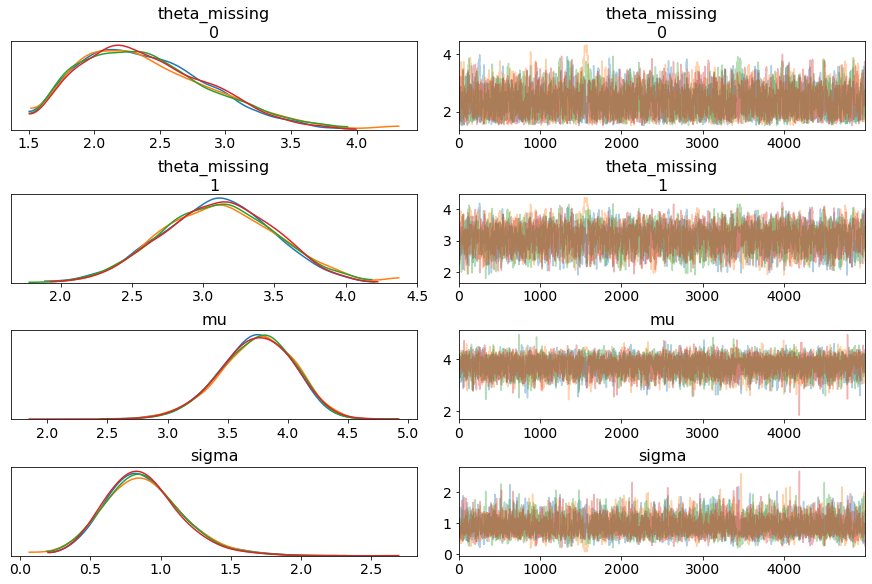

In [8]:
pm.traceplot(trace)

In [9]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta_missing__0,2.404471,0.486684,0.010856,1.573877,3.323834,2083.810171,1.000270
theta_missing__1,3.106949,0.391706,0.008265,2.323815,3.844648,2212.499577,1.000382
mu,3.740136,0.302435,0.004875,3.126037,4.287215,4037.212820,1.000210
sigma,0.881603,0.277522,0.005256,0.345032,1.428424,2798.072406,1.000144


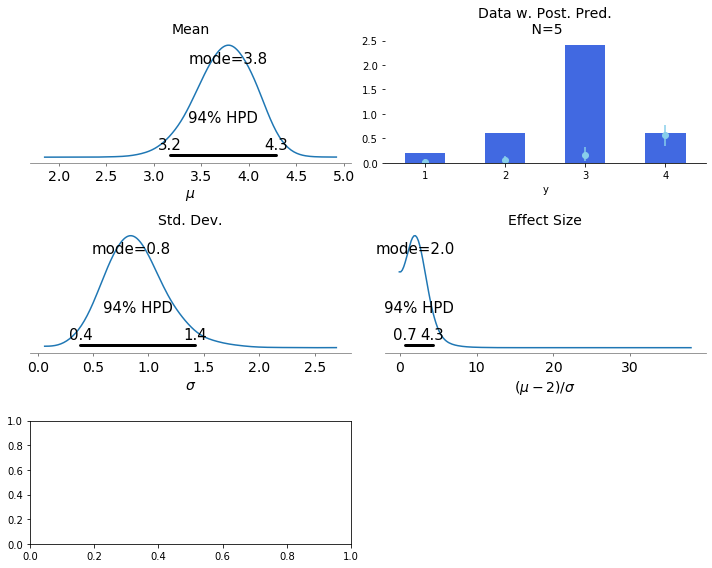

In [11]:
from matplotlib import gridspec
import seaborn as sns
color = '#87ceeb'
f_dict = {'size':14}
mu = trace['mu']
sigma = trace['sigma']

# Concatenate the fixed thresholds into the estimated thresholds
n = trace['theta_missing'].shape[0]
thresholds = np.c_[np.tile([1.5], (n,1)),
                   trace['theta_missing'],
                   np.tile([4.5], (n,1))]

# Define gridspec
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(3, 2)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])
ax5 = plt.subplot(gs[2,0])

# Mu
pm.plot_posterior(mu, point_estimate='mode', color=color, ax=ax1)
ax1.set_title('Mean', fontdict=f_dict)
ax1.set_xlabel('$\mu$', fontdict=f_dict)

# Posterior predictive probabilities of the outcomes
threshCumProb = np.empty(thresholds.shape)

for i in np.arange(threshCumProb.shape[0]):
    threshCumProb[i] = norm().cdf((thresholds[i] - mu[i])/sigma[i])
    
outProb = (np.c_[threshCumProb, np.tile(1, (thresholds.shape[0],1))] - np.c_[np.tile(0, (thresholds.shape[0],1)), threshCumProb])
yerr = np.abs(np.subtract(pm.hpd(outProb), outProb.mean(axis=0).reshape(-1,1)))

((lk_27-1).value_counts(sort=False)/nYlevels).plot.bar(ax=ax2, rot=0, color='royalblue')
ax2.errorbar(x = np.arange(nYlevels), y=outProb.mean(axis=0), yerr=yerr.T, color=color, fmt='o')
ax2.set_xlabel('y')
sns.despine(ax=ax2, left=True)
# ax2.yaxis.set_visible(False)
ax2.set_title('Data w. Post. Pred.\n N={}'.format(nYlevels), fontdict=f_dict)

# Sigma
pm.plot_posterior(sigma, point_estimate='mode', color=color, ax=ax3)
ax3.set_title('Std. Dev.', fontdict=f_dict)
ax3.set_xlabel('$\sigma$', fontdict=f_dict)

# Effect size
pm.plot_posterior((mu-2)/sigma,point_estimate='mode',  color=color, ax=ax4)
ax4.set_title('Effect Size', fontdict=f_dict)
ax4.set_xlabel('$(\mu-2)/\sigma$', fontdict=f_dict)

# Posterior distribution on the thresholds
# ax5.scatter(thresholds, np.tile(thresholds.mean(axis=1).reshape(-1,1), (1,6)), color=color, alpha=.6, facecolor='none')
# ax5.set_ylabel('Mean Threshold', fontdict=f_dict)
# ax5.set_xlabel('Threshold', fontdict=f_dict)
# ax5.vlines(x = thresholds.mean(axis=0),
#            ymin=thresholds.mean(axis=1).min(),
#            ymax=thresholds.mean(axis=1).max(), linestyles='dotted', colors=color)

fig.tight_layout()

In [14]:
print(thresholds.shape)
print(thresholds)
print(outProb)
print(outProb.mean(axis=0))
# print(yerr)
print(threshCumProb)
np.array([0,0.2, 0.6, 2.4, 0.6])/sum([0,0.2, 0.6, 2.4, 0.6])

(20000, 4)
[[1.5        2.67945466 3.05302892 4.5       ]
 [1.5        2.44839047 2.90197677 4.5       ]
 [1.5        2.21850424 2.94456086 4.5       ]
 ...
 [1.5        3.75215009 4.03651826 4.5       ]
 [1.5        3.70276202 3.88336838 4.5       ]
 [1.5        3.29962549 3.67579747 4.5       ]]
[[1.35029362e-04 2.58536004e-02 5.39996812e-02 6.71556590e-01
  2.48455099e-01]
 [2.47636329e-02 1.15987688e-01 1.16227014e-01 5.43132588e-01
  1.99889076e-01]
 [1.48993351e-03 1.64293324e-02 9.35889530e-02 6.36148460e-01
  2.52343321e-01]
 ...
 [4.92760374e-28 3.42008262e-02 2.15839535e-01 6.34248687e-01
  1.15710952e-01]
 [3.12662144e-13 5.26667470e-02 6.98689253e-02 5.32269078e-01
  3.45195250e-01]
 [9.00447518e-10 3.09869846e-02 1.27822224e-01 6.57267380e-01
  1.83923411e-01]]
[0.01726282 0.05726705 0.16599293 0.5631458  0.19633139]
[[1.35029362e-04 2.59886297e-02 7.99883109e-02 7.51544901e-01]
 [2.47636329e-02 1.40751321e-01 2.56978336e-01 8.00110924e-01]
 [1.48993351e-03 1.79192659e-02 

array([0.        , 0.05263158, 0.15789474, 0.63157895, 0.15789474])

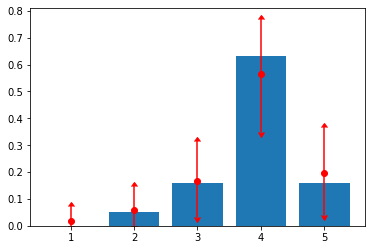

array([[0.01726282, 0.05716122, 0.13420643, 0.21448318, 0.15776105],
       [0.05787033, 0.09174106, 0.15046926, 0.20733465, 0.17150566]])

In [15]:
# yerr=np.array([[0.0171023,  0.05190606],
#                [0.05688711, 0.08563712],
#                [0.12881857, 0.14287911],
#                [0.20265695, 0.20335417],
#                [0.14917756, 0.16691846]])
x = [1,2,3,4,5]
y = outProb.mean(axis=0) #[0.0171023,  0.05695131, 0.16608955, 0.56333736, 0.19651949]
yData = np.array([0,0.2, 0.6, 2.4, 0.6])/sum([0,0.2, 0.6, 2.4, 0.6])#np.array([0.,0.05263158,0.15789474,0.63157895,0.15789474])
fig, ax = plt.subplots()
ax.bar(x,yData)
ax.errorbar(x=x, y=outProb.mean(axis=0), yerr=yerr.T, color='red',fmt='o', uplims=True, lolims=True,)
plt.show()
yerr.T